In [1]:
from pylab import *
import matplotlib as mpl
from craft import calc11
import numpy as np
from scipy import constants
from craft import uvfits
from craft.craco_plan import PipelinePlan, calc_overlap_channels, FdmtRun, FdmtPlan
from craft.craco import BaselineCell
from craft.fdmt_plan import *

%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
# these files exist on keiths laptop

fin = 'output_beam00.uvfits' # this is only 4 seconds of data
fin = 'b00.uvfits'

# changes to baseline ID
fin = '/data/seren-07/big/craco/SB052175/scans/00/20230827081815/newplan/b16.uvfits'

# stupid stuff - None in runs
fin = '/data/seren-05/big/craco/SB052175/scans/00/20230827081815/newplan/b34.uvfits'

In [3]:
f = uvfits.open(fin)

In [4]:
f.nblocks


769

In [5]:
plan = PipelinePlan(f, '--ndm 40')

parsing values --ndm 40


/data/seren-01/fast/ban115/build/craft/src/craft/uvfits.py:270: UserWarning: Dont yet support multiple source files: 2 - using source at 2 which is (2, 'VAST_1404-62', 0, '', 0.0, 0.0, 0.0, 0.0, 0.0, 119.99999999999982, 205.46011536078737, -61.86029596485927, 2000.0, 205.46011536078737, -61.86029596485927, 0.0, 0.0, 0.0, 0.0)
  warnings.warn(f'Dont yet support multiple source files: {len(source_table)} - using source at {first_targetidx} which is {row}')
/data/seren-01/fast/ban115/build/craft/src/craft/craco_plan.py:150: UserWarning: Cannot grid things on U=0 or V=0 blid=260.0 1-4 uvpix=(0, 253)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/seren-01/fast/ban115/build/craft/src/craft/craco_plan.py:150: UserWarning: Cannot grid things on U=0 or V=0 blid=260.0 1-4 uvpix=(0, 252)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/seren-01/fast/ban115/build/craft/src/craft/craco_plan.py:150: UserWar

In [6]:
plan.fdmt_plan

FdmtPlan ncell=1630 zero cell=(141, 1) nruns=270

In [7]:
plan.fdmt_plan.nruns

270

plan.fdmt_plan.nuvtotal

In [8]:
print(f'There are {plan.nbl} baselines and {len(plan.uvcells)} UV cells but after planning we got {plan.fdmt_plan.nuvtotal} cells - which basically sux')

There are 190 baselines and 1630 UV cells but after planning we got 2160 cells - which basically sux


In [9]:
plan.uvcells[0]

Cell blid=1029.0 chan=0-119 freq=887.99-1006.99 uvpix=(251, 255) upper_idx=260 uvpix_upper=(5, 1)

In [10]:
f2 = uvfits.open(fin, skip_blocks=f.nblocks-1)
plan2 = PipelinePlan(f2, '--ndm 40')

parsing values --ndm 40


/data/seren-01/fast/ban115/build/craft/src/craft/uvfits.py:270: UserWarning: Dont yet support multiple source files: 2 - using source at 2 which is (2, 'VAST_1404-62', 0, '', 0.0, 0.0, 0.0, 0.0, 0.0, 119.99999999999982, 205.46011536078737, -61.86029596485927, 2000.0, 205.46011536078737, -61.86029596485927, 0.0, 0.0, 0.0, 0.0)
  warnings.warn(f'Dont yet support multiple source files: {len(source_table)} - using source at {first_targetidx} which is {row}')
/data/seren-01/fast/ban115/build/craft/src/craft/craco_plan.py:150: UserWarning: Cannot grid things on U=0 or V=0 blid=260.0 1-4 uvpix=(0, 253)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/seren-01/fast/ban115/build/craft/src/craft/craco_plan.py:150: UserWarning: Cannot grid things on U=0 or V=0 blid=260.0 1-4 uvpix=(0, 252)
  warnings.warn(f'Cannot grid things on U=0 or V=0 blid={blid} {a1}-{a2} uvpix={uvpix}')
/data/seren-01/fast/ban115/build/craft/src/craft/craco_plan.py:150: UserWar

In [11]:
(f2.tstart - f.tstart).value*86400

84.93464291095734

In [12]:
def printstats(plan):
    print(f'At {plan.tstart.iso} There are {plan.nbl} baselines and {len(plan.uvcells)} UV cells. After planning we got {plan.fdmt_plan.nruns} runs with {plan.fdmt_plan.nuvtotal} nuvtotal cells up by {plan.fdmt_plan.nuvtotal/len(plan.uvcells)}')
printstats(plan)
printstats(plan2)

At 2023-08-27 08:19:17.758 There are 190 baselines and 1630 UV cells. After planning we got 270 runs with 2160 nuvtotal cells up by 1.3251533742331287
At 2023-08-27 08:20:42.693 There are 190 baselines and 1629 UV cells. After planning we got 268 runs with 2144 nuvtotal cells up by 1.3161448741559238


In [13]:
plan.uvcells[0]

Cell blid=1029.0 chan=0-119 freq=887.99-1006.99 uvpix=(251, 255) upper_idx=260 uvpix_upper=(5, 1)

In [14]:
plan.uvcells[1]

Cell blid=3093.0 chan=0-2 freq=887.99-889.99 uvpix=(21, 1) upper_idx=276 uvpix_upper=(21, 1)

In [15]:
blids = sorted(plan.baselines.keys())

In [16]:
def printcell(cells, icell):
    if icell >= len(cells):
        s = 'X\t\t\t'
    else:
        c = cells[icell]
        s = f'uv={c.uvpix} chan(n={c.nchan})={c.chan_start}-{c.chan_end}'
    return s



nequal = 0
nreduce = 0
nincrease = 0
for blid in blids:
    p1cells = find_cells(plan.uvcells, blid)
    p2cells = find_cells(plan2.uvcells, blid) 
    
    n1 = len(p1cells)
    n2 = len(p2cells)
    if n2 > n1:
        nincrease += 1
    elif n2 < n1:
        nreduce += 1
    else:
        nequal += 1
    
    
    print(f'Baseline {blid}: ncells {len(p1cells)}->{len(p2cells)}')
    if len(p1cells) < len(p2cells):
        #print(f'Baseline ID {blid} from {plan.tstart.iso} to {plan2.tstart.iso}')
        for icell in range(max(len(p1cells), len(p2cells))):
            newcell = p2cells[icell]
            if len(p1cells) == 0:
                print('This baseline isnt in the previous plan. Grrr')
            else:
                best = get_cell_with_highest_overlap(newcell, p1cells)
                overlap = cell_channel_overlap(newcell, best)
                print(f'i=[{icell}]', printcell(p1cells, icell), '\t', printcell(p2cells, icell), 'best=',best, 'overlap=', overlap)
                        
            
        
print(f'nequal={nequal} nincrease={nincrease} nreduce={nreduce}')            

Baseline 258.0: ncells 1->1
Baseline 260.0: ncells 0->0
Baseline 261.0: ncells 3->3
Baseline 262.0: ncells 3->3
Baseline 263.0: ncells 5->5
Baseline 264.0: ncells 5->5
Baseline 265.0: ncells 4->5
i=[0] uv=(239, 241) chan(n=25)=0-24 	 uv=(239, 241) chan(n=20)=0-19 best= Cell blid=265.0 chan=0-24 freq=887.99-911.99 uvpix=(239, 241) upper_idx=3737 uvpix_upper=(17, 15) overlap= 20
i=[1] uv=(238, 240) chan(n=52)=25-76 	 uv=(239, 240) chan(n=7)=20-26 best= Cell blid=265.0 chan=0-24 freq=887.99-911.99 uvpix=(239, 241) upper_idx=3737 uvpix_upper=(17, 15) overlap= 5
i=[2] uv=(237, 240) chan(n=7)=77-83 	 uv=(238, 240) chan(n=51)=27-77 best= Cell blid=265.0 chan=25-76 freq=912.99-963.99 uvpix=(238, 240) upper_idx=3978 uvpix_upper=(18, 16) overlap= 50
i=[3] uv=(237, 239) chan(n=36)=84-119 	 uv=(238, 239) chan(n=1)=78-78 best= Cell blid=265.0 chan=77-83 freq=964.99-970.99 uvpix=(237, 240) upper_idx=3979 uvpix_upper=(19, 16) overlap= 1
i=[4] X			 	 uv=(237, 239) chan(n=41)=79-119 best= Cell blid=265

i=[4] uv=(65, 239) chan(n=15)=40-54 	 uv=(65, 239) chan(n=6)=47-52 best= Cell blid=534.0 chan=40-54 freq=927.99-941.99 uvpix=(65, 239) upper_idx=4390 uvpix_upper=(191, 17) overlap= 6
i=[5] uv=(66, 239) chan(n=14)=55-68 	 uv=(66, 239) chan(n=15)=53-67 best= Cell blid=534.0 chan=55-68 freq=942.99-955.99 uvpix=(66, 239) upper_idx=4389 uvpix_upper=(190, 17) overlap= 13
i=[6] uv=(67, 238) chan(n=14)=69-82 	 uv=(67, 239) chan(n=14)=68-81 best= Cell blid=534.0 chan=69-82 freq=956.99-969.99 uvpix=(67, 238) upper_idx=4626 uvpix_upper=(189, 18) overlap= 13
i=[7] uv=(68, 238) chan(n=15)=83-97 	 uv=(68, 239) chan(n=15)=82-96 best= Cell blid=534.0 chan=83-97 freq=970.99-984.99 uvpix=(68, 238) upper_idx=4625 uvpix_upper=(188, 18) overlap= 14
i=[8] uv=(69, 238) chan(n=14)=98-111 	 uv=(69, 239) chan(n=7)=97-103 best= Cell blid=534.0 chan=98-111 freq=985.99-998.99 uvpix=(69, 238) upper_idx=4624 uvpix_upper=(187, 18) overlap= 6
i=[9] uv=(70, 238) chan(n=8)=112-119 	 uv=(69, 238) chan(n=7)=104-110 best= 

i=[5] uv=(1, 71) chan(n=13)=67-79 	 uv=(1, 70) chan(n=13)=56-68 best= Cell blid=1303.0 chan=53-66 freq=940.99-953.99 uvpix=(1, 70) upper_idx=30480 uvpix_upper=(255, 186) overlap= 11
i=[6] uv=(1, 72) chan(n=14)=80-93 	 uv=(1, 71) chan(n=14)=69-82 best= Cell blid=1303.0 chan=67-79 freq=954.99-966.99 uvpix=(1, 71) upper_idx=30410 uvpix_upper=(255, 185) overlap= 11
i=[7] uv=(1, 73) chan(n=13)=94-106 	 uv=(1, 72) chan(n=14)=83-96 best= Cell blid=1303.0 chan=80-93 freq=967.99-980.99 uvpix=(1, 72) upper_idx=30339 uvpix_upper=(255, 184) overlap= 11
i=[8] uv=(1, 74) chan(n=13)=107-119 	 uv=(1, 73) chan(n=13)=97-109 best= Cell blid=1303.0 chan=94-106 freq=981.99-993.99 uvpix=(1, 73) upper_idx=30267 uvpix_upper=(255, 183) overlap= 10
i=[9] X			 	 uv=(1, 74) chan(n=10)=110-119 best= Cell blid=1303.0 chan=107-119 freq=994.99-1006.99 uvpix=(1, 74) upper_idx=30194 uvpix_upper=(255, 182) overlap= 10
Baseline 1543.0: ncells 5->5
Baseline 1544.0: ncells 7->7
Baseline 1545.0: ncells 5->5
Baseline 1546.0:

i=[4] uv=(27, 205) chan(n=1)=52-52 	 uv=(27, 206) chan(n=9)=40-48 best= Cell blid=2059.0 chan=33-51 freq=920.99-938.99 uvpix=(27, 206) upper_idx=11754 uvpix_upper=(229, 50) overlap= 9
i=[5] uv=(28, 205) chan(n=17)=53-69 	 uv=(28, 206) chan(n=10)=49-58 best= Cell blid=2059.0 chan=53-69 freq=940.99-956.99 uvpix=(28, 205) upper_idx=11958 uvpix_upper=(228, 51) overlap= 6
i=[6] uv=(28, 204) chan(n=17)=70-86 	 uv=(28, 205) chan(n=19)=59-77 best= Cell blid=2059.0 chan=53-69 freq=940.99-956.99 uvpix=(28, 205) upper_idx=11958 uvpix_upper=(228, 51) overlap= 11
i=[7] uv=(29, 204) chan(n=2)=87-88 	 uv=(28, 204) chan(n=5)=78-82 best= Cell blid=2059.0 chan=70-86 freq=957.99-973.99 uvpix=(28, 204) upper_idx=12162 uvpix_upper=(228, 52) overlap= 5
i=[8] uv=(29, 203) chan(n=18)=89-106 	 uv=(29, 204) chan(n=13)=83-95 best= Cell blid=2059.0 chan=89-106 freq=976.99-993.99 uvpix=(29, 203) upper_idx=12364 uvpix_upper=(227, 53) overlap= 7
i=[9] uv=(29, 202) chan(n=13)=107-119 	 uv=(29, 203) chan(n=19)=96-114 

i=[2] uv=(12, 59) chan(n=4)=17-20 	 uv=(12, 59) chan(n=12)=18-29 best= Cell blid=2318.0 chan=21-32 freq=908.99-919.99 uvpix=(13, 59) upper_idx=31172 uvpix_upper=(243, 197) overlap= 9
i=[3] uv=(13, 59) chan(n=12)=21-32 	 uv=(13, 59) chan(n=4)=30-33 best= Cell blid=2318.0 chan=21-32 freq=908.99-919.99 uvpix=(13, 59) upper_idx=31172 uvpix_upper=(243, 197) overlap= 3
i=[4] uv=(13, 60) chan(n=15)=33-47 	 uv=(13, 60) chan(n=15)=34-48 best= Cell blid=2318.0 chan=33-47 freq=920.99-934.99 uvpix=(13, 60) upper_idx=31113 uvpix_upper=(243, 196) overlap= 14
i=[5] uv=(13, 61) chan(n=16)=48-63 	 uv=(13, 61) chan(n=16)=49-64 best= Cell blid=2318.0 chan=48-63 freq=935.99-950.99 uvpix=(13, 61) upper_idx=31053 uvpix_upper=(243, 195) overlap= 15
i=[6] uv=(13, 62) chan(n=15)=64-78 	 uv=(13, 62) chan(n=15)=65-79 best= Cell blid=2318.0 chan=64-78 freq=951.99-965.99 uvpix=(13, 62) upper_idx=30992 uvpix_upper=(243, 194) overlap= 14
i=[7] uv=(13, 63) chan(n=15)=79-93 	 uv=(13, 63) chan(n=16)=80-95 best= Cell bl

i=[5] uv=(180, 165) chan(n=4)=26-29 	 uv=(181, 164) chan(n=2)=26-27 best= Cell blid=3344.0 chan=26-29 freq=913.99-916.99 uvpix=(180, 165) upper_idx=28725 uvpix_upper=(180, 165) overlap= 2
i=[6] uv=(180, 164) chan(n=8)=30-37 	 uv=(180, 164) chan(n=8)=28-35 best= Cell blid=3344.0 chan=30-37 freq=917.99-924.99 uvpix=(180, 164) upper_idx=28634 uvpix_upper=(180, 164) overlap= 6
i=[7] uv=(179, 164) chan(n=2)=38-39 	 uv=(180, 163) chan(n=4)=36-39 best= Cell blid=3344.0 chan=30-37 freq=917.99-924.99 uvpix=(180, 164) upper_idx=28634 uvpix_upper=(180, 164) overlap= 2
i=[8] uv=(179, 163) chan(n=10)=40-49 	 uv=(179, 163) chan(n=6)=40-45 best= Cell blid=3344.0 chan=40-49 freq=927.99-936.99 uvpix=(179, 163) upper_idx=28541 uvpix_upper=(179, 163) overlap= 6
i=[9] uv=(178, 162) chan(n=10)=50-59 	 uv=(179, 162) chan(n=6)=46-51 best= Cell blid=3344.0 chan=40-49 freq=927.99-936.99 uvpix=(179, 163) upper_idx=28541 uvpix_upper=(179, 163) overlap= 4
i=[10] uv=(178, 161) chan(n=2)=60-61 	 uv=(178, 162) chan(

i=[5] uv=(46, 191) chan(n=14)=42-55 	 uv=(46, 192) chan(n=14)=36-49 best= Cell blid=3604.0 chan=42-55 freq=929.99-942.99 uvpix=(46, 191) upper_idx=14705 uvpix_upper=(210, 65) overlap= 8
i=[6] uv=(46, 190) chan(n=3)=56-58 	 uv=(46, 191) chan(n=5)=50-54 best= Cell blid=3604.0 chan=42-55 freq=929.99-942.99 uvpix=(46, 191) upper_idx=14705 uvpix_upper=(210, 65) overlap= 5
i=[7] uv=(47, 190) chan(n=11)=59-69 	 uv=(47, 191) chan(n=10)=55-64 best= Cell blid=3604.0 chan=59-69 freq=946.99-956.99 uvpix=(47, 190) upper_idx=14894 uvpix_upper=(209, 66) overlap= 6
i=[8] uv=(47, 189) chan(n=9)=70-78 	 uv=(47, 190) chan(n=11)=65-75 best= Cell blid=3604.0 chan=70-78 freq=957.99-965.99 uvpix=(47, 189) upper_idx=15083 uvpix_upper=(209, 67) overlap= 6
i=[9] uv=(48, 189) chan(n=6)=79-84 	 uv=(48, 190) chan(n=3)=76-78 best= Cell blid=3604.0 chan=70-78 freq=957.99-965.99 uvpix=(47, 189) upper_idx=15083 uvpix_upper=(209, 67) overlap= 3
i=[10] uv=(48, 188) chan(n=14)=85-98 	 uv=(48, 189) chan(n=15)=79-93 best= 

i=[5] uv=(41, 111) chan(n=9)=25-33 	 uv=(40, 111) chan(n=2)=25-26 best= Cell blid=4119.0 chan=25-33 freq=912.99-920.99 uvpix=(41, 111) upper_idx=26750 uvpix_upper=(215, 145) overlap= 2
i=[6] uv=(41, 112) chan(n=8)=34-41 	 uv=(41, 111) chan(n=7)=27-33 best= Cell blid=4119.0 chan=25-33 freq=912.99-920.99 uvpix=(41, 111) upper_idx=26750 uvpix_upper=(215, 145) overlap= 7
i=[7] uv=(41, 113) chan(n=3)=42-44 	 uv=(41, 112) chan(n=8)=34-41 best= Cell blid=4119.0 chan=34-41 freq=921.99-928.99 uvpix=(41, 112) upper_idx=26639 uvpix_upper=(215, 144) overlap= 8
i=[8] uv=(42, 113) chan(n=5)=45-49 	 uv=(41, 113) chan(n=8)=42-49 best= Cell blid=4119.0 chan=45-49 freq=932.99-936.99 uvpix=(42, 113) upper_idx=26526 uvpix_upper=(214, 143) overlap= 5
i=[9] uv=(42, 114) chan(n=8)=50-57 	 uv=(42, 114) chan(n=8)=50-57 best= Cell blid=4119.0 chan=50-57 freq=937.99-944.99 uvpix=(42, 114) upper_idx=26413 uvpix_upper=(214, 142) overlap= 8
i=[10] uv=(42, 115) chan(n=9)=58-66 	 uv=(42, 115) chan(n=9)=58-66 best= Ce

i=[15] uv=(230, 114) chan(n=9)=104-112 	 uv=(230, 114) chan(n=4)=109-112 best= Cell blid=4887.0 chan=104-112 freq=991.99-999.99 uvpix=(230, 114) upper_idx=22859 uvpix_upper=(230, 114) overlap= 4
i=[16] uv=(230, 115) chan(n=7)=113-119 	 uv=(229, 114) chan(n=5)=113-117 best= Cell blid=4887.0 chan=113-119 freq=1000.99-1006.99 uvpix=(230, 115) upper_idx=23000 uvpix_upper=(230, 115) overlap= 5
i=[17] X			 	 uv=(229, 115) chan(n=2)=118-119 best= Cell blid=4887.0 chan=113-119 freq=1000.99-1006.99 uvpix=(230, 115) upper_idx=23000 uvpix_upper=(230, 115) overlap= 2
Baseline 5141.0: ncells 3->3
Baseline 5142.0: ncells 4->5
i=[0] uv=(25, 5) chan(n=26)=0-25 	 uv=(25, 5) chan(n=26)=0-25 best= Cell blid=5142.0 chan=0-25 freq=887.99-912.99 uvpix=(25, 5) upper_idx=1290 uvpix_upper=(25, 5) overlap= 26
i=[1] uv=(26, 5) chan(n=36)=26-61 	 uv=(26, 5) chan(n=35)=26-60 best= Cell blid=5142.0 chan=26-61 freq=913.99-948.99 uvpix=(26, 5) upper_idx=1291 uvpix_upper=(26, 5) overlap= 35
i=[2] uv=(27, 5) chan(n=36)

In [17]:
cell = plan.uvcells[100]
print(cell)
chan_positions = np.arange(0,32*12,32)

print(chan_positions)
chan = chan_with_best_overlap(cell, chan_positions, chan_width=32)


Cell blid=1558.0 chan=25-41 freq=912.99-928.99 uvpix=(55, 249) upper_idx=1965 uvpix_upper=(201, 7)
[  0  32  64  96 128 160 192 224 256 288 320 352]


In [18]:
run_cells = fixed_algorithm(plan.uvcells, chan_positions, chan_width=32)
runs = [FdmtRun.from_cells(cells, plan.fdmt_plan, chan_start) for (chan_start, cells) in run_cells]
runs

[ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=256,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=253,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=226,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=204,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=196,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=180,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=168,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=160,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=155,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=144,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=137,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=136,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=130,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=121,
 ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=120,
 ncells=8 fch1=887990740.

# Making a new plan from an old one

Baselines indexes don't change. FDMT chan_positions and chan_width don't change. UVWs and cells change. A given input uvcell will have a 1-many relationship to planned UVcells due to NCIN limit (i.e. cells with > 32 channels will be split).

In [19]:
initial_runs = [FdmtRun.from_cells(cells, plan.fdmt_plan, chan_start) for (chan_start, cells) in run_cells]
run_cells2 = fixed_algorithm(plan2.uvcells, chan_positions, chan_width=32)
runs2 = [FdmtRun.from_cells(cells, plan2.fdmt_plan, chan_start) for (chan_start, cells) in run_cells2]


In [20]:
plan.fdmt_plan.runs[0]

ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=256

In [21]:
initial_runs[0]

ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=256

In [22]:
import logging
logger = logging.getLogger()
#logger.setLevel(logging.DEBUG)
logger.setLevel(logging.INFO)

container1 = FdmtPlanContainer(plan.fdmt_plan, plan.fdmt_plan.runs, None)
container2 = FdmtPlanContainer(plan2.fdmt_plan, runs2, container1)

It's assigning new runs to old runs and then gets to 96-105. This started out as 96-119 and then got split into 96-105 and 106-119. 96-105 has 10 channels and it tries to find somethign to overlap. 106-119 has already eaten that cell (14 channels), so there's noethign left for it. We should leave it and add it as a new thing. But we can keep doing other ones as there's one more channel to go

In [23]:
container2.runs[0]

ncells=0 fch1=887990740.7407408 chan_start=0 total_overlap=0

In [24]:
container2.nchan

0

In [25]:
migrate_plan(container1, container2)

INFO:craft.fdmt_plan:Migrated plan from FdmtPlanContainer nruns=270 nc=21747 overlap=0=0.0% to FdmtPlanContainer nruns=312 nc=21600 overlap=17086=79.1%


FdmtPlanContainer nruns=312 nc=21600 overlap=17086=79.1%

In [26]:
container1

FdmtPlanContainer nruns=270 nc=21747 overlap=0=0.0%

In [27]:
container1.nchan_array

array([[32., 32., 32., ..., 32., 32., 32.],
       [32., 32., 32., ..., 32., 31., 30.],
       [30., 30., 29., ..., 27., 27., 26.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

<IPython.core.display.Javascript object>


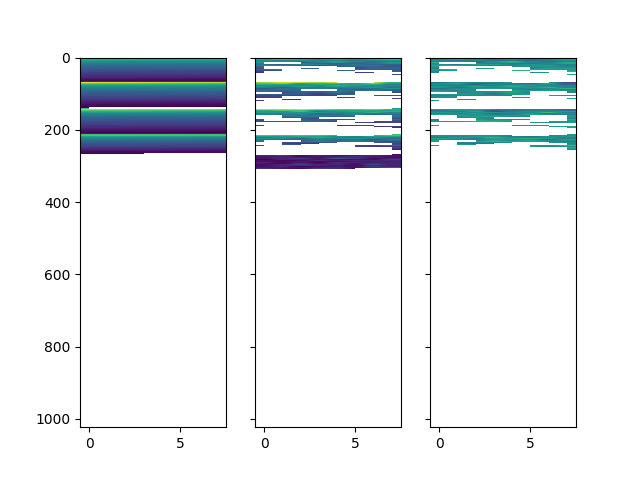

In [28]:
fig,ax = subplots(1,3, sharex=True, sharey=True)
ax[0].imshow(container1.nchan_array, aspect='auto')
ax[1].imshow(container2.nchan_array, aspect='auto')
ax[2].imshow(container2.nchan_array - container1.nchan_array, aspect='auto')

<IPython.core.display.Javascript object>


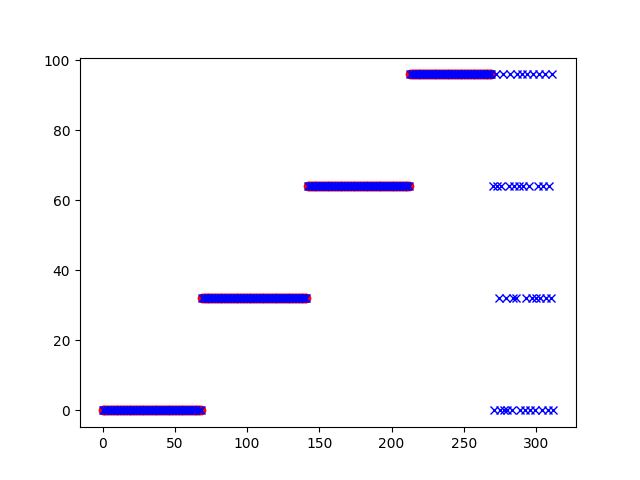

In [29]:
figure()
plot(container1.start_chan_array, 'ro')
plot(container2.start_chan_array,'bx')

In [30]:
container2.nchan
print(container2.nchan == sum(c.nchan for c in plan2.uvcells))

True


/data/seren-01/fast/ban115/build/venv3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


In [31]:
print(container1.nchan)
print(container1.nchan == sum(c.nchan for c in plan.uvcells))

21747
True


/data/seren-01/fast/ban115/build/venv3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


In [32]:
blid = 268.0
cells1 = container1.uvcells_of(blid)
cells2 = container2.uvcells_of(blid)

In [33]:
container2.plan.pipeline_plan.nbl

190

In [34]:
container2.total_overlap


17086

In [35]:
container2.nchan

21600

In [36]:
cells2

[Cell blid=268.0 chan=0-27 freq=887.99-914.99 uvpix=(31, 239) upper_idx=4424 uvpix_upper=(225, 17),
 Cell blid=268.0 chan=28-31 freq=915.99-918.99 uvpix=(32, 239) upper_idx=4423 uvpix_upper=(224, 17),
 Cell blid=268.0 chan=32-56 freq=919.99-943.99 uvpix=(32, 238) upper_idx=4661 uvpix_upper=(224, 18),
 Cell blid=268.0 chan=57-63 freq=944.99-950.99 uvpix=(33, 238) upper_idx=4660 uvpix_upper=(223, 18),
 Cell blid=268.0 chan=64-83 freq=951.99-970.99 uvpix=(33, 238) upper_idx=4660 uvpix_upper=(223, 18),
 Cell blid=268.0 chan=84-85 freq=971.99-972.99 uvpix=(33, 237) upper_idx=4897 uvpix_upper=(223, 19),
 Cell blid=268.0 chan=86-95 freq=973.99-982.99 uvpix=(34, 237) upper_idx=4896 uvpix_upper=(222, 19),
 Cell blid=268.0 chan=96-114 freq=983.99-1001.99 uvpix=(34, 237) upper_idx=4896 uvpix_upper=(222, 19),
 Cell blid=268.0 chan=115-119 freq=1002.99-1006.99 uvpix=(35, 237) upper_idx=4895 uvpix_upper=(221, 19)]

OK - I'm not really thinking clearly here - I think I need to come back to this when I'm not sick. It's fine, it just takes a bit more wrangling to celar up the data structure.

In [37]:
plan1 = PipelinePlan(f, '--ndm 40')
plan2 = PipelinePlan(f2, '--ndm 40', prev_plan=plan1)

INFO:craft.craco_plan:Unknown beamid
INFO:craft.craco_plan:making Plan values=Namespace(boxcar_weight='sum', calibration=None, cell=None, fdmt_scale=1.0, fft_scale=10.0, flag_ants=None, max_nbl=630.0, max_ndm=1024, nbox=8, ncin=32, ndm=40, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', pickle_fname='pipeline.pickle', save=False, show=False, show_fdmt=False, show_image=False, target_input_rms=512, threshold=3, uv='uv_data', verbose=False) prev plan:None


parsing values --ndm 40


/data/seren-01/fast/ban115/build/craft/src/craft/uvfits.py:270: UserWarning: Dont yet support multiple source files: 2 - using source at 2 which is (2, 'VAST_1404-62', 0, '', 0.0, 0.0, 0.0, 0.0, 0.0, 119.99999999999982, 205.46011536078737, -61.86029596485927, 2000.0, 205.46011536078737, -61.86029596485927, 0.0, 0.0, 0.0, 0.0)
  warnings.warn(f'Dont yet support multiple source files: {len(source_table)} - using source at {first_targetidx} which is {row}')
INFO:craft.uvfits:Got radec=(205.46011536078737 deg/-61.86029596485927 deg) from source table for VAST_1404-62
INFO:craft.craco_plan:Nbl=190 Fch1=887990740.740741 foff=1000000.000000 nchan=120 lambdamin=0.297917 uvmax=(4880.224376843552, 3132.6401934153278) max baseline=(1.4539034509652993, 0.933267824620998) resolution=[42.26543501 65.8437591 ]arcsec uvcell=[20.12639763 31.354171  ] arcsec uvcell= (40.03309059129476, 25.697439086610114) lambda FoV=[1.4312105  2.22962994] deg oversampled=(2.1, 2.1) wcs=WCS Keywords

Number of WCS axes:

INFO:craft.craco_plan:Unknown beamid
INFO:craft.craco_plan:making Plan values=Namespace(boxcar_weight='sum', calibration=None, cell=None, fdmt_scale=1.0, fft_scale=10.0, flag_ants=None, max_nbl=630.0, max_ndm=1024, nbox=8, ncin=32, ndm=40, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', pickle_fname='pipeline.pickle', save=False, show=False, show_fdmt=False, show_image=False, target_input_rms=512, threshold=3, uv='uv_data', verbose=False) prev plan:<craft.craco_plan.PipelinePlan object at 0x7fd888df02e8>
/data/seren-01/fast/ban115/build/craft/src/craft/uvfits.py:270: UserWarning: Dont yet support multiple source files: 2 - using source at 2 which is (2, 'VAST_1404-62', 0, '', 0.0, 0.0, 0.0, 0.0, 0.0, 119.99999999999982, 205.46011536078737, -61.86029596485927, 2000.0, 205.46011536078737, -61.86029596485927, 0.0, 0.0, 0.0, 0.0)
  warnings.warn(f'Dont yet support multiple source files: {len(source_table)} - using source at {first_targetidx} which is {row}')
INFO:craft.u

parsing values --ndm 40


In [38]:
plan1.fdmt_plan

INFO:craft.fdmt_plan:Started with 1630 cells which would need at least 204 runs
INFO:craft.fdmt_plan:With 5 channels at [  0  32  64  96 128] we needed 270 runs. An increase of 1.324 
INFO:craft.fdmt_plan:Creating FdmtPlan for 1630 cells plan=<craft.craco_plan.PipelinePlan object at 0x7fd888df02e8> prev_plan=None We have 270 initial runs
INFO:craft.fdmt_plan:Found zero cell among runs: (141, 1)
INFO:craft.fdmt_plan:FDMT zero cell is (141, 1)=1129
INFO:craft.fdmt_plan:FDMT plan has ntotal=2160 of 270 runs with packing efficiency 0.754630. Grid read requires efficiency of > 0.263672 of NUV=8192. History size square=118920960 minimal=6210984 =0 256MB HBM banks
INFO:craft.craco_plan:Saving uvgrid.split shape=(2149, 14) type=float64 to uv_data.uvgrid.split.txt header=ant1, ant2, u(pix), v(pix), chan1, chan2, irun, icell, total_overlap, max_idm, max_offset, offset_cff, idm_cff, fch1
INFO:craft.craco_plan:Got 1563 unique UV coords. Upper=True
INFO:craft.craco_plan:Need to write 98 groups of 1

FdmtPlan ncell=1630 zero cell=(141, 1) nruns=270

In [39]:
logger.setLevel(logging.DEBUG)
#logger.setLevel(logging.INFO)

plan2.fdmt_plan

INFO:craft.fdmt_plan:Started with 1629 cells which would need at least 204 runs
INFO:craft.fdmt_plan:With 5 channels at [  0  32  64  96 128] we needed 268 runs. An increase of 1.314 
INFO:craft.fdmt_plan:Creating FdmtPlan for 1629 cells plan=<craft.craco_plan.PipelinePlan object at 0x7fd888df02b0> prev_plan=<craft.craco_plan.PipelinePlan object at 0x7fd888df02e8> We have 268 initial runs
INFO:craft.fdmt_plan:Migrate plan from FdmtPlan ncell=1630 zero cell=(141, 1) nruns=270 to FdmtPlan ncell=1629 zero cell=None nruns=0 with 268 new runs
DEBUG:craft.fdmt_plan:Added run at 0 with chan_start=0 prev=ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=256
DEBUG:craft.fdmt_plan:Added run at 1 with chan_start=0 prev=ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=253
DEBUG:craft.fdmt_plan:Added run at 2 with chan_start=0 prev=ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=226
DEBUG:craft.fdmt_plan:Added run at 3 with chan_start=0 prev=ncells=8 fch1=887990740.740

DEBUG:craft.fdmt_plan:Added run at 63 with chan_start=0 prev=ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=16
DEBUG:craft.fdmt_plan:Added run at 64 with chan_start=0 prev=ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=16
DEBUG:craft.fdmt_plan:Added run at 65 with chan_start=0 prev=ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=8
DEBUG:craft.fdmt_plan:Added run at 66 with chan_start=0 prev=ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=8
DEBUG:craft.fdmt_plan:Added run at 67 with chan_start=0 prev=ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=8
DEBUG:craft.fdmt_plan:Added run at 68 with chan_start=0 prev=ncells=8 fch1=887990740.7407408 chan_start=0 total_overlap=8
DEBUG:craft.fdmt_plan:Added run at 69 with chan_start=32 prev=ncells=8 fch1=919990740.7407407 chan_start=32 total_overlap=256
DEBUG:craft.fdmt_plan:Added run at 70 with chan_start=32 prev=ncells=8 fch1=919990740.7407407 chan_start=32 total_overlap=253
DEBUG:craft.fd

DEBUG:craft.fdmt_plan:Added run at 129 with chan_start=32 prev=ncells=8 fch1=919990740.7407407 chan_start=32 total_overlap=19
DEBUG:craft.fdmt_plan:Added run at 130 with chan_start=32 prev=ncells=8 fch1=919990740.7407407 chan_start=32 total_overlap=16
DEBUG:craft.fdmt_plan:Added run at 131 with chan_start=32 prev=ncells=8 fch1=919990740.7407407 chan_start=32 total_overlap=16
DEBUG:craft.fdmt_plan:Added run at 132 with chan_start=32 prev=ncells=8 fch1=919990740.7407407 chan_start=32 total_overlap=16
DEBUG:craft.fdmt_plan:Added run at 133 with chan_start=32 prev=ncells=8 fch1=919990740.7407407 chan_start=32 total_overlap=16
DEBUG:craft.fdmt_plan:Added run at 134 with chan_start=32 prev=ncells=8 fch1=919990740.7407407 chan_start=32 total_overlap=16
DEBUG:craft.fdmt_plan:Added run at 135 with chan_start=32 prev=ncells=8 fch1=919990740.7407407 chan_start=32 total_overlap=9
DEBUG:craft.fdmt_plan:Added run at 136 with chan_start=32 prev=ncells=8 fch1=919990740.7407407 chan_start=32 total_over

DEBUG:craft.fdmt_plan:Added run at 194 with chan_start=64 prev=ncells=8 fch1=951990740.7407407 chan_start=64 total_overlap=40
DEBUG:craft.fdmt_plan:Added run at 195 with chan_start=64 prev=ncells=8 fch1=951990740.7407407 chan_start=64 total_overlap=34
DEBUG:craft.fdmt_plan:Added run at 196 with chan_start=64 prev=ncells=8 fch1=951990740.7407407 chan_start=64 total_overlap=32
DEBUG:craft.fdmt_plan:Added run at 197 with chan_start=64 prev=ncells=8 fch1=951990740.7407407 chan_start=64 total_overlap=32
DEBUG:craft.fdmt_plan:Added run at 198 with chan_start=64 prev=ncells=8 fch1=951990740.7407407 chan_start=64 total_overlap=31
DEBUG:craft.fdmt_plan:Added run at 199 with chan_start=64 prev=ncells=8 fch1=951990740.7407407 chan_start=64 total_overlap=24
DEBUG:craft.fdmt_plan:Added run at 200 with chan_start=64 prev=ncells=8 fch1=951990740.7407407 chan_start=64 total_overlap=24
DEBUG:craft.fdmt_plan:Added run at 201 with chan_start=64 prev=ncells=8 fch1=951990740.7407407 chan_start=64 total_ove

DEBUG:craft.fdmt_plan:Added run at 259 with chan_start=96 prev=ncells=8 fch1=983990740.7407407 chan_start=96 total_overlap=23
DEBUG:craft.fdmt_plan:Added run at 260 with chan_start=96 prev=ncells=8 fch1=983990740.7407407 chan_start=96 total_overlap=16
DEBUG:craft.fdmt_plan:Added run at 261 with chan_start=96 prev=ncells=8 fch1=983990740.7407407 chan_start=96 total_overlap=16
DEBUG:craft.fdmt_plan:Added run at 262 with chan_start=96 prev=ncells=8 fch1=983990740.7407407 chan_start=96 total_overlap=16
DEBUG:craft.fdmt_plan:Added run at 263 with chan_start=96 prev=ncells=8 fch1=983990740.7407407 chan_start=96 total_overlap=16
DEBUG:craft.fdmt_plan:Added run at 264 with chan_start=96 prev=ncells=8 fch1=983990740.7407407 chan_start=96 total_overlap=16
DEBUG:craft.fdmt_plan:Added run at 265 with chan_start=96 prev=ncells=8 fch1=983990740.7407407 chan_start=96 total_overlap=8
DEBUG:craft.fdmt_plan:Added run at 266 with chan_start=96 prev=ncells=8 fch1=983990740.7407407 chan_start=96 total_over

DEBUG:craft.fdmt_plan:Assigning coord=(157, 7) overlap=15 nc=15->16 old=64-78=15 (251, 230) requested=64-79=16 (251, 230)
DEBUG:craft.fdmt_plan:Assigning coord=(154, 3) overlap=16 nc=17->16 old=79-95=17 (251, 229) requested=80-95=16 (251, 229)
DEBUG:craft.fdmt_plan:Assigning coord=(97, 4) overlap=11 nc=11->12 old=32-42=11 (251, 231) requested=32-43=12 (251, 231)
DEBUG:craft.fdmt_plan:Assigning coord=(49, 7) overlap=6 nc=6->7 old=0-5=6 (251, 232) requested=0-6=7 (251, 232)
DEBUG:craft.fdmt_plan:Assigning coord=(256, 1) overlap=3 nc=4->3 old=116-119=4 (251, 228) requested=117-119=3 (251, 228)
DEBUG:craft.fdmt_plan:There are 0 cells that need to be added: []
DEBUG:craft.fdmt_plan:There are 0 cells that need to be deleted: []
DEBUG:craft.fdmt_plan:Plan2 nchan=720 overlap=653 next run=271
DEBUG:craft.fdmt_plan:Assigning coord=(72, 5) overlap=21 nc=25->21 old=32-56=25 (233, 24) requested=34-54=21 (233, 24)
DEBUG:craft.fdmt_plan:Assigning coord=(143, 7) overlap=21 nc=32->21 old=64-95=32 (232,

DEBUG:craft.fdmt_plan:Assigning coord=(46, 7) overlap=2 nc=6->2 old=26-31=6 (255, 22) requested=30-31=2 (255, 22)
DEBUG:craft.fdmt_plan:There are 0 cells that need to be added: []
DEBUG:craft.fdmt_plan:There are 0 cells that need to be deleted: []
DEBUG:craft.fdmt_plan:Plan2 nchan=1200 overlap=1043 next run=272
DEBUG:craft.fdmt_plan:Assigning coord=(92, 6) overlap=12 nc=12->17 old=34-45=12 (225, 208) requested=32-48=17 (225, 208)
DEBUG:craft.fdmt_plan:Assigning coord=(16, 0) overlap=13 nc=15->13 old=0-14=15 (226, 210) requested=0-12=13 (226, 210)
DEBUG:craft.fdmt_plan:Assigning coord=(12, 7) overlap=13 nc=16->13 old=16-31=16 (225, 209) requested=19-31=13 (225, 209)
DEBUG:craft.fdmt_plan:Assigning coord=(100, 6) overlap=10 nc=10->12 old=54-63=10 (224, 207) requested=52-63=12 (224, 207)
DEBUG:craft.fdmt_plan:Assigning coord=(154, 2) overlap=12 nc=17->12 old=76-92=17 (223, 206) requested=78-89=12 (223, 206)
DEBUG:craft.fdmt_plan:Assigning coord=(241, 1) overlap=9 nc=9->12 old=96-104=9 (22

DEBUG:craft.fdmt_plan:Assigning coord=(141, 4) overlap=0 nc=X->4 old=------ (--,--) requested=45-48=4 (236, 39)
DEBUG:craft.fdmt_plan:Found spare cell in irun=270 None at icell=6
DEBUG:craft.fdmt_plan:Assigning coord=(270, 6) overlap=0 nc=X->1 old=------ (--,--) requested=93-93=1 (235, 41)
DEBUG:craft.fdmt_plan:There are 3 cells that need to be deleted: [Cell blid=1043.0 chan=32-37 freq=919.99-924.99 uvpix=(20, 218) upper_idx=9223 uvpix_upper=(236, 38), Cell blid=1043.0 chan=62-63 freq=949.99-950.99 uvpix=(21, 216) upper_idx=9655 uvpix_upper=(235, 40), Cell blid=1043.0 chan=96-98 freq=983.99-985.99 uvpix=(21, 215) upper_idx=9870 uvpix_upper=(235, 41)]
DEBUG:craft.fdmt_plan:Plan2 nchan=1800 overlap=1520 next run=272
DEBUG:craft.fdmt_plan:Assigning coord=(5, 1) overlap=21 nc=23->22 old=6-28=23 (216, 16) requested=5-26=22 (216, 16)
DEBUG:craft.fdmt_plan:Assigning coord=(153, 3) overlap=17 nc=17->22 old=74-90=17 (213, 17) requested=73-94=22 (213, 17)
DEBUG:craft.fdmt_plan:Assigning coord=(

DEBUG:craft.fdmt_plan:Assigning coord=(185, 6) overlap=6 nc=7->6 old=64-70=7 (200, 14) requested=64-69=6 (200, 13)
DEBUG:craft.fdmt_plan:Assigning coord=(133, 6) overlap=2 nc=2->4 old=32-33=2 (202, 13) requested=32-35=4 (202, 13)
DEBUG:craft.fdmt_plan:Assigning coord=(58, 6) overlap=2 nc=3->2 old=0-2=3 (204, 13) requested=0-1=2 (204, 13)
DEBUG:craft.fdmt_plan:There are 0 cells that need to be added: []
DEBUG:craft.fdmt_plan:There are 2 cells that need to be deleted: [Cell blid=1045.0 chan=34-36 freq=921.99-923.99 uvpix=(54, 242) upper_idx=3681 uvpix_upper=(202, 14), Cell blid=1045.0 chan=103-104 freq=990.99-991.99 uvpix=(58, 241) upper_idx=3918 uvpix_upper=(198, 15)]
DEBUG:craft.fdmt_plan:Plan2 nchan=2520 overlap=2197 next run=272
DEBUG:craft.fdmt_plan:Assigning coord=(23, 7) overlap=11 nc=12->14 old=0-11=12 (252, 65) requested=1-14=14 (252, 65)
DEBUG:craft.fdmt_plan:Assigning coord=(18, 1) overlap=11 nc=14->14 old=12-25=14 (252, 66) requested=15-28=14 (252, 66)
DEBUG:craft.fdmt_plan:A

DEBUG:craft.fdmt_plan:Found spare cell in irun=272 None at icell=2
DEBUG:craft.fdmt_plan:Assigning coord=(272, 2) overlap=0 nc=X->1 old=------ (--,--) requested=119-119=1 (229, 70)
DEBUG:craft.fdmt_plan:There are 3 cells that need to be deleted: [Cell blid=2067.0 chan=10-10 freq=897.99-897.99 uvpix=(23, 193) upper_idx=14345 uvpix_upper=(233, 63), Cell blid=2067.0 chan=49-52 freq=936.99-939.99 uvpix=(25, 191) upper_idx=14726 uvpix_upper=(231, 65), Cell blid=2067.0 chan=64-67 freq=951.99-954.99 uvpix=(25, 190) upper_idx=14916 uvpix_upper=(231, 66)]
DEBUG:craft.fdmt_plan:Plan2 nchan=2880 overlap=2449 next run=274
DEBUG:craft.fdmt_plan:Assigning coord=(35, 0) overlap=9 nc=9->20 old=8-16=9 (212, 41) requested=6-25=20 (212, 41)
DEBUG:craft.fdmt_plan:Assigning coord=(163, 4) overlap=10 nc=12->16 old=70-81=12 (209, 44) requested=72-87=16 (209, 44)
DEBUG:craft.fdmt_plan:Assigning coord=(98, 6) overlap=8 nc=10->15 old=39-48=10 (211, 43) requested=32-46=15 (211, 42)
DEBUG:craft.fdmt_plan:Assignin

DEBUG:craft.fdmt_plan:Assigning coord=(126, 1) overlap=3 nc=3->5 old=60-62=3 (183, 38) requested=59-63=5 (183, 38)
DEBUG:craft.fdmt_plan:Assigning coord=(256, 6) overlap=2 nc=4->2 old=96-99=4 (181, 40) requested=96-97=2 (181, 39)
DEBUG:craft.fdmt_plan:Assigning coord=(133, 7) overlap=1 nc=2->1 old=32-33=2 (186, 37) requested=32-32=1 (186, 37)
DEBUG:craft.fdmt_plan:There are 5 cells that need to be added: [Cell blid=2070.0 chan=81-84 freq=968.99-971.99 uvpix=(74, 217) upper_idx=9386 uvpix_upper=(182, 39), Cell blid=2070.0 chan=107-110 freq=994.99-997.99 uvpix=(76, 216) upper_idx=9600 uvpix_upper=(180, 40), Cell blid=2070.0 chan=56-58 freq=943.99-945.99 uvpix=(72, 218) upper_idx=9171 uvpix_upper=(184, 38), Cell blid=2070.0 chan=6-6 freq=893.99-893.99 uvpix=(68, 220) upper_idx=8738 uvpix_upper=(188, 36), Cell blid=2070.0 chan=31-31 freq=918.99-918.99 uvpix=(70, 219) upper_idx=8955 uvpix_upper=(186, 37)]
DEBUG:craft.fdmt_plan:Found spare cell in irun=273 None at icell=4
DEBUG:craft.fdmt_pl

DEBUG:craft.fdmt_plan:Found spare cell in irun=273 None at icell=6
DEBUG:craft.fdmt_plan:Assigning coord=(273, 6) overlap=0 nc=X->7 old=------ (--,--) requested=64-70=7 (47, 46)
DEBUG:craft.fdmt_plan:Found spare cell in irun=273 None at icell=7
DEBUG:craft.fdmt_plan:Assigning coord=(273, 7) overlap=0 nc=X->4 old=------ (--,--) requested=92-95=4 (208, 208)
DEBUG:craft.fdmt_plan:Found spare cell in irun=275 None at icell=3
DEBUG:craft.fdmt_plan:Assigning coord=(275, 3) overlap=0 nc=X->2 old=------ (--,--) requested=30-31=2 (211, 211)
DEBUG:craft.fdmt_plan:There are 4 cells that need to be deleted: [Cell blid=1040.0 chan=32-34 freq=919.99-921.99 uvpix=(211, 212) upper_idx=10319 uvpix_upper=(45, 44), Cell blid=1040.0 chan=63-63 freq=950.99-950.99 uvpix=(209, 210) upper_idx=10742 uvpix_upper=(47, 46), Cell blid=1040.0 chan=77-82 freq=964.99-969.99 uvpix=(209, 209) upper_idx=31768 uvpix_upper=(209, 209), Cell blid=1040.0 chan=96-96 freq=983.99-983.99 uvpix=(208, 209) upper_idx=10952 uvpix_up

DEBUG:craft.fdmt_plan:Plan2 nchan=3840 overlap=3066 next run=278
DEBUG:craft.fdmt_plan:Assigning coord=(32, 5) overlap=10 nc=10->14 old=11-20=10 (216, 187) requested=9-22=14 (216, 187)
DEBUG:craft.fdmt_plan:Assigning coord=(86, 6) overlap=12 nc=14->13 old=50-63=14 (214, 184) requested=49-61=13 (214, 184)
DEBUG:craft.fdmt_plan:Assigning coord=(168, 3) overlap=11 nc=11->13 old=77-87=11 (213, 182) requested=75-87=13 (213, 182)
DEBUG:craft.fdmt_plan:Assigning coord=(243, 4) overlap=8 nc=8->13 old=103-110=8 (212, 180) requested=101-113=13 (212, 180)
DEBUG:craft.fdmt_plan:Assigning coord=(116, 4) overlap=6 nc=6->10 old=37-42=6 (215, 185) requested=36-45=10 (215, 185)
DEBUG:craft.fdmt_plan:Assigning coord=(28, 5) overlap=8 nc=11->8 old=0-10=11 (216, 188) requested=1-8=8 (216, 188)
DEBUG:craft.fdmt_plan:Assigning coord=(39, 5) overlap=8 nc=8->8 old=24-31=8 (215, 186) requested=24-31=8 (215, 186)
DEBUG:craft.fdmt_plan:Assigning coord=(168, 4) overlap=6 nc=11->6 old=66-76=11 (213, 183) requested

DEBUG:craft.fdmt_plan:Assigning coord=(92, 1) overlap=1 nc=12->1 old=44-55=12 (219, 63) requested=51-51=1 (218, 62)
DEBUG:craft.fdmt_plan:There are 5 cells that need to be added: [Cell blid=3086.0 chan=32-36 freq=919.99-923.99 uvpix=(219, 61) upper_idx=13944 uvpix_upper=(219, 61), Cell blid=3086.0 chan=22-25 freq=909.99-912.99 uvpix=(220, 61) upper_idx=13945 uvpix_upper=(220, 61), Cell blid=3086.0 chan=64-66 freq=951.99-953.99 uvpix=(218, 63) upper_idx=14330 uvpix_upper=(218, 63), Cell blid=3086.0 chan=0-0 freq=887.99-887.99 uvpix=(221, 59) upper_idx=13555 uvpix_upper=(221, 59), Cell blid=3086.0 chan=96-96 freq=983.99-983.99 uvpix=(217, 65) upper_idx=14712 uvpix_upper=(217, 65)]
DEBUG:craft.fdmt_plan:Found spare cell in irun=274 None at icell=5
DEBUG:craft.fdmt_plan:Assigning coord=(274, 5) overlap=0 nc=X->5 old=------ (--,--) requested=32-36=5 (219, 61)
DEBUG:craft.fdmt_plan:Found spare cell in irun=278 None at icell=1
DEBUG:craft.fdmt_plan:Assigning coord=(278, 1) overlap=0 nc=X->4 o

DEBUG:craft.fdmt_plan:Assigning coord=(151, 3) overlap=15 nc=20->15 old=71-90=20 (243, 231) requested=75-89=15 (243, 231)
DEBUG:craft.fdmt_plan:Assigning coord=(16, 2) overlap=13 nc=15->13 old=0-14=15 (244, 233) requested=0-12=13 (244, 233)
DEBUG:craft.fdmt_plan:Assigning coord=(97, 2) overlap=11 nc=11->12 old=53-63=11 (244, 231) requested=52-63=12 (244, 231)
DEBUG:craft.fdmt_plan:Assigning coord=(185, 5) overlap=7 nc=7->11 old=64-70=7 (244, 231) requested=64-74=11 (244, 231)
DEBUG:craft.fdmt_plan:Assigning coord=(193, 5) overlap=5 nc=5->6 old=91-95=5 (243, 230) requested=90-95=6 (243, 230)
DEBUG:craft.fdmt_plan:There are 0 cells that need to be added: []
DEBUG:craft.fdmt_plan:There are 0 cells that need to be deleted: []
DEBUG:craft.fdmt_plan:Plan2 nchan=4680 overlap=3720 next run=279
DEBUG:craft.fdmt_plan:Assigning coord=(69, 5) overlap=32 nc=32->32 old=32-63=32 (247, 2) requested=32-63=32 (247, 2)
DEBUG:craft.fdmt_plan:Assigning coord=(142, 2) overlap=32 nc=32->32 old=64-95=32 (247,

DEBUG:craft.fdmt_plan:Assigning coord=(187, 2) overlap=6 nc=6->6 old=90-95=6 (106, 33) requested=90-95=6 (106, 34)
DEBUG:craft.fdmt_plan:Assigning coord=(242, 6) overlap=5 nc=8->6 old=110-117=8 (108, 34) requested=109-114=6 (108, 34)
DEBUG:craft.fdmt_plan:Assigning coord=(103, 3) overlap=5 nc=9->5 old=53-61=9 (102, 32) requested=57-61=5 (102, 33)
DEBUG:craft.fdmt_plan:Assigning coord=(173, 4) overlap=5 nc=9->5 old=81-89=9 (105, 33) requested=81-85=5 (105, 33)
DEBUG:craft.fdmt_plan:Assigning coord=(42, 6) overlap=4 nc=7->4 old=25-31=7 (99, 31) requested=28-31=4 (99, 32)
DEBUG:craft.fdmt_plan:Assigning coord=(257, 0) overlap=4 nc=4->4 old=96-99=4 (106, 33) requested=96-99=4 (106, 34)
DEBUG:craft.fdmt_plan:Assigning coord=(128, 6) overlap=3 nc=3->3 old=32-34=3 (99, 31) requested=32-34=3 (99, 32)
DEBUG:craft.fdmt_plan:Assigning coord=(130, 3) overlap=2 nc=2->2 old=62-63=2 (103, 32) requested=62-63=2 (103, 33)
DEBUG:craft.fdmt_plan:Assigning coord=(260, 7) overlap=2 nc=2->2 old=118-119=2 (1

DEBUG:craft.fdmt_plan:Assigning coord=(202, 7) overlap=3 nc=3->3 old=64-66=3 (214, 141) requested=64-66=3 (214, 141)
DEBUG:craft.fdmt_plan:Assigning coord=(255, 2) overlap=3 nc=4->3 old=116-119=4 (211, 134) requested=117-119=3 (211, 134)
DEBUG:craft.fdmt_plan:Assigning coord=(134, 5) overlap=2 nc=2->2 old=32-33=2 (215, 145) requested=32-33=2 (215, 145)
DEBUG:craft.fdmt_plan:Assigning coord=(67, 3) overlap=1 nc=1->1 old=0-0=1 (216, 149) requested=0-0=1 (217, 149)
DEBUG:craft.fdmt_plan:There are 5 cells that need to be added: [Cell blid=4119.0 chan=5-8 freq=892.99-895.99 uvpix=(40, 108) upper_idx=27078 uvpix_upper=(216, 148), Cell blid=4119.0 chan=72-74 freq=959.99-961.99 uvpix=(43, 116) upper_idx=26183 uvpix_upper=(213, 140), Cell blid=4119.0 chan=25-26 freq=912.99-913.99 uvpix=(40, 111) upper_idx=26751 uvpix_upper=(216, 145), Cell blid=4119.0 chan=95-95 freq=982.99-982.99 uvpix=(44, 119) upper_idx=25831 uvpix_upper=(212, 137), Cell blid=4119.0 chan=116-116 freq=1003.99-1003.99 uvpix=(4

DEBUG:craft.fdmt_plan:Assigning coord=(144, 0) overlap=31 nc=31->32 old=65-95=31 (13, 12) requested=64-95=32 (13, 12)
DEBUG:craft.fdmt_plan:Assigning coord=(214, 2) overlap=24 nc=24->24 old=96-119=24 (13, 12) requested=96-119=24 (13, 12)
DEBUG:craft.fdmt_plan:Assigning coord=(81, 0) overlap=17 nc=17->19 old=32-48=17 (12, 11) requested=32-50=19 (12, 11)
DEBUG:craft.fdmt_plan:Assigning coord=(82, 7) overlap=8 nc=15->8 old=49-63=15 (13, 11) requested=51-58=8 (13, 11)
DEBUG:craft.fdmt_plan:There are 1 cells that need to be added: [Cell blid=1289.0 chan=59-63 freq=946.99-950.99 uvpix=(243, 244) upper_idx=3007 uvpix_upper=(13, 12)]
DEBUG:craft.fdmt_plan:Found spare cell in irun=279 None at icell=1
DEBUG:craft.fdmt_plan:Assigning coord=(279, 1) overlap=0 nc=X->5 old=------ (--,--) requested=59-63=5 (13, 12)
DEBUG:craft.fdmt_plan:There are 1 cells that need to be deleted: [Cell blid=1289.0 chan=64-64 freq=951.99-951.99 uvpix=(243, 245) upper_idx=2763 uvpix_upper=(13, 11)]
DEBUG:craft.fdmt_plan

DEBUG:craft.fdmt_plan:Assigning coord=(179, 7) overlap=6 nc=8->6 old=88-95=8 (250, 225) requested=90-95=6 (250, 225)
DEBUG:craft.fdmt_plan:Assigning coord=(113, 1) overlap=3 nc=7->3 old=57-63=7 (250, 226) requested=58-60=3 (251, 226)
DEBUG:craft.fdmt_plan:There are 1 cells that need to be added: [Cell blid=266.0 chan=61-63 freq=948.99-950.99 uvpix=(250, 226) upper_idx=32455 uvpix_upper=(250, 226)]
DEBUG:craft.fdmt_plan:Found spare cell in irun=279 None at icell=3
DEBUG:craft.fdmt_plan:Assigning coord=(279, 3) overlap=0 nc=X->3 old=------ (--,--) requested=61-63=3 (250, 226)
DEBUG:craft.fdmt_plan:There are 1 cells that need to be deleted: [Cell blid=266.0 chan=51-56 freq=938.99-943.99 uvpix=(250, 227) upper_idx=32484 uvpix_upper=(250, 227)]
DEBUG:craft.fdmt_plan:Plan2 nchan=6960 overlap=5760 next run=283
DEBUG:craft.fdmt_plan:Assigning coord=(73, 7) overlap=10 nc=23->19 old=41-63=23 (233, 28) requested=32-50=19 (233, 27)
DEBUG:craft.fdmt_plan:Assigning coord=(229, 0) overlap=13 nc=13->1

DEBUG:craft.fdmt_plan:Plan2 nchan=7440 overlap=6080 next run=283
DEBUG:craft.fdmt_plan:Assigning coord=(7, 6) overlap=19 nc=20->21 old=11-30=20 (211, 15) requested=9-29=21 (211, 15)
DEBUG:craft.fdmt_plan:Assigning coord=(150, 6) overlap=19 nc=20->20 old=71-90=20 (208, 16) requested=70-89=20 (208, 16)
DEBUG:craft.fdmt_plan:Assigning coord=(80, 2) overlap=16 nc=17->18 old=34-50=17 (210, 16) requested=32-49=18 (210, 15)
DEBUG:craft.fdmt_plan:Assigning coord=(223, 0) overlap=14 nc=16->14 old=96-111=16 (207, 17) requested=96-109=14 (207, 16)
DEBUG:craft.fdmt_plan:Assigning coord=(88, 5) overlap=9 nc=13->10 old=51-63=13 (209, 16) requested=50-59=10 (209, 15)
DEBUG:craft.fdmt_plan:Assigning coord=(242, 0) overlap=8 nc=8->10 old=112-119=8 (206, 17) requested=110-119=10 (206, 16)
DEBUG:craft.fdmt_plan:Assigning coord=(25, 7) overlap=9 nc=11->9 old=0-10=11 (212, 15) requested=0-8=9 (212, 15)
DEBUG:craft.fdmt_plan:Assigning coord=(185, 4) overlap=6 nc=7->6 old=64-70=7 (209, 16) requested=64-69=6 

DEBUG:craft.fdmt_plan:There are 7 cells that need to be deleted: [Cell blid=5399.0 chan=4-9 freq=891.99-896.99 uvpix=(199, 78) upper_idx=17086 uvpix_upper=(199, 78), Cell blid=5399.0 chan=20-20 freq=907.99-907.99 uvpix=(198, 79) upper_idx=17262 uvpix_upper=(198, 79), Cell blid=5399.0 chan=32-32 freq=919.99-919.99 uvpix=(198, 80) upper_idx=17438 uvpix_upper=(198, 80), Cell blid=5399.0 chan=33-34 freq=920.99-921.99 uvpix=(198, 81) upper_idx=17613 uvpix_upper=(198, 81), Cell blid=5399.0 chan=79-82 freq=966.99-969.99 uvpix=(195, 85) upper_idx=18300 uvpix_upper=(195, 85), Cell blid=5399.0 chan=99-100 freq=986.99-987.99 uvpix=(193, 86) upper_idx=18468 uvpix_upper=(193, 86), Cell blid=5399.0 chan=113-113 freq=1000.99-1000.99 uvpix=(193, 88) upper_idx=18805 uvpix_upper=(193, 88)]
DEBUG:craft.fdmt_plan:Plan2 nchan=7920 overlap=6470 next run=285
DEBUG:craft.fdmt_plan:Assigning coord=(10, 5) overlap=16 nc=17->17 old=10-26=17 (203, 17) requested=9-25=17 (203, 16)
DEBUG:craft.fdmt_plan:Assigning co

DEBUG:craft.fdmt_plan:Assigning coord=(123, 5) overlap=4 nc=4->7 old=44-47=4 (211, 85) requested=44-50=7 (210, 84)
DEBUG:craft.fdmt_plan:Assigning coord=(48, 3) overlap=5 nc=6->6 old=22-27=6 (212, 83) requested=23-28=6 (211, 82)
DEBUG:craft.fdmt_plan:Assigning coord=(44, 2) overlap=4 nc=7->4 old=0-6=7 (213, 81) requested=3-6=4 (212, 80)
DEBUG:craft.fdmt_plan:Assigning coord=(56, 6) overlap=3 nc=4->3 old=28-31=4 (211, 83) requested=29-31=3 (211, 83)
DEBUG:craft.fdmt_plan:There are 7 cells that need to be added: [Cell blid=5143.0 chan=18-22 freq=905.99-909.99 uvpix=(212, 82) upper_idx=17801 uvpix_upper=(212, 82), Cell blid=5143.0 chan=40-43 freq=927.99-930.99 uvpix=(211, 84) upper_idx=18145 uvpix_upper=(211, 84), Cell blid=5143.0 chan=0-2 freq=887.99-889.99 uvpix=(213, 80) upper_idx=17453 uvpix_upper=(213, 80), Cell blid=5143.0 chan=62-63 freq=949.99-950.99 uvpix=(210, 86) upper_idx=18485 uvpix_upper=(210, 86), Cell blid=5143.0 chan=105-106 freq=992.99-993.99 uvpix=(207, 89) upper_idx=18

DEBUG:craft.fdmt_plan:Assigning coord=(23, 6) overlap=8 nc=12->10 old=18-29=12 (252, 63) requested=22-31=10 (251, 63)
DEBUG:craft.fdmt_plan:Assigning coord=(56, 3) overlap=2 nc=4->5 old=0-3=4 (252, 61) requested=2-6=5 (251, 61)
DEBUG:craft.fdmt_plan:Assigning coord=(140, 7) overlap=1 nc=1->4 old=32-32=1 (251, 63) requested=32-35=4 (251, 63)
DEBUG:craft.fdmt_plan:Assigning coord=(192, 4) overlap=1 nc=5->1 old=91-95=5 (251, 68) requested=95-95=1 (251, 68)
DEBUG:craft.fdmt_plan:There are 2 cells that need to be added: [Cell blid=279.0 chan=0-1 freq=887.99-888.99 uvpix=(252, 61) upper_idx=13977 uvpix_upper=(252, 61), Cell blid=279.0 chan=64-64 freq=951.99-951.99 uvpix=(251, 65) upper_idx=14746 uvpix_upper=(251, 65)]
DEBUG:craft.fdmt_plan:Found spare cell in irun=283 None at icell=4
DEBUG:craft.fdmt_plan:Assigning coord=(283, 4) overlap=0 nc=X->2 old=------ (--,--) requested=0-1=2 (252, 61)
DEBUG:craft.fdmt_plan:Found spare cell in irun=285 None at icell=4
DEBUG:craft.fdmt_plan:Assigning co

DEBUG:craft.fdmt_plan:Assigning coord=(78, 3) overlap=13 nc=19->13 old=32-50=19 (23, 20) requested=32-44=13 (23, 20)
DEBUG:craft.fdmt_plan:Assigning coord=(115, 0) overlap=6 nc=6->13 old=51-56=6 (23, 21) requested=45-57=13 (23, 21)
DEBUG:craft.fdmt_plan:Assigning coord=(110, 0) overlap=6 nc=7->6 old=57-63=7 (24, 21) requested=58-63=6 (24, 21)
DEBUG:craft.fdmt_plan:Assigning coord=(267, 7) overlap=1 nc=1->2 old=96-96=1 (24, 21) requested=96-97=2 (24, 22)
DEBUG:craft.fdmt_plan:There are 1 cells that need to be added: [Cell blid=1287.0 chan=90-95 freq=977.99-982.99 uvpix=(24, 22) upper_idx=5403 uvpix_upper=(24, 22)]
DEBUG:craft.fdmt_plan:Found spare cell in irun=285 None at icell=6
DEBUG:craft.fdmt_plan:Assigning coord=(285, 6) overlap=0 nc=X->6 old=------ (--,--) requested=90-95=6 (24, 22)
DEBUG:craft.fdmt_plan:There are 1 cells that need to be deleted: [Cell blid=1287.0 chan=0-4 freq=887.99-891.99 uvpix=(22, 19) upper_idx=4696 uvpix_upper=(22, 19)]
DEBUG:craft.fdmt_plan:Plan2 nchan=9240

DEBUG:craft.fdmt_plan:Found spare cell in irun=287 None at icell=1
DEBUG:craft.fdmt_plan:Assigning coord=(287, 1) overlap=0 nc=X->1 old=------ (--,--) requested=119-119=1 (225, 25)
DEBUG:craft.fdmt_plan:There are 2 cells that need to be deleted: [Cell blid=1291.0 chan=63-63 freq=950.99-950.99 uvpix=(29, 232) upper_idx=6071 uvpix_upper=(227, 24), Cell blid=1291.0 chan=96-103 freq=983.99-990.99 uvpix=(30, 232) upper_idx=6070 uvpix_upper=(226, 24)]
DEBUG:craft.fdmt_plan:Plan2 nchan=9720 overlap=7894 next run=288
DEBUG:craft.fdmt_plan:Assigning coord=(146, 0) overlap=23 nc=25->25 old=71-95=25 (217, 14) requested=69-93=25 (217, 14)
DEBUG:craft.fdmt_plan:Assigning coord=(221, 3) overlap=17 nc=17->23 old=96-112=17 (216, 14) requested=96-118=23 (216, 14)
DEBUG:craft.fdmt_plan:Assigning coord=(6, 2) overlap=20 nc=21->20 old=0-20=21 (220, 13) requested=0-19=20 (220, 13)
DEBUG:craft.fdmt_plan:Assigning coord=(79, 0) overlap=18 nc=18->20 old=46-63=18 (218, 14) requested=44-63=20 (218, 13)
DEBUG:cr

DEBUG:craft.fdmt_plan:Found spare cell in irun=288 None at icell=2
DEBUG:craft.fdmt_plan:Assigning coord=(288, 2) overlap=0 nc=X->6 old=------ (--,--) requested=64-69=6 (230, 38)
DEBUG:craft.fdmt_plan:Found spare cell in irun=286 None at icell=1
DEBUG:craft.fdmt_plan:Assigning coord=(286, 1) overlap=0 nc=X->2 old=------ (--,--) requested=46-47=2 (231, 38)
DEBUG:craft.fdmt_plan:Found spare cell in irun=288 None at icell=3
DEBUG:craft.fdmt_plan:Assigning coord=(288, 3) overlap=0 nc=X->1 old=------ (--,--) requested=95-95=1 (229, 40)
DEBUG:craft.fdmt_plan:There are 4 cells that need to be deleted: [Cell blid=1299.0 chan=32-36 freq=919.99-923.99 uvpix=(25, 219) upper_idx=9000 uvpix_upper=(231, 37), Cell blid=1299.0 chan=62-63 freq=949.99-950.99 uvpix=(26, 217) upper_idx=9434 uvpix_upper=(230, 39), Cell blid=1299.0 chan=87-88 freq=974.99-975.99 uvpix=(26, 216) upper_idx=9650 uvpix_upper=(230, 40), Cell blid=1299.0 chan=111-119 freq=998.99-1006.99 uvpix=(27, 215) upper_idx=9864 uvpix_upper=(

DEBUG:craft.fdmt_plan:Found spare cell in irun=288 None at icell=5
DEBUG:craft.fdmt_plan:Assigning coord=(288, 5) overlap=0 nc=X->4 old=------ (--,--) requested=64-67=4 (195, 12)
DEBUG:craft.fdmt_plan:There are 2 cells that need to be deleted: [Cell blid=1301.0 chan=32-32 freq=919.99-919.99 uvpix=(59, 244) upper_idx=3191 uvpix_upper=(197, 12), Cell blid=1301.0 chan=107-114 freq=994.99-1001.99 uvpix=(64, 242) upper_idx=3671 uvpix_upper=(192, 14)]
DEBUG:craft.fdmt_plan:Plan2 nchan=10560 overlap=8530 next run=290
DEBUG:craft.fdmt_plan:Assigning coord=(150, 0) overlap=21 nc=21->26 old=67-87=21 (227, 222) requested=64-89=26 (227, 222)
DEBUG:craft.fdmt_plan:Assigning coord=(213, 1) overlap=24 nc=24->24 old=96-119=24 (226, 221) requested=96-119=24 (226, 221)
DEBUG:craft.fdmt_plan:Assigning coord=(82, 4) overlap=16 nc=16->21 old=39-54=16 (228, 223) requested=35-55=21 (228, 223)
DEBUG:craft.fdmt_plan:Assigning coord=(25, 0) overlap=12 nc=12->16 old=10-21=12 (229, 224) requested=7-22=16 (229, 22

DEBUG:craft.fdmt_plan:Assigning coord=(188, 6) overlap=6 nc=6->10 old=80-85=6 (176, 159) requested=76-85=10 (176, 159)
DEBUG:craft.fdmt_plan:Assigning coord=(36, 3) overlap=4 nc=9->9 old=1-9=9 (182, 167) requested=6-14=9 (182, 166)
DEBUG:craft.fdmt_plan:Assigning coord=(99, 3) overlap=4 nc=10->8 old=50-59=10 (178, 162) requested=56-63=8 (178, 161)
DEBUG:craft.fdmt_plan:Assigning coord=(188, 4) overlap=6 nc=6->8 old=90-95=6 (175, 158) requested=88-95=8 (175, 158)
DEBUG:craft.fdmt_plan:Assigning coord=(99, 5) overlap=6 nc=10->6 old=40-49=10 (179, 163) requested=40-45=6 (179, 163)
DEBUG:craft.fdmt_plan:Assigning coord=(236, 0) overlap=6 nc=10->6 old=100-109=10 (174, 157) requested=100-105=6 (174, 157)
DEBUG:craft.fdmt_plan:Assigning coord=(235, 5) overlap=2 nc=10->6 old=110-119=10 (173, 156) requested=106-111=6 (174, 156)
DEBUG:craft.fdmt_plan:Assigning coord=(57, 0) overlap=2 nc=4->4 old=26-29=4 (180, 165) requested=28-31=4 (180, 164)
DEBUG:craft.fdmt_plan:Assigning coord=(117, 4) overla

DEBUG:craft.fdmt_plan:Assigning coord=(240, 7) overlap=7 nc=9->7 old=96-104=9 (217, 168) requested=97-103=7 (217, 168)
DEBUG:craft.fdmt_plan:Assigning coord=(32, 4) overlap=4 nc=10->6 old=16-25=10 (220, 175) requested=14-19=6 (221, 175)
DEBUG:craft.fdmt_plan:Assigning coord=(48, 7) overlap=6 nc=6->6 old=26-31=6 (220, 174) requested=26-31=6 (220, 174)
DEBUG:craft.fdmt_plan:Assigning coord=(203, 1) overlap=3 nc=3->6 old=64-66=3 (219, 171) requested=64-69=6 (219, 171)
DEBUG:craft.fdmt_plan:Assigning coord=(121, 3) overlap=5 nc=5->5 old=32-36=5 (220, 174) requested=32-36=5 (220, 174)
DEBUG:craft.fdmt_plan:Assigning coord=(124, 1) overlap=4 nc=4->5 old=60-63=4 (219, 171) requested=59-63=5 (219, 171)
DEBUG:craft.fdmt_plan:Assigning coord=(262, 5) overlap=2 nc=2->5 old=116-117=2 (217, 166) requested=115-119=5 (217, 166)
DEBUG:craft.fdmt_plan:Assigning coord=(57, 2) overlap=3 nc=4->3 old=0-3=4 (221, 177) requested=0-2=3 (221, 177)
DEBUG:craft.fdmt_plan:Assigning coord=(200, 5) overlap=3 nc=3->

DEBUG:craft.fdmt_plan:Assigning coord=(89, 6) overlap=9 nc=13->15 old=44-56=13 (232, 62) requested=48-62=15 (232, 62)
DEBUG:craft.fdmt_plan:Assigning coord=(14, 7) overlap=9 nc=15->14 old=12-26=15 (233, 60) requested=18-31=14 (233, 60)
DEBUG:craft.fdmt_plan:Assigning coord=(180, 3) overlap=8 nc=8->14 old=64-71=8 (232, 63) requested=64-77=14 (232, 63)
DEBUG:craft.fdmt_plan:Assigning coord=(247, 4) overlap=7 nc=7->13 old=96-102=7 (231, 65) requested=96-108=13 (231, 65)
DEBUG:craft.fdmt_plan:Assigning coord=(102, 1) overlap=4 nc=10->10 old=32-41=10 (233, 61) requested=38-47=10 (232, 61)
DEBUG:craft.fdmt_plan:Assigning coord=(223, 6) overlap=8 nc=15->8 old=103-117=15 (231, 66) requested=109-116=8 (231, 66)
DEBUG:craft.fdmt_plan:Assigning coord=(261, 6) overlap=2 nc=2->3 old=118-119=2 (231, 67) requested=117-119=3 (230, 66)
DEBUG:craft.fdmt_plan:Assigning coord=(56, 1) overlap=2 nc=4->2 old=0-3=4 (234, 59) requested=0-1=2 (233, 58)
DEBUG:craft.fdmt_plan:Assigning coord=(110, 6) overlap=1 nc

DEBUG:craft.fdmt_plan:Assigning coord=(69, 4) overlap=32 nc=32->32 old=32-63=32 (247, 10) requested=32-63=32 (247, 10)
DEBUG:craft.fdmt_plan:Assigning coord=(22, 0) overlap=12 nc=12->22 old=0-11=12 (247, 9) requested=0-21=22 (247, 9)
DEBUG:craft.fdmt_plan:Assigning coord=(225, 5) overlap=11 nc=14->21 old=106-119=14 (246, 11) requested=96-116=21 (246, 10)
DEBUG:craft.fdmt_plan:Assigning coord=(151, 4) overlap=17 nc=20->17 old=64-83=20 (247, 10) requested=64-80=17 (247, 10)
DEBUG:craft.fdmt_plan:Assigning coord=(162, 7) overlap=12 nc=12->15 old=84-95=12 (246, 10) requested=81-95=15 (246, 10)
DEBUG:craft.fdmt_plan:Assigning coord=(7, 3) overlap=10 nc=20->10 old=12-31=20 (247, 10) requested=22-31=10 (247, 10)
DEBUG:craft.fdmt_plan:There are 1 cells that need to be added: [Cell blid=518.0 chan=117-119 freq=1004.99-1006.99 uvpix=(10, 245) upper_idx=2996 uvpix_upper=(246, 11)]
DEBUG:craft.fdmt_plan:Found spare cell in irun=290 None at icell=7
DEBUG:craft.fdmt_plan:Assigning coord=(290, 7) ove

DEBUG:craft.fdmt_plan:Found spare cell in irun=292 None at icell=5
DEBUG:craft.fdmt_plan:Assigning coord=(292, 5) overlap=0 nc=X->3 old=------ (--,--) requested=29-31=3 (244, 19)
DEBUG:craft.fdmt_plan:Found spare cell in irun=292 None at icell=6
DEBUG:craft.fdmt_plan:Assigning coord=(292, 6) overlap=0 nc=X->1 old=------ (--,--) requested=0-0=1 (245, 18)
DEBUG:craft.fdmt_plan:Added run at 294 with chan_start=96 prev=None
DEBUG:craft.fdmt_plan:No space for cell. Created new run idx=294 for Cell blid=1547.0 chan=96-96 freq=983.99-983.99 uvpix=(12, 236) upper_idx=5154 uvpix_upper=(244, 20) at cstart=96
DEBUG:craft.fdmt_plan:Assigning coord=(294, 0) overlap=0 nc=X->1 old=------ (--,--) requested=96-96=1 (244, 20)
DEBUG:craft.fdmt_plan:There are 2 cells that need to be deleted: [Cell blid=1547.0 chan=32-32 freq=919.99-919.99 uvpix=(11, 237) upper_idx=4919 uvpix_upper=(245, 19), Cell blid=1547.0 chan=89-95 freq=976.99-982.99 uvpix=(12, 235) upper_idx=5389 uvpix_upper=(244, 21)]
DEBUG:craft.fd

DEBUG:craft.fdmt_plan:Assigning coord=(238, 1) overlap=8 nc=9->8 old=111-119=9 (44, 21) requested=112-119=8 (44, 21)
DEBUG:craft.fdmt_plan:Assigning coord=(101, 3) overlap=6 nc=10->7 old=32-41=10 (40, 19) requested=36-42=7 (40, 20)
DEBUG:craft.fdmt_plan:Assigning coord=(177, 3) overlap=7 nc=8->7 old=88-95=8 (43, 20) requested=89-95=7 (43, 21)
DEBUG:craft.fdmt_plan:Assigning coord=(212, 3) overlap=1 nc=1->2 old=64-64=1 (41, 20) requested=64-65=2 (41, 20)
DEBUG:craft.fdmt_plan:There are 2 cells that need to be added: [Cell blid=2576.0 chan=83-88 freq=970.99-975.99 uvpix=(214, 235) upper_idx=5187 uvpix_upper=(42, 21), Cell blid=2576.0 chan=32-35 freq=919.99-922.99 uvpix=(216, 237) upper_idx=4714 uvpix_upper=(40, 19)]
DEBUG:craft.fdmt_plan:Found spare cell in irun=291 None at icell=7
DEBUG:craft.fdmt_plan:Assigning coord=(291, 7) overlap=0 nc=X->6 old=------ (--,--) requested=83-88=6 (42, 21)
DEBUG:craft.fdmt_plan:Found spare cell in irun=293 None at icell=6
DEBUG:craft.fdmt_plan:Assigning

DEBUG:craft.fdmt_plan:Found spare cell in irun=296 None at icell=1
DEBUG:craft.fdmt_plan:Assigning coord=(296, 1) overlap=0 nc=X->4 old=------ (--,--) requested=7-10=4 (227, 11)
DEBUG:craft.fdmt_plan:There are 1 cells that need to be deleted: [Cell blid=1556.0 chan=64-65 freq=951.99-952.99 uvpix=(30, 244) upper_idx=3220 uvpix_upper=(226, 12)]
DEBUG:craft.fdmt_plan:Plan2 nchan=13920 overlap=11234 next run=297
DEBUG:craft.fdmt_plan:Assigning coord=(160, 7) overlap=12 nc=13->21 old=76-88=13 (211, 10) requested=67-87=21 (211, 9)
DEBUG:craft.fdmt_plan:Assigning coord=(78, 6) overlap=18 nc=18->19 old=46-63=18 (212, 9) requested=45-63=19 (212, 9)
DEBUG:craft.fdmt_plan:Assigning coord=(224, 7) overlap=14 nc=15->14 old=96-110=15 (210, 10) requested=96-109=14 (210, 9)
DEBUG:craft.fdmt_plan:Assigning coord=(87, 2) overlap=13 nc=14->13 old=32-45=14 (213, 9) requested=32-44=13 (213, 9)
DEBUG:craft.fdmt_plan:Assigning coord=(5, 5) overlap=10 nc=22->11 old=3-24=22 (214, 9) requested=2-12=11 (214, 8)


DEBUG:craft.fdmt_plan:Found spare cell in irun=296 None at icell=5
DEBUG:craft.fdmt_plan:Assigning coord=(296, 5) overlap=0 nc=X->4 old=------ (--,--) requested=0-3=4 (250, 59)
DEBUG:craft.fdmt_plan:There are 3 cells that need to be deleted: [Cell blid=535.0 chan=30-31 freq=917.99-918.99 uvpix=(250, 62) upper_idx=14169 uvpix_upper=(250, 62), Cell blid=535.0 chan=60-63 freq=947.99-950.99 uvpix=(249, 64) upper_idx=14553 uvpix_upper=(249, 64), Cell blid=535.0 chan=119-119 freq=1006.99-1006.99 uvpix=(249, 68) upper_idx=15311 uvpix_upper=(249, 68)]
DEBUG:craft.fdmt_plan:Plan2 nchan=14400 overlap=11602 next run=297
DEBUG:craft.fdmt_plan:Assigning coord=(240, 0) overlap=9 nc=9->15 old=103-111=9 (205, 202) requested=98-112=15 (205, 202)
DEBUG:craft.fdmt_plan:Assigning coord=(179, 3) overlap=8 nc=8->14 old=84-91=8 (206, 203) requested=80-93=14 (206, 203)
DEBUG:craft.fdmt_plan:Assigning coord=(112, 2) overlap=7 nc=7->12 old=47-53=7 (208, 205) requested=43-54=12 (208, 205)
DEBUG:craft.fdmt_plan:A

DEBUG:craft.fdmt_plan:There are 2 cells that need to be added: [Cell blid=532.0 chan=80-83 freq=967.99-970.99 uvpix=(40, 233) upper_idx=5828 uvpix_upper=(216, 23), Cell blid=532.0 chan=36-36 freq=923.99-923.99 uvpix=(39, 235) upper_idx=5362 uvpix_upper=(217, 21)]
DEBUG:craft.fdmt_plan:Found spare cell in irun=295 None at icell=4
DEBUG:craft.fdmt_plan:Assigning coord=(295, 4) overlap=0 nc=X->4 old=------ (--,--) requested=80-83=4 (216, 23)
DEBUG:craft.fdmt_plan:Found spare cell in irun=297 None at icell=3
DEBUG:craft.fdmt_plan:Assigning coord=(297, 3) overlap=0 nc=X->1 old=------ (--,--) requested=36-36=1 (217, 21)
DEBUG:craft.fdmt_plan:There are 3 cells that need to be deleted: [Cell blid=532.0 chan=14-19 freq=901.99-906.99 uvpix=(38, 235) upper_idx=5363 uvpix_upper=(218, 21), Cell blid=532.0 chan=63-63 freq=950.99-950.99 uvpix=(40, 233) upper_idx=5828 uvpix_upper=(216, 23), Cell blid=532.0 chan=105-109 freq=992.99-996.99 uvpix=(41, 232) upper_idx=6059 uvpix_upper=(215, 24)]
DEBUG:craf

DEBUG:craft.fdmt_plan:Assigning coord=(53, 5) overlap=5 nc=5->8 old=0-4=5 (255, 167) requested=0-7=8 (255, 167)
DEBUG:craft.fdmt_plan:Assigning coord=(171, 1) overlap=7 nc=10->8 old=85-94=10 (255, 158) requested=88-95=8 (255, 158)
DEBUG:craft.fdmt_plan:Assigning coord=(128, 7) overlap=3 nc=3->6 old=32-34=3 (255, 164) requested=32-37=6 (255, 164)
DEBUG:craft.fdmt_plan:Assigning coord=(104, 5) overlap=6 nc=9->6 old=55-63=9 (255, 161) requested=58-63=6 (255, 161)
DEBUG:craft.fdmt_plan:Assigning coord=(44, 5) overlap=4 nc=7->4 old=25-31=7 (255, 164) requested=28-31=4 (255, 164)
DEBUG:craft.fdmt_plan:Assigning coord=(212, 5) overlap=1 nc=1->4 old=64-64=1 (255, 161) requested=64-67=4 (255, 161)
DEBUG:craft.fdmt_plan:Assigning coord=(253, 3) overlap=2 nc=5->2 old=115-119=5 (255, 155) requested=118-119=2 (255, 155)
DEBUG:craft.fdmt_plan:There are 1 cells that need to be added: [Cell blid=2583.0 chan=96-97 freq=983.99-984.99 uvpix=(1, 98) upper_idx=28142 uvpix_upper=(255, 158)]
DEBUG:craft.fdmt

DEBUG:craft.fdmt_plan:Assigning coord=(220, 6) overlap=18 nc=18->18 old=98-115=18 (235, 200) requested=98-115=18 (235, 200)
DEBUG:craft.fdmt_plan:Assigning coord=(157, 4) overlap=15 nc=15->16 old=81-95=15 (235, 201) requested=80-95=16 (235, 201)
DEBUG:craft.fdmt_plan:Assigning coord=(91, 2) overlap=13 nc=13->13 old=32-44=13 (236, 204) requested=32-44=13 (236, 204)
DEBUG:craft.fdmt_plan:Assigning coord=(181, 3) overlap=8 nc=8->13 old=64-71=8 (236, 202) requested=64-76=13 (236, 202)
DEBUG:craft.fdmt_plan:Assigning coord=(32, 7) overlap=9 nc=10->9 old=0-9=10 (237, 206) requested=0-8=9 (237, 206)
DEBUG:craft.fdmt_plan:Assigning coord=(258, 1) overlap=3 nc=3->4 old=116-118=3 (235, 199) requested=116-119=4 (235, 199)
DEBUG:craft.fdmt_plan:Assigning coord=(53, 6) overlap=3 nc=5->3 old=27-31=5 (236, 204) requested=27-29=3 (237, 204)
DEBUG:craft.fdmt_plan:Assigning coord=(175, 0) overlap=3 nc=9->3 old=72-80=9 (235, 202) requested=77-79=3 (235, 202)
DEBUG:craft.fdmt_plan:Assigning coord=(263, 4)

DEBUG:craft.fdmt_plan:Assigning coord=(189, 6) overlap=5 nc=6->5 old=64-69=6 (239, 225) requested=64-68=5 (239, 225)
DEBUG:craft.fdmt_plan:Assigning coord=(113, 0) overlap=3 nc=7->4 old=33-39=7 (239, 226) requested=32-35=4 (240, 226)
DEBUG:craft.fdmt_plan:Assigning coord=(185, 0) overlap=4 nc=7->4 old=89-95=7 (238, 224) requested=92-95=4 (238, 224)
DEBUG:craft.fdmt_plan:Assigning coord=(256, 7) overlap=3 nc=4->3 old=96-99=4 (238, 224) requested=96-98=3 (238, 224)
DEBUG:craft.fdmt_plan:There are 1 cells that need to be added: [Cell blid=1554.0 chan=36-37 freq=923.99-924.99 uvpix=(239, 226) upper_idx=32444 uvpix_upper=(239, 226)]
DEBUG:craft.fdmt_plan:Found spare cell in irun=300 None at icell=1
DEBUG:craft.fdmt_plan:Assigning coord=(300, 1) overlap=0 nc=X->2 old=------ (--,--) requested=36-37=2 (239, 226)
DEBUG:craft.fdmt_plan:There are 1 cells that need to be deleted: [Cell blid=1554.0 chan=32-32 freq=919.99-919.99 uvpix=(240, 226) upper_idx=32445 uvpix_upper=(240, 226)]
DEBUG:craft.fd

DEBUG:craft.fdmt_plan:Assigning coord=(177, 0) overlap=8 nc=8->10 old=88-95=8 (229, 14) requested=86-95=10 (229, 14)
DEBUG:craft.fdmt_plan:There are 2 cells that need to be added: [Cell blid=2579.0 chan=82-85 freq=969.99-972.99 uvpix=(26, 242) upper_idx=3709 uvpix_upper=(230, 14), Cell blid=2579.0 chan=10-11 freq=897.99-898.99 uvpix=(24, 243) upper_idx=3469 uvpix_upper=(232, 13)]
DEBUG:craft.fdmt_plan:Found spare cell in irun=301 None at icell=1
DEBUG:craft.fdmt_plan:Assigning coord=(301, 1) overlap=0 nc=X->4 old=------ (--,--) requested=82-85=4 (230, 14)
DEBUG:craft.fdmt_plan:Found spare cell in irun=299 None at icell=3
DEBUG:craft.fdmt_plan:Assigning coord=(299, 3) overlap=0 nc=X->2 old=------ (--,--) requested=10-11=2 (232, 13)
DEBUG:craft.fdmt_plan:There are 1 cells that need to be deleted: [Cell blid=2579.0 chan=63-63 freq=950.99-950.99 uvpix=(26, 242) upper_idx=3709 uvpix_upper=(230, 14)]
DEBUG:craft.fdmt_plan:Plan2 nchan=16800 overlap=13450 next run=302
DEBUG:craft.fdmt_plan:Ass

DEBUG:craft.fdmt_plan:Assigning coord=(239, 7) overlap=4 nc=9->6 old=101-109=9 (212, 157) requested=99-104=6 (213, 157)
DEBUG:craft.fdmt_plan:Assigning coord=(32, 1) overlap=4 nc=10->5 old=10-19=10 (216, 166) requested=9-13=5 (217, 166)
DEBUG:craft.fdmt_plan:Assigning coord=(111, 3) overlap=4 nc=7->5 old=33-39=7 (215, 164) requested=32-36=5 (216, 164)
DEBUG:craft.fdmt_plan:Assigning coord=(190, 4) overlap=5 nc=6->5 old=64-69=6 (214, 161) requested=64-68=5 (214, 161)
DEBUG:craft.fdmt_plan:Assigning coord=(123, 7) overlap=4 nc=4->4 old=60-63=4 (214, 161) requested=60-63=4 (214, 161)
DEBUG:craft.fdmt_plan:Assigning coord=(64, 0) overlap=2 nc=2->3 old=30-31=2 (216, 164) requested=29-31=3 (216, 164)
DEBUG:craft.fdmt_plan:Assigning coord=(205, 2) overlap=1 nc=2->3 old=78-79=2 (213, 160) requested=79-81=3 (214, 159)
DEBUG:craft.fdmt_plan:Assigning coord=(257, 1) overlap=3 nc=4->3 old=96-99=4 (213, 158) requested=96-98=3 (213, 158)
DEBUG:craft.fdmt_plan:Assigning coord=(124, 0) overlap=1 nc=4-

DEBUG:craft.fdmt_plan:Assigning coord=(86, 3) overlap=8 nc=14->14 old=42-55=14 (210, 65) requested=36-49=14 (210, 64)
DEBUG:craft.fdmt_plan:Assigning coord=(226, 2) overlap=8 nc=14->12 old=100-113=14 (207, 69) requested=96-107=12 (207, 68)
DEBUG:craft.fdmt_plan:Assigning coord=(35, 3) overlap=6 nc=9->11 old=18-26=9 (211, 63) requested=21-31=11 (211, 63)
DEBUG:craft.fdmt_plan:Assigning coord=(174, 0) overlap=6 nc=9->11 old=70-78=9 (209, 67) requested=65-75=11 (209, 66)
DEBUG:craft.fdmt_plan:Assigning coord=(119, 3) overlap=5 nc=5->9 old=59-63=5 (209, 66) requested=55-63=9 (209, 65)
DEBUG:craft.fdmt_plan:Assigning coord=(21, 0) overlap=6 nc=13->8 old=0-12=13 (212, 62) requested=7-14=8 (212, 62)
DEBUG:craft.fdmt_plan:Assigning coord=(249, 5) overlap=2 nc=6->8 old=114-119=6 (207, 70) requested=108-115=8 (207, 69)
DEBUG:craft.fdmt_plan:Assigning coord=(53, 0) overlap=3 nc=5->6 old=13-17=5 (212, 63) requested=15-20=6 (211, 62)
DEBUG:craft.fdmt_plan:Assigning coord=(114, 1) overlap=3 nc=7->3 

DEBUG:craft.fdmt_plan:Assigning coord=(27, 0) overlap=8 nc=11->11 old=15-25=11 (186, 58) requested=12-22=11 (186, 57)
DEBUG:craft.fdmt_plan:Assigning coord=(110, 4) overlap=7 nc=7->10 old=57-63=7 (183, 61) requested=54-63=10 (183, 60)
DEBUG:craft.fdmt_plan:Assigning coord=(170, 6) overlap=7 nc=10->9 old=79-88=10 (181, 62) requested=77-85=9 (181, 61)
DEBUG:craft.fdmt_plan:Assigning coord=(38, 4) overlap=5 nc=8->7 old=2-9=8 (187, 57) requested=0-6=7 (187, 56)
DEBUG:craft.fdmt_plan:Assigning coord=(52, 5) overlap=5 nc=5->7 old=27-31=5 (185, 59) requested=25-31=7 (185, 58)
DEBUG:craft.fdmt_plan:Assigning coord=(187, 4) overlap=4 nc=6->7 old=73-78=6 (182, 62) requested=70-76=7 (182, 61)
DEBUG:craft.fdmt_plan:Assigning coord=(109, 4) overlap=6 nc=8->6 old=32-39=8 (185, 59) requested=32-37=6 (185, 58)
DEBUG:craft.fdmt_plan:Assigning coord=(183, 0) overlap=4 nc=7->6 old=66-72=7 (182, 61) requested=64-69=6 (182, 60)
DEBUG:craft.fdmt_plan:Assigning coord=(196, 4) overlap=4 nc=4->6 old=92-95=4 (1

DEBUG:craft.fdmt_plan:Assigning coord=(36, 1) overlap=6 nc=9->9 old=13-21=9 (255, 156) requested=16-24=9 (255, 156)
DEBUG:craft.fdmt_plan:Assigning coord=(109, 6) overlap=6 nc=8->9 old=32-39=8 (255, 154) requested=34-42=9 (255, 154)
DEBUG:craft.fdmt_plan:Assigning coord=(104, 4) overlap=6 nc=9->9 old=40-48=9 (255, 153) requested=43-51=9 (255, 153)
DEBUG:craft.fdmt_plan:Assigning coord=(104, 3) overlap=6 nc=9->9 old=49-57=9 (255, 152) requested=52-60=9 (255, 152)
DEBUG:craft.fdmt_plan:Assigning coord=(174, 6) overlap=6 nc=9->9 old=67-75=9 (255, 150) requested=70-78=9 (255, 150)
DEBUG:craft.fdmt_plan:Assigning coord=(174, 5) overlap=6 nc=9->9 old=76-84=9 (255, 149) requested=79-87=9 (255, 149)
DEBUG:craft.fdmt_plan:Assigning coord=(248, 0) overlap=6 nc=7->9 old=96-102=7 (255, 147) requested=97-105=9 (255, 147)
DEBUG:craft.fdmt_plan:Assigning coord=(174, 4) overlap=6 nc=9->8 old=85-93=9 (255, 148) requested=88-95=8 (255, 148)
DEBUG:craft.fdmt_plan:Assigning coord=(56, 7) overlap=4 nc=4->7

DEBUG:craft.fdmt_plan:No space for cell. Created new run idx=306 for Cell blid=1802.0 chan=96-96 freq=983.99-983.99 uvpix=(232, 209) upper_idx=31791 uvpix_upper=(232, 209) at cstart=96
DEBUG:craft.fdmt_plan:Assigning coord=(306, 0) overlap=0 nc=X->1 old=------ (--,--) requested=96-96=1 (232, 209)
DEBUG:craft.fdmt_plan:There are 0 cells that need to be deleted: []
DEBUG:craft.fdmt_plan:Plan2 nchan=18480 overlap=14746 next run=307
DEBUG:craft.fdmt_plan:Assigning coord=(148, 7) overlap=18 nc=22->22 old=68-89=22 (251, 45) requested=72-93=22 (251, 45)
DEBUG:craft.fdmt_plan:Assigning coord=(6, 3) overlap=17 nc=21->21 old=4-24=21 (251, 42) requested=8-28=21 (251, 42)
DEBUG:craft.fdmt_plan:Assigning coord=(84, 5) overlap=15 nc=15->19 old=32-46=15 (251, 43) requested=32-50=19 (251, 43)
DEBUG:craft.fdmt_plan:Assigning coord=(225, 1) overlap=15 nc=15->19 old=96-110=15 (251, 46) requested=96-114=19 (251, 46)
DEBUG:craft.fdmt_plan:Assigning coord=(80, 7) overlap=13 nc=17->13 old=47-63=17 (251, 44) 

DEBUG:craft.fdmt_plan:There are 3 cells that need to be deleted: [Cell blid=1806.0 chan=0-6 freq=887.99-893.99 uvpix=(234, 27) upper_idx=6768 uvpix_upper=(234, 27), Cell blid=1806.0 chan=32-38 freq=919.99-925.99 uvpix=(233, 28) upper_idx=6995 uvpix_upper=(233, 28), Cell blid=1806.0 chan=72-72 freq=959.99-959.99 uvpix=(233, 30) upper_idx=7448 uvpix_upper=(233, 30)]
DEBUG:craft.fdmt_plan:Plan2 nchan=19080 overlap=15206 next run=309
DEBUG:craft.fdmt_plan:Assigning coord=(45, 0) overlap=7 nc=7->14 old=18-24=7 (194, 193) requested=13-26=14 (194, 193)
DEBUG:craft.fdmt_plan:Assigning coord=(111, 6) overlap=7 nc=7->14 old=47-53=7 (192, 191) requested=42-55=14 (192, 191)
DEBUG:craft.fdmt_plan:Assigning coord=(179, 2) overlap=8 nc=8->14 old=76-83=8 (190, 189) requested=71-84=14 (190, 189)
DEBUG:craft.fdmt_plan:Assigning coord=(243, 5) overlap=8 nc=8->14 old=105-112=8 (188, 187) requested=100-113=14 (188, 187)
DEBUG:craft.fdmt_plan:Assigning coord=(45, 2) overlap=7 nc=7->12 old=4-10=7 (195, 194) 

DEBUG:craft.fdmt_plan:Assigning coord=(58, 2) overlap=2 nc=4->2 old=28-31=4 (253, 241) requested=30-31=2 (253, 241)
DEBUG:craft.fdmt_plan:There are 0 cells that need to be added: []
DEBUG:craft.fdmt_plan:There are 0 cells that need to be deleted: []
DEBUG:craft.fdmt_plan:Plan2 nchan=19560 overlap=15604 next run=309
DEBUG:craft.fdmt_plan:Assigning coord=(154, 0) overlap=17 nc=17->27 old=65-81=17 (232, 37) requested=64-90=27 (232, 37)
DEBUG:craft.fdmt_plan:Assigning coord=(73, 3) overlap=18 nc=24->23 old=32-55=24 (233, 36) requested=38-60=23 (233, 36)
DEBUG:craft.fdmt_plan:Assigning coord=(229, 7) overlap=9 nc=12->15 old=108-119=12 (231, 39) requested=102-116=15 (231, 38)
DEBUG:craft.fdmt_plan:Assigning coord=(8, 1) overlap=7 nc=20->12 old=5-24=20 (234, 35) requested=0-11=12 (234, 34)
DEBUG:craft.fdmt_plan:Assigning coord=(51, 6) overlap=5 nc=5->11 old=25-29=5 (233, 35) requested=21-31=11 (233, 35)
DEBUG:craft.fdmt_plan:Assigning coord=(236, 7) overlap=6 nc=10->6 old=96-105=10 (232, 38) 

DEBUG:craft.fdmt_plan:Assigning coord=(134, 6) overlap=2 nc=2->6 old=32-33=2 (232, 105) requested=32-37=6 (232, 105)
DEBUG:craft.fdmt_plan:Assigning coord=(243, 1) overlap=5 nc=8->5 old=96-103=8 (230, 113) requested=96-100=5 (230, 112)
DEBUG:craft.fdmt_plan:Assigning coord=(246, 2) overlap=5 nc=7->5 old=113-119=7 (230, 115) requested=113-117=5 (229, 114)
DEBUG:craft.fdmt_plan:Assigning coord=(194, 7) overlap=1 nc=5->1 old=64-68=5 (231, 109) requested=64-64=1 (231, 108)
DEBUG:craft.fdmt_plan:There are 7 cells that need to be added: [Cell blid=4887.0 chan=0-3 freq=887.99-890.99 uvpix=(232, 101) upper_idx=20937 uvpix_upper=(232, 101), Cell blid=4887.0 chan=92-95 freq=979.99-982.99 uvpix=(230, 112) upper_idx=22574 uvpix_upper=(230, 112), Cell blid=4887.0 chan=109-112 freq=996.99-999.99 uvpix=(230, 114) upper_idx=22859 uvpix_upper=(230, 114), Cell blid=4887.0 chan=30-31 freq=917.99-918.99 uvpix=(232, 105) upper_idx=21547 uvpix_upper=(232, 105), Cell blid=4887.0 chan=118-119 freq=1005.99-100

DEBUG:craft.fdmt_plan:Assigning coord=(146, 7) overlap=22 nc=24->22 old=72-95=24 (234, 233) requested=74-95=22 (234, 233)
DEBUG:craft.fdmt_plan:Assigning coord=(226, 3) overlap=14 nc=14->20 old=103-116=14 (234, 232) requested=98-117=20 (234, 232)
DEBUG:craft.fdmt_plan:Assigning coord=(40, 3) overlap=8 nc=8->15 old=19-26=8 (236, 234) requested=14-28=15 (236, 234)
DEBUG:craft.fdmt_plan:Assigning coord=(8, 6) overlap=14 nc=19->14 old=0-18=19 (236, 235) requested=0-13=14 (236, 235)
DEBUG:craft.fdmt_plan:Assigning coord=(181, 1) overlap=8 nc=8->10 old=64-71=8 (235, 233) requested=64-73=10 (235, 233)
DEBUG:craft.fdmt_plan:Assigning coord=(127, 4) overlap=3 nc=3->8 old=61-63=3 (235, 233) requested=56-63=8 (235, 233)
DEBUG:craft.fdmt_plan:Assigning coord=(54, 3) overlap=3 nc=5->3 old=27-31=5 (235, 234) requested=29-31=3 (235, 234)
DEBUG:craft.fdmt_plan:Assigning coord=(247, 1) overlap=2 nc=7->2 old=96-102=7 (234, 233) requested=96-97=2 (234, 233)
DEBUG:craft.fdmt_plan:Assigning coord=(258, 3) 

DEBUG:craft.fdmt_plan:Found spare cell in irun=310 None at icell=1
DEBUG:craft.fdmt_plan:Assigning coord=(310, 1) overlap=0 nc=X->8 old=------ (--,--) requested=44-51=8 (207, 31)
DEBUG:craft.fdmt_plan:Found spare cell in irun=309 None at icell=4
DEBUG:craft.fdmt_plan:Assigning coord=(309, 4) overlap=0 nc=X->4 old=------ (--,--) requested=71-74=4 (205, 31)
DEBUG:craft.fdmt_plan:Found spare cell in irun=311 None at icell=1
DEBUG:craft.fdmt_plan:Assigning coord=(311, 1) overlap=0 nc=X->4 old=------ (--,--) requested=105-108=4 (204, 33)
DEBUG:craft.fdmt_plan:There are 4 cells that need to be deleted: [Cell blid=1814.0 chan=29-31 freq=916.99-918.99 uvpix=(48, 225) upper_idx=7648 uvpix_upper=(208, 31), Cell blid=1814.0 chan=59-63 freq=946.99-950.99 uvpix=(50, 224) upper_idx=7870 uvpix_upper=(206, 32), Cell blid=1814.0 chan=89-91 freq=976.99-978.99 uvpix=(51, 223) upper_idx=8092 uvpix_upper=(205, 33), Cell blid=1814.0 chan=119-119 freq=1006.99-1006.99 uvpix=(53, 222) upper_idx=8312 uvpix_uppe

DEBUG:craft.fdmt_plan:There are 5 cells that need to be deleted: [Cell blid=5655.0 chan=7-8 freq=894.99-895.99 uvpix=(187, 76) upper_idx=16717 uvpix_upper=(187, 76), Cell blid=5655.0 chan=32-33 freq=919.99-920.99 uvpix=(186, 79) upper_idx=17250 uvpix_upper=(186, 79), Cell blid=5655.0 chan=44-46 freq=931.99-933.99 uvpix=(185, 80) upper_idx=17425 uvpix_upper=(185, 80), Cell blid=5655.0 chan=68-72 freq=955.99-959.99 uvpix=(183, 82) upper_idx=17772 uvpix_upper=(183, 82), Cell blid=5655.0 chan=99-102 freq=986.99-989.99 uvpix=(180, 84) upper_idx=18114 uvpix_upper=(180, 84)]
DEBUG:craft.fdmt_plan:Plan2 nchan=21120 overlap=16720 next run=313
DEBUG:craft.fdmt_plan:Assigning coord=(221, 6) overlap=17 nc=17->17 old=96-112=17 (231, 198) requested=96-112=17 (231, 198)
DEBUG:craft.fdmt_plan:Assigning coord=(158, 2) overlap=15 nc=15->15 old=64-78=15 (232, 200) requested=64-78=15 (232, 200)
DEBUG:craft.fdmt_plan:Assigning coord=(171, 5) overlap=10 nc=10->15 old=79-88=10 (232, 199) requested=79-93=15 (

DEBUG:craft.fdmt_plan:Found spare cell in irun=309 None at icell=7
DEBUG:craft.fdmt_plan:Assigning coord=(309, 7) overlap=0 nc=X->5 old=------ (--,--) requested=90-94=5 (72, 23)
DEBUG:craft.fdmt_plan:Found spare cell in irun=312 None at icell=6
DEBUG:craft.fdmt_plan:Assigning coord=(312, 6) overlap=0 nc=X->3 old=------ (--,--) requested=0-2=3 (66, 20)
DEBUG:craft.fdmt_plan:There are 3 cells that need to be deleted: [Cell blid=2832.0 chan=26-26 freq=913.99-913.99 uvpix=(189, 235) upper_idx=5212 uvpix_upper=(67, 21), Cell blid=2832.0 chan=68-69 freq=955.99-956.99 uvpix=(185, 235) upper_idx=5216 uvpix_upper=(71, 21), Cell blid=2832.0 chan=115-119 freq=1002.99-1006.99 uvpix=(182, 233) upper_idx=5686 uvpix_upper=(74, 23)]
INFO:craft.fdmt_plan:Migrated plan from FdmtPlanContainer nruns=270 nc=21747 overlap=0=0.0% to FdmtPlanContainer nruns=312 nc=21600 overlap=17086=79.1%
INFO:craft.fdmt_plan:Found zero cell among runs: (28, 1)
INFO:craft.fdmt_plan:FDMT zero cell is (28, 1)=225
INFO:craft.fd

DEBUG:craft.craco_plan:Considering islot=8 slot=(185, 1) upper=(185, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=2325.0 chan=20-31 freq=907.99-918.99 uvpix=(71, 255) upper_idx=440 uvpix_upper=(185, 1) (21, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=2325.0 chan=32-32 freq=919.99-919.99 uvpix=(71, 255) upper_idx=440 uvpix_upper=(185, 1) (139, 7)
DEBUG:craft.craco_plan:Considering islot=9 slot=(186, 1) upper=(186, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=2325.0 chan=7-19 freq=894.99-906.99 uvpix=(70, 255) upper_idx=441 uvpix_upper=(186, 1) (19, 0)
DEBUG:craft.craco_plan:Considering islot=10 slot=(187, 1) upper=(187, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=2325.0 chan=0-6 freq=887.99-893.99 uvpix=(69, 255) upper_idx=442 uvpix_upper=(187, 1) (40, 4)
DEBUG:craft.craco_plan:Considering islot=11 slot=(2, 2) upper=(2, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=258.0 chan=0-31 freq=887.99-918.99 uvpix=(2, 2) upper_idx=511 uvpix_upper=(2, 2) (0, 1)
DEBUG:cra

DEBUG:craft.craco_plan:removing cell Cell blid=3094.0 chan=37-63 freq=924.99-950.99 uvpix=(35, 3) upper_idx=797 uvpix_upper=(35, 3) (72, 1)
DEBUG:craft.craco_plan:Considering islot=1 slot=(36, 3) upper=(36, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=3094.0 chan=64-90 freq=951.99-977.99 uvpix=(36, 3) upper_idx=798 uvpix_upper=(36, 3) (145, 2)
DEBUG:craft.craco_plan:Considering islot=2 slot=(37, 3) upper=(37, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=3094.0 chan=91-95 freq=978.99-982.99 uvpix=(37, 3) upper_idx=799 uvpix_upper=(37, 3) (191, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=3094.0 chan=96-117 freq=983.99-1004.99 uvpix=(37, 3) upper_idx=799 uvpix_upper=(37, 3) (218, 2)
DEBUG:craft.craco_plan:Considering islot=3 slot=(38, 3) upper=(38, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=3094.0 chan=118-119 freq=1005.99-1006.99 uvpix=(38, 3) upper_idx=800 uvpix_upper=(38, 3) (259, 7)
DEBUG:craft.craco_plan:Considering islot=4 slot=(230, 3) upper=(230, 3)
DEBUG:cr

DEBUG:craft.craco_plan:removing cell Cell blid=5142.0 chan=64-93 freq=951.99-980.99 uvpix=(27, 5) upper_idx=1292 uvpix_upper=(27, 5) (143, 3)
DEBUG:craft.craco_plan:Considering islot=12 slot=(244, 5) upper=(244, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=1030.0 chan=78-95 freq=965.99-982.99 uvpix=(12, 251) upper_idx=1509 uvpix_upper=(244, 5) (142, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=1030.0 chan=96-119 freq=983.99-1006.99 uvpix=(12, 251) upper_idx=1509 uvpix_upper=(244, 5) (213, 5)
DEBUG:craft.craco_plan:Considering islot=13 slot=(7, 6) upper=(7, 6)
DEBUG:craft.craco_plan:removing cell Cell blid=517.0 chan=0-31 freq=887.99-918.99 uvpix=(249, 250) upper_idx=1522 uvpix_upper=(7, 6) (0, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=517.0 chan=32-54 freq=919.99-941.99 uvpix=(249, 250) upper_idx=1522 uvpix_upper=(7, 6) (72, 4)
DEBUG:craft.craco_plan:Considering islot=14 slot=(27, 6) upper=(27, 6)
DEBUG:craft.craco_plan:removing cell Cell blid=5142.0 chan=96-96 freq=9

DEBUG:craft.craco_plan:Considering islot=8 slot=(232, 7) upper=(232, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=1800.0 chan=96-119 freq=983.99-1006.99 uvpix=(232, 7) upper_idx=1996 uvpix_upper=(232, 7) (213, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=1800.0 chan=95-95 freq=982.99-982.99 uvpix=(232, 7) upper_idx=1996 uvpix_upper=(232, 7) (301, 7)
DEBUG:craft.craco_plan:Considering islot=9 slot=(233, 7) upper=(233, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=1800.0 chan=53-63 freq=940.99-950.99 uvpix=(233, 7) upper_idx=1997 uvpix_upper=(233, 7) (98, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=1800.0 chan=64-94 freq=951.99-981.99 uvpix=(233, 7) upper_idx=1997 uvpix_upper=(233, 7) (142, 4)
DEBUG:craft.craco_plan:Considering islot=10 slot=(234, 7) upper=(234, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=1800.0 chan=41-52 freq=928.99-939.99 uvpix=(234, 7) upper_idx=1998 uvpix_upper=(234, 7) (74, 7)
DEBUG:craft.craco_plan:Considering islot=11 slot=(18, 8) upper=

DEBUG:craft.craco_plan:Considering islot=3 slot=(244, 9) upper=(244, 9)
DEBUG:craft.craco_plan:removing cell Cell blid=262.0 chan=114-119 freq=1001.99-1006.99 uvpix=(12, 247) upper_idx=2503 uvpix_upper=(244, 9) (282, 1)
DEBUG:craft.craco_plan:Considering islot=4 slot=(247, 9) upper=(247, 9)
DEBUG:craft.craco_plan:removing cell Cell blid=518.0 chan=0-21 freq=887.99-908.99 uvpix=(9, 247) upper_idx=2506 uvpix_upper=(247, 9) (22, 0)
DEBUG:craft.craco_plan:Considering islot=5 slot=(10, 10) upper=(10, 10)
DEBUG:craft.craco_plan:removing cell Cell blid=2828.0 chan=68-95 freq=955.99-982.99 uvpix=(10, 10) upper_idx=2515 uvpix_upper=(10, 10) (144, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=2828.0 chan=96-119 freq=983.99-1006.99 uvpix=(10, 10) upper_idx=2515 uvpix_upper=(10, 10) (214, 3)
DEBUG:craft.craco_plan:Considering islot=6 slot=(30, 10) upper=(30, 10)
DEBUG:craft.craco_plan:removing cell Cell blid=2837.0 chan=0-6 freq=887.99-893.99 uvpix=(30, 10) upper_idx=2535 uvpix_upper=(30, 10) 

DEBUG:craft.craco_plan:Considering islot=15 slot=(27, 11) upper=(27, 11)
DEBUG:craft.craco_plan:removing cell Cell blid=2834.0 chan=0-16 freq=887.99-903.99 uvpix=(229, 245) upper_idx=2777 uvpix_upper=(27, 11) (10, 2)
DEBUG:craft.craco_plan:Added 26 instructions with 1878 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(28, 11) upper=(28, 11)
DEBUG:craft.craco_plan:removing cell Cell blid=2834.0 chan=17-31 freq=904.99-918.99 uvpix=(228, 245) upper_idx=2778 uvpix_upper=(28, 11) (13, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=2834.0 chan=32-49 freq=919.99-936.99 uvpix=(228, 245) upper_idx=2778 uvpix_upper=(28, 11) (79, 7)
DEBUG:craft.craco_plan:Considering islot=1 slot=(29, 11) upper=(29, 11)
DEBUG:craft.craco_plan:removing cell Cell blid=2834.0 chan=50-60 freq=937.99-947.99 uvpix=(227, 245) upper_idx=2779 uvpix_upper=(29, 11) (85, 1)
DEBUG:craft.craco_plan:Considering islot=2 slot=(31, 11) upper=(31, 11)
DEBUG:craft.craco_plan:removi

DEBUG:craft.craco_plan:Considering islot=14 slot=(13, 12) upper=(13, 12)
DEBUG:craft.craco_plan:removing cell Cell blid=1289.0 chan=64-95 freq=951.99-982.99 uvpix=(243, 244) upper_idx=3007 uvpix_upper=(13, 12) (144, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=1289.0 chan=96-119 freq=983.99-1006.99 uvpix=(243, 244) upper_idx=3007 uvpix_upper=(13, 12) (214, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=1289.0 chan=59-63 freq=946.99-950.99 uvpix=(243, 244) upper_idx=3007 uvpix_upper=(13, 12) (279, 1)
DEBUG:craft.craco_plan:Considering islot=15 slot=(17, 12) upper=(17, 12)
DEBUG:craft.craco_plan:removing cell Cell blid=1033.0 chan=0-31 freq=887.99-918.99 uvpix=(239, 244) upper_idx=3011 uvpix_upper=(17, 12) (1, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=1033.0 chan=32-49 freq=919.99-936.99 uvpix=(239, 244) upper_idx=3011 uvpix_upper=(17, 12) (81, 1)
DEBUG:craft.craco_plan:Added 22 instructions with 1834 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:

DEBUG:craft.craco_plan:removing cell Cell blid=2315.0 chan=64-86 freq=951.99-973.99 uvpix=(42, 244) upper_idx=3208 uvpix_upper=(214, 12) (147, 4)
DEBUG:craft.craco_plan:Considering islot=11 slot=(215, 12) upper=(215, 12)
DEBUG:craft.craco_plan:removing cell Cell blid=2315.0 chan=53-63 freq=940.99-950.99 uvpix=(41, 244) upper_idx=3209 uvpix_upper=(215, 12) (279, 2)
DEBUG:craft.craco_plan:Considering islot=12 slot=(225, 12) upper=(225, 12)
DEBUG:craft.craco_plan:removing cell Cell blid=1556.0 chan=69-88 freq=956.99-975.99 uvpix=(31, 244) upper_idx=3219 uvpix_upper=(225, 12) (145, 7)
DEBUG:craft.craco_plan:Considering islot=13 slot=(226, 12) upper=(226, 12)
DEBUG:craft.craco_plan:removing cell Cell blid=1556.0 chan=38-63 freq=925.99-950.99 uvpix=(30, 244) upper_idx=3220 uvpix_upper=(226, 12) (72, 6)
DEBUG:craft.craco_plan:removing cell Cell blid=1556.0 chan=64-68 freq=951.99-955.99 uvpix=(30, 244) upper_idx=3220 uvpix_upper=(226, 12) (191, 3)
DEBUG:craft.craco_plan:Considering islot=14 sl

DEBUG:craft.craco_plan:removing cell Cell blid=1292.0 chan=64-68 freq=951.99-955.99 uvpix=(38, 243) upper_idx=3455 uvpix_upper=(218, 13) (185, 2)
DEBUG:craft.craco_plan:Considering islot=7 slot=(219, 13) upper=(219, 13)
DEBUG:craft.craco_plan:removing cell Cell blid=1292.0 chan=20-31 freq=907.99-918.99 uvpix=(37, 243) upper_idx=3456 uvpix_upper=(219, 13) (25, 6)
DEBUG:craft.craco_plan:removing cell Cell blid=1292.0 chan=32-43 freq=919.99-930.99 uvpix=(37, 243) upper_idx=3456 uvpix_upper=(219, 13) (93, 0)
DEBUG:craft.craco_plan:Considering islot=8 slot=(220, 13) upper=(220, 13)
DEBUG:craft.craco_plan:removing cell Cell blid=1292.0 chan=0-19 freq=887.99-906.99 uvpix=(36, 243) upper_idx=3457 uvpix_upper=(220, 13) (6, 2)
DEBUG:craft.craco_plan:Considering islot=9 slot=(224, 13) upper=(224, 13)
DEBUG:craft.craco_plan:removing cell Cell blid=1556.0 chan=101-119 freq=988.99-1006.99 uvpix=(32, 243) upper_idx=3461 uvpix_upper=(224, 13) (220, 1)
DEBUG:craft.craco_plan:Considering islot=10 slot=(

DEBUG:craft.craco_plan:removing cell Cell blid=1036.0 chan=15-31 freq=902.99-918.99 uvpix=(32, 242) upper_idx=3703 uvpix_upper=(224, 14) (13, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=1036.0 chan=32-43 freq=919.99-930.99 uvpix=(32, 242) upper_idx=3703 uvpix_upper=(224, 14) (92, 7)
DEBUG:craft.craco_plan:Considering islot=3 slot=(225, 14) upper=(225, 14)
DEBUG:craft.craco_plan:removing cell Cell blid=1036.0 chan=0-14 freq=887.99-901.99 uvpix=(31, 242) upper_idx=3704 uvpix_upper=(225, 14) (10, 4)
DEBUG:craft.craco_plan:Considering islot=4 slot=(229, 14) upper=(229, 14)
DEBUG:craft.craco_plan:removing cell Cell blid=2579.0 chan=86-95 freq=973.99-982.99 uvpix=(27, 242) upper_idx=3708 uvpix_upper=(229, 14) (177, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=2579.0 chan=96-119 freq=983.99-1006.99 uvpix=(27, 242) upper_idx=3708 uvpix_upper=(229, 14) (215, 5)
DEBUG:craft.craco_plan:Considering islot=5 slot=(230, 14) upper=(230, 14)
DEBUG:craft.craco_plan:removing cell Cell blid=257

DEBUG:craft.craco_plan:removing cell Cell blid=265.0 chan=27-31 freq=914.99-918.99 uvpix=(238, 240) upper_idx=3978 uvpix_upper=(18, 16) (280, 3)
DEBUG:craft.craco_plan:Considering islot=14 slot=(77, 16) upper=(77, 16)
DEBUG:craft.craco_plan:removing cell Cell blid=2582.0 chan=111-111 freq=998.99-998.99 uvpix=(77, 16) upper_idx=4037 uvpix_upper=(77, 16) (298, 6)
DEBUG:craft.craco_plan:Considering islot=15 slot=(78, 16) upper=(78, 16)
DEBUG:craft.craco_plan:removing cell Cell blid=2582.0 chan=112-119 freq=999.99-1006.99 uvpix=(78, 16) upper_idx=4038 uvpix_upper=(78, 16) (241, 7)
DEBUG:craft.craco_plan:Added 24 instructions with 1671 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(184, 16) upper=(184, 16)
DEBUG:craft.craco_plan:removing cell Cell blid=278.0 chan=109-119 freq=996.99-1006.99 uvpix=(72, 240) upper_idx=4144 uvpix_upper=(184, 16) (238, 0)
DEBUG:craft.craco_plan:Considering islot=1 slot=(185, 16) upper=(185, 16)
DEBUG:craft.craco

DEBUG:craft.craco_plan:Considering islot=10 slot=(200, 17) upper=(200, 17)
DEBUG:craft.craco_plan:removing cell Cell blid=277.0 chan=60-63 freq=947.99-950.99 uvpix=(56, 239) upper_idx=4399 uvpix_upper=(200, 17) (125, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=277.0 chan=64-76 freq=951.99-963.99 uvpix=(56, 239) upper_idx=4399 uvpix_upper=(200, 17) (158, 1)
DEBUG:craft.craco_plan:Considering islot=11 slot=(201, 17) upper=(201, 17)
DEBUG:craft.craco_plan:removing cell Cell blid=277.0 chan=43-59 freq=930.99-946.99 uvpix=(55, 239) upper_idx=4400 uvpix_upper=(201, 17) (81, 6)
DEBUG:craft.craco_plan:Considering islot=12 slot=(202, 17) upper=(202, 17)
DEBUG:craft.craco_plan:removing cell Cell blid=277.0 chan=33-42 freq=920.99-929.99 uvpix=(54, 239) upper_idx=4401 uvpix_upper=(202, 17) (93, 3)
DEBUG:craft.craco_plan:Considering islot=13 slot=(212, 17) upper=(212, 17)
DEBUG:craft.craco_plan:removing cell Cell blid=1044.0 chan=95-95 freq=982.99-982.99 uvpix=(44, 239) upper_idx=4411 uvpix_u

DEBUG:craft.craco_plan:removing cell Cell blid=4628.0 chan=31-31 freq=918.99-918.99 uvpix=(46, 19) upper_idx=4720 uvpix_upper=(46, 19) (304, 3)
DEBUG:craft.craco_plan:Considering islot=8 slot=(47, 19) upper=(47, 19)
DEBUG:craft.craco_plan:removing cell Cell blid=4628.0 chan=48-63 freq=935.99-950.99 uvpix=(47, 19) upper_idx=4721 uvpix_upper=(47, 19) (82, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=4628.0 chan=64-67 freq=951.99-954.99 uvpix=(47, 19) upper_idx=4721 uvpix_upper=(47, 19) (201, 7)
DEBUG:craft.craco_plan:Considering islot=9 slot=(48, 19) upper=(48, 19)
DEBUG:craft.craco_plan:removing cell Cell blid=4628.0 chan=68-79 freq=955.99-966.99 uvpix=(48, 19) upper_idx=4722 uvpix_upper=(48, 19) (149, 4)
DEBUG:craft.craco_plan:Considering islot=10 slot=(201, 19) upper=(201, 19)
DEBUG:craft.craco_plan:removing cell Cell blid=533.0 chan=78-92 freq=965.99-979.99 uvpix=(55, 237) upper_idx=4875 uvpix_upper=(201, 19) (153, 5)
DEBUG:craft.craco_plan:Considering islot=11 slot=(202, 19) up

DEBUG:craft.craco_plan:Considering islot=5 slot=(214, 20) upper=(214, 20)
DEBUG:craft.craco_plan:removing cell Cell blid=276.0 chan=60-63 freq=947.99-950.99 uvpix=(42, 236) upper_idx=5124 uvpix_upper=(214, 20) (115, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=276.0 chan=64-75 freq=951.99-962.99 uvpix=(42, 236) upper_idx=5124 uvpix_upper=(214, 20) (150, 3)
DEBUG:craft.craco_plan:Considering islot=6 slot=(215, 20) upper=(215, 20)
DEBUG:craft.craco_plan:removing cell Cell blid=276.0 chan=37-59 freq=924.99-946.99 uvpix=(41, 236) upper_idx=5125 uvpix_upper=(215, 20) (80, 3)
DEBUG:craft.craco_plan:Considering islot=7 slot=(216, 20) upper=(216, 20)
DEBUG:craft.craco_plan:removing cell Cell blid=276.0 chan=32-36 freq=919.99-923.99 uvpix=(40, 236) upper_idx=5126 uvpix_upper=(216, 20) (113, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=276.0 chan=29-31 freq=916.99-918.99 uvpix=(40, 236) upper_idx=5126 uvpix_upper=(216, 20) (283, 3)
DEBUG:craft.craco_plan:Considering islot=8 slot=(219, 

DEBUG:craft.craco_plan:Considering islot=1 slot=(214, 21) upper=(214, 21)
DEBUG:craft.craco_plan:removing cell Cell blid=276.0 chan=76-82 freq=963.99-969.99 uvpix=(42, 235) upper_idx=5359 uvpix_upper=(214, 21) (285, 3)
DEBUG:craft.craco_plan:Considering islot=2 slot=(217, 21) upper=(217, 21)
DEBUG:craft.craco_plan:removing cell Cell blid=3351.0 chan=119-119 freq=1006.99-1006.99 uvpix=(217, 21) upper_idx=5362 uvpix_upper=(217, 21) (282, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=532.0 chan=36-36 freq=923.99-923.99 uvpix=(39, 235) upper_idx=5362 uvpix_upper=(217, 21) (297, 3)
DEBUG:craft.craco_plan:Considering islot=3 slot=(218, 21) upper=(218, 21)
DEBUG:craft.craco_plan:removing cell Cell blid=532.0 chan=12-31 freq=899.99-918.99 uvpix=(38, 235) upper_idx=5363 uvpix_upper=(218, 21) (22, 6)
DEBUG:craft.craco_plan:removing cell Cell blid=532.0 chan=32-35 freq=919.99-922.99 uvpix=(38, 235) upper_idx=5363 uvpix_upper=(218, 21) (117, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=33

DEBUG:craft.craco_plan:Considering islot=14 slot=(228, 22) upper=(228, 22)
DEBUG:craft.craco_plan:removing cell Cell blid=1291.0 chan=20-31 freq=907.99-918.99 uvpix=(28, 234) upper_idx=5607 uvpix_upper=(228, 22) (34, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=1291.0 chan=32-34 freq=919.99-921.99 uvpix=(28, 234) upper_idx=5607 uvpix_upper=(228, 22) (286, 0)
DEBUG:craft.craco_plan:Considering islot=15 slot=(229, 22) upper=(229, 22)
DEBUG:craft.craco_plan:removing cell Cell blid=1291.0 chan=0-19 freq=887.99-906.99 uvpix=(27, 234) upper_idx=5608 uvpix_upper=(229, 22) (5, 2)
DEBUG:craft.craco_plan:Added 22 instructions with 1466 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(244, 22) upper=(244, 22)
DEBUG:craft.craco_plan:removing cell Cell blid=2322.0 chan=0-31 freq=887.99-918.99 uvpix=(12, 234) upper_idx=5623 uvpix_upper=(244, 22) (1, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=2322.0 chan=32-36 freq=919.99-923.99 uvpix=(12, 2

DEBUG:craft.craco_plan:removing cell Cell blid=2322.0 chan=64-77 freq=951.99-964.99 uvpix=(13, 233) upper_idx=5855 uvpix_upper=(243, 23) (190, 7)
DEBUG:craft.craco_plan:Considering islot=10 slot=(244, 23) upper=(244, 23)
DEBUG:craft.craco_plan:removing cell Cell blid=2322.0 chan=37-58 freq=924.99-945.99 uvpix=(12, 233) upper_idx=5856 uvpix_upper=(244, 23) (71, 0)
DEBUG:craft.craco_plan:Considering islot=11 slot=(251, 23) upper=(251, 23)
DEBUG:craft.craco_plan:removing cell Cell blid=264.0 chan=48-63 freq=935.99-950.99 uvpix=(251, 23) upper_idx=5863 uvpix_upper=(251, 23) (75, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=264.0 chan=64-89 freq=951.99-976.99 uvpix=(251, 23) upper_idx=5863 uvpix_upper=(251, 23) (150, 2)
DEBUG:craft.craco_plan:Considering islot=12 slot=(255, 23) upper=(255, 23)
DEBUG:craft.craco_plan:removing cell Cell blid=2062.0 chan=72-95 freq=959.99-982.99 uvpix=(255, 23) upper_idx=5867 uvpix_upper=(255, 23) (144, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=20

DEBUG:craft.craco_plan:removing cell Cell blid=1035.0 chan=95-95 freq=982.99-982.99 uvpix=(25, 231) upper_idx=6306 uvpix_upper=(231, 25) (270, 3)
DEBUG:craft.craco_plan:Considering islot=8 slot=(232, 25) upper=(232, 25)
DEBUG:craft.craco_plan:removing cell Cell blid=1035.0 chan=74-94 freq=961.99-981.99 uvpix=(24, 231) upper_idx=6307 uvpix_upper=(232, 25) (143, 7)
DEBUG:craft.craco_plan:Considering islot=9 slot=(243, 25) upper=(243, 25)
DEBUG:craft.craco_plan:removing cell Cell blid=2322.0 chan=119-119 freq=1006.99-1006.99 uvpix=(13, 231) upper_idx=6318 uvpix_upper=(243, 25) (238, 3)
DEBUG:craft.craco_plan:Considering islot=10 slot=(252, 25) upper=(252, 25)
DEBUG:craft.craco_plan:removing cell Cell blid=1032.0 chan=0-26 freq=887.99-913.99 uvpix=(252, 25) upper_idx=6327 uvpix_upper=(252, 25) (5, 3)
DEBUG:craft.craco_plan:Considering islot=11 slot=(35, 26) upper=(35, 26)
DEBUG:craft.craco_plan:removing cell Cell blid=4885.0 chan=50-63 freq=937.99-950.99 uvpix=(35, 26) upper_idx=6340 uvpix

DEBUG:craft.craco_plan:removing cell Cell blid=4116.0 chan=20-30 freq=907.99-917.99 uvpix=(85, 28) upper_idx=6847 uvpix_upper=(85, 28) (30, 4)
DEBUG:craft.craco_plan:Considering islot=6 slot=(215, 28) upper=(215, 28)
DEBUG:craft.craco_plan:removing cell Cell blid=2323.0 chan=111-119 freq=998.99-1006.99 uvpix=(41, 228) upper_idx=6977 uvpix_upper=(215, 28) (248, 6)
DEBUG:craft.craco_plan:Considering islot=7 slot=(216, 28) upper=(216, 28)
DEBUG:craft.craco_plan:removing cell Cell blid=2323.0 chan=96-110 freq=983.99-997.99 uvpix=(40, 228) upper_idx=6978 uvpix_upper=(216, 28) (221, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=2323.0 chan=93-95 freq=980.99-982.99 uvpix=(40, 228) upper_idx=6978 uvpix_upper=(216, 28) (281, 4)
DEBUG:craft.craco_plan:Considering islot=8 slot=(232, 28) upper=(232, 28)
DEBUG:craft.craco_plan:removing cell Cell blid=267.0 chan=73-84 freq=960.99-971.99 uvpix=(24, 228) upper_idx=6994 uvpix_upper=(232, 28) (151, 0)
DEBUG:craft.craco_plan:Considering islot=9 slot=

DEBUG:craft.craco_plan:Considering islot=3 slot=(207, 30) upper=(207, 30)
DEBUG:craft.craco_plan:removing cell Cell blid=1814.0 chan=33-43 freq=920.99-930.99 uvpix=(49, 226) upper_idx=7422 uvpix_upper=(207, 30) (77, 7)
DEBUG:craft.craco_plan:Considering islot=4 slot=(208, 30) upper=(208, 30)
DEBUG:craft.craco_plan:removing cell Cell blid=1814.0 chan=14-31 freq=901.99-918.99 uvpix=(48, 226) upper_idx=7423 uvpix_upper=(208, 30) (20, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=1814.0 chan=32-32 freq=919.99-919.99 uvpix=(48, 226) upper_idx=7423 uvpix_upper=(208, 30) (129, 1)
DEBUG:craft.craco_plan:Considering islot=5 slot=(231, 30) upper=(231, 30)
DEBUG:craft.craco_plan:removing cell Cell blid=1806.0 chan=110-113 freq=997.99-1000.99 uvpix=(231, 30) upper_idx=7446 uvpix_upper=(231, 30) (234, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=267.0 chan=119-119 freq=1006.99-1006.99 uvpix=(25, 226) upper_idx=7446 uvpix_upper=(231, 30) (257, 7)
DEBUG:craft.craco_plan:Considering islot=6 s

DEBUG:craft.craco_plan:removing cell Cell blid=1801.0 chan=35-41 freq=922.99-928.99 uvpix=(221, 224) upper_idx=7699 uvpix_upper=(35, 32) (105, 4)
DEBUG:craft.craco_plan:Considering islot=1 slot=(36, 32) upper=(36, 32)
DEBUG:craft.craco_plan:removing cell Cell blid=1801.0 chan=42-63 freq=929.99-950.99 uvpix=(220, 224) upper_idx=7700 uvpix_upper=(36, 32) (74, 0)
DEBUG:craft.craco_plan:Considering islot=2 slot=(79, 32) upper=(79, 32)
DEBUG:craft.craco_plan:removing cell Cell blid=3088.0 chan=59-61 freq=946.99-948.99 uvpix=(177, 224) upper_idx=7743 uvpix_upper=(79, 32) (274, 6)
DEBUG:craft.craco_plan:Considering islot=3 slot=(80, 32) upper=(80, 32)
DEBUG:craft.craco_plan:removing cell Cell blid=3088.0 chan=62-63 freq=949.99-950.99 uvpix=(176, 224) upper_idx=7744 uvpix_upper=(80, 32) (130, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=3088.0 chan=64-73 freq=951.99-960.99 uvpix=(176, 224) upper_idx=7744 uvpix_upper=(80, 32) (176, 0)
DEBUG:craft.craco_plan:Considering islot=4 slot=(81, 32

DEBUG:craft.craco_plan:removing cell Cell blid=1814.0 chan=105-108 freq=992.99-995.99 uvpix=(52, 223) upper_idx=8091 uvpix_upper=(204, 33) (311, 1)
DEBUG:craft.craco_plan:Considering islot=1 slot=(218, 33) upper=(218, 33)
DEBUG:craft.craco_plan:removing cell Cell blid=1813.0 chan=61-63 freq=948.99-950.99 uvpix=(38, 223) upper_idx=8105 uvpix_upper=(218, 33) (115, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=1813.0 chan=64-69 freq=951.99-956.99 uvpix=(38, 223) upper_idx=8105 uvpix_upper=(218, 33) (309, 3)
DEBUG:craft.craco_plan:Considering islot=2 slot=(219, 33) upper=(219, 33)
DEBUG:craft.craco_plan:removing cell Cell blid=1813.0 chan=42-60 freq=929.99-947.99 uvpix=(37, 223) upper_idx=8106 uvpix_upper=(219, 33) (76, 1)
DEBUG:craft.craco_plan:Considering islot=3 slot=(239, 33) upper=(239, 33)
DEBUG:craft.craco_plan:removing cell Cell blid=1544.0 chan=111-119 freq=998.99-1006.99 uvpix=(239, 33) upper_idx=8126 uvpix_upper=(239, 33) (298, 1)
DEBUG:craft.craco_plan:Considering islot=4 s

DEBUG:craft.craco_plan:removing cell Cell blid=1813.0 chan=112-119 freq=999.99-1006.99 uvpix=(40, 221) upper_idx=8546 uvpix_upper=(216, 35) (252, 5)
DEBUG:craft.craco_plan:Added 20 instructions with 1187 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(217, 35) upper=(217, 35)
DEBUG:craft.craco_plan:removing cell Cell blid=1813.0 chan=99-111 freq=986.99-998.99 uvpix=(39, 221) upper_idx=8547 uvpix_upper=(217, 35) (221, 1)
DEBUG:craft.craco_plan:Considering islot=1 slot=(233, 35) upper=(233, 35)
DEBUG:craft.craco_plan:removing cell Cell blid=1812.0 chan=21-31 freq=908.99-918.99 uvpix=(23, 221) upper_idx=8563 uvpix_upper=(233, 35) (51, 6)
DEBUG:craft.craco_plan:removing cell Cell blid=1812.0 chan=32-37 freq=919.99-924.99 uvpix=(23, 221) upper_idx=8563 uvpix_upper=(233, 35) (307, 3)
DEBUG:craft.craco_plan:Considering islot=2 slot=(234, 35) upper=(234, 35)
DEBUG:craft.craco_plan:removing cell Cell blid=1812.0 chan=12-20 freq=899.99-907.99 uvpi

DEBUG:craft.craco_plan:Considering islot=15 slot=(182, 38) upper=(182, 38)
DEBUG:craft.craco_plan:removing cell Cell blid=2070.0 chan=72-80 freq=959.99-967.99 uvpix=(74, 218) upper_idx=9169 uvpix_upper=(182, 38) (161, 5)
DEBUG:craft.craco_plan:Added 20 instructions with 1148 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(183, 38) upper=(183, 38)
DEBUG:craft.craco_plan:removing cell Cell blid=2070.0 chan=59-63 freq=946.99-950.99 uvpix=(73, 218) upper_idx=9170 uvpix_upper=(183, 38) (126, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=2070.0 chan=64-71 freq=951.99-958.99 uvpix=(73, 218) upper_idx=9170 uvpix_upper=(183, 38) (172, 6)
DEBUG:craft.craco_plan:Considering islot=1 slot=(184, 38) upper=(184, 38)
DEBUG:craft.craco_plan:removing cell Cell blid=2070.0 chan=56-58 freq=943.99-945.99 uvpix=(72, 218) upper_idx=9171 uvpix_upper=(184, 38) (274, 1)
DEBUG:craft.craco_plan:Considering islot=2 slot=(198, 38) upper=(198, 38)
DEBUG:craft.crac

DEBUG:craft.craco_plan:Considering islot=14 slot=(196, 40) upper=(196, 40)
DEBUG:craft.craco_plan:removing cell Cell blid=2069.0 chan=54-63 freq=941.99-950.99 uvpix=(60, 216) upper_idx=9616 uvpix_upper=(196, 40) (98, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=2069.0 chan=64-65 freq=951.99-952.99 uvpix=(60, 216) upper_idx=9616 uvpix_upper=(196, 40) (198, 6)
DEBUG:craft.craco_plan:Considering islot=15 slot=(213, 40) upper=(213, 40)
DEBUG:craft.craco_plan:removing cell Cell blid=2068.0 chan=0-5 freq=887.99-892.99 uvpix=(43, 216) upper_idx=9633 uvpix_upper=(213, 40) (38, 2)
DEBUG:craft.craco_plan:Added 20 instructions with 1106 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(219, 40) upper=(219, 40)
DEBUG:craft.craco_plan:removing cell Cell blid=2060.0 chan=41-51 freq=928.99-938.99 uvpix=(37, 216) upper_idx=9639 uvpix_upper=(219, 40) (131, 1)
DEBUG:craft.craco_plan:Considering islot=1 slot=(220, 40) upper=(220, 40)
DEBUG:craft.craco_p

DEBUG:craft.craco_plan:Considering islot=13 slot=(234, 42) upper=(234, 42)
DEBUG:craft.craco_plan:removing cell Cell blid=1043.0 chan=117-119 freq=1004.99-1006.99 uvpix=(22, 214) upper_idx=10083 uvpix_upper=(234, 42) (235, 1)
DEBUG:craft.craco_plan:Considering islot=14 slot=(236, 42) upper=(236, 42)
DEBUG:craft.craco_plan:removing cell Cell blid=275.0 chan=32-53 freq=919.99-940.99 uvpix=(20, 214) upper_idx=10085 uvpix_upper=(236, 42) (82, 6)
DEBUG:craft.craco_plan:Considering islot=15 slot=(239, 42) upper=(239, 42)
DEBUG:craft.craco_plan:removing cell Cell blid=531.0 chan=0-14 freq=887.99-901.99 uvpix=(17, 214) upper_idx=10088 uvpix_upper=(239, 42) (35, 1)
DEBUG:craft.craco_plan:Added 20 instructions with 1066 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(249, 42) upper=(249, 42)
DEBUG:craft.craco_plan:removing cell Cell blid=526.0 chan=24-31 freq=911.99-918.99 uvpix=(249, 42) upper_idx=10098 uvpix_upper=(249, 42) (23, 4)
DEBUG:craft.c

DEBUG:craft.craco_plan:Considering islot=9 slot=(46, 45) upper=(46, 45)
DEBUG:craft.craco_plan:removing cell Cell blid=1040.0 chan=44-50 freq=931.99-937.99 uvpix=(210, 211) upper_idx=10531 uvpix_upper=(46, 45) (86, 0)
DEBUG:craft.craco_plan:Considering islot=10 slot=(207, 45) upper=(207, 45)
DEBUG:craft.craco_plan:removing cell Cell blid=2068.0 chan=109-115 freq=996.99-1002.99 uvpix=(49, 211) upper_idx=10692 uvpix_upper=(207, 45) (238, 7)
DEBUG:craft.craco_plan:Considering islot=11 slot=(208, 45) upper=(208, 45)
DEBUG:craft.craco_plan:removing cell Cell blid=2068.0 chan=94-95 freq=981.99-982.99 uvpix=(48, 211) upper_idx=10693 uvpix_upper=(208, 45) (192, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=2068.0 chan=96-108 freq=983.99-995.99 uvpix=(48, 211) upper_idx=10693 uvpix_upper=(208, 45) (245, 1)
DEBUG:craft.craco_plan:Considering islot=12 slot=(234, 45) upper=(234, 45)
DEBUG:craft.craco_plan:removing cell Cell blid=275.0 chan=116-119 freq=1003.99-1006.99 uvpix=(22, 211) upper_idx

DEBUG:craft.craco_plan:Considering islot=5 slot=(234, 48) upper=(234, 48)
DEBUG:craft.craco_plan:removing cell Cell blid=1815.0 chan=32-46 freq=919.99-933.99 uvpix=(234, 48) upper_idx=11346 uvpix_upper=(234, 48) (93, 1)
DEBUG:craft.craco_plan:Considering islot=6 slot=(250, 48) upper=(250, 48)
DEBUG:craft.craco_plan:removing cell Cell blid=270.0 chan=113-119 freq=1000.99-1006.99 uvpix=(250, 48) upper_idx=11362 uvpix_upper=(250, 48) (230, 1)
DEBUG:craft.craco_plan:Considering islot=7 slot=(251, 48) upper=(251, 48)
DEBUG:craft.craco_plan:removing cell Cell blid=1038.0 chan=38-57 freq=925.99-944.99 uvpix=(251, 48) upper_idx=11363 uvpix_upper=(251, 48) (76, 3)
DEBUG:craft.craco_plan:Considering islot=8 slot=(229, 49) upper=(229, 49)
DEBUG:craft.craco_plan:removing cell Cell blid=2059.0 chan=21-31 freq=908.99-918.99 uvpix=(27, 207) upper_idx=11548 uvpix_upper=(229, 49) (20, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=2059.0 chan=32-39 freq=919.99-926.99 uvpix=(27, 207) upper_idx=11548 

DEBUG:craft.craco_plan:Considering islot=5 slot=(238, 56) upper=(238, 56)
DEBUG:craft.craco_plan:removing cell Cell blid=1550.0 chan=116-119 freq=1003.99-1006.99 uvpix=(238, 56) upper_idx=12978 uvpix_upper=(238, 56) (254, 4)
DEBUG:craft.craco_plan:Considering islot=6 slot=(239, 56) upper=(239, 56)
DEBUG:craft.craco_plan:removing cell Cell blid=1550.0 chan=104-115 freq=991.99-1002.99 uvpix=(239, 56) upper_idx=12979 uvpix_upper=(239, 56) (220, 5)
DEBUG:craft.craco_plan:Considering islot=7 slot=(254, 56) upper=(254, 56)
DEBUG:craft.craco_plan:removing cell Cell blid=1811.0 chan=5-20 freq=892.99-907.99 uvpix=(2, 200) upper_idx=12994 uvpix_upper=(254, 56) (12, 5)
DEBUG:craft.craco_plan:Considering islot=8 slot=(186, 57) upper=(186, 57)
DEBUG:craft.craco_plan:removing cell Cell blid=3606.0 chan=12-22 freq=899.99-909.99 uvpix=(70, 199) upper_idx=13125 uvpix_upper=(186, 57) (27, 0)
DEBUG:craft.craco_plan:Considering islot=9 slot=(187, 57) upper=(187, 57)
DEBUG:craft.craco_plan:removing cell Ce

DEBUG:craft.craco_plan:removing cell Cell blid=3349.0 chan=32-32 freq=919.99-919.99 uvpix=(23, 196) upper_idx=13763 uvpix_upper=(233, 60) (286, 7)
DEBUG:craft.craco_plan:Considering islot=4 slot=(250, 60) upper=(250, 60)
DEBUG:craft.craco_plan:removing cell Cell blid=535.0 chan=4-18 freq=891.99-905.99 uvpix=(250, 60) upper_idx=13780 uvpix_upper=(250, 60) (15, 0)
DEBUG:craft.craco_plan:Considering islot=5 slot=(254, 60) upper=(254, 60)
DEBUG:craft.craco_plan:removing cell Cell blid=1811.0 chan=69-85 freq=956.99-972.99 uvpix=(2, 196) upper_idx=13784 uvpix_upper=(254, 60) (155, 5)
DEBUG:craft.craco_plan:Considering islot=6 slot=(255, 60) upper=(255, 60)
DEBUG:craft.craco_plan:removing cell Cell blid=3085.0 chan=2-16 freq=889.99-903.99 uvpix=(255, 60) upper_idx=13785 uvpix_upper=(255, 60) (17, 6)
DEBUG:craft.craco_plan:Considering islot=7 slot=(181, 61) upper=(181, 61)
DEBUG:craft.craco_plan:removing cell Cell blid=3606.0 chan=77-85 freq=964.99-972.99 uvpix=(75, 195) upper_idx=13906 uvpix_

DEBUG:craft.craco_plan:removing cell Cell blid=3348.0 chan=7-16 freq=894.99-903.99 uvpix=(10, 194) upper_idx=14165 uvpix_upper=(246, 62) (21, 1)
DEBUG:craft.craco_plan:Considering islot=1 slot=(247, 62) upper=(247, 62)
DEBUG:craft.craco_plan:removing cell Cell blid=3348.0 chan=2-6 freq=889.99-893.99 uvpix=(9, 194) upper_idx=14166 uvpix_upper=(247, 62) (292, 0)
DEBUG:craft.craco_plan:Considering islot=2 slot=(249, 62) upper=(249, 62)
DEBUG:craft.craco_plan:removing cell Cell blid=535.0 chan=34-48 freq=921.99-935.99 uvpix=(249, 62) upper_idx=14168 uvpix_upper=(249, 62) (116, 0)
DEBUG:craft.craco_plan:Considering islot=3 slot=(251, 62) upper=(251, 62)
DEBUG:craft.craco_plan:removing cell Cell blid=279.0 chan=7-21 freq=894.99-908.99 uvpix=(251, 62) upper_idx=14170 uvpix_upper=(251, 62) (17, 7)
DEBUG:craft.craco_plan:Considering islot=4 slot=(254, 62) upper=(254, 62)
DEBUG:craft.craco_plan:removing cell Cell blid=1811.0 chan=102-117 freq=989.99-1004.99 uvpix=(2, 194) upper_idx=14173 uvpix_u

DEBUG:craft.craco_plan:Considering islot=14 slot=(249, 64) upper=(249, 64)
DEBUG:craft.craco_plan:removing cell Cell blid=535.0 chan=64-77 freq=951.99-964.99 uvpix=(249, 64) upper_idx=14553 uvpix_upper=(249, 64) (169, 1)
DEBUG:craft.craco_plan:Considering islot=15 slot=(251, 64) upper=(251, 64)
DEBUG:craft.craco_plan:removing cell Cell blid=279.0 chan=36-50 freq=923.99-937.99 uvpix=(251, 64) upper_idx=14555 uvpix_upper=(251, 64) (86, 2)
DEBUG:craft.craco_plan:Added 22 instructions with 826 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(252, 64) upper=(252, 64)
DEBUG:craft.craco_plan:removing cell Cell blid=1047.0 chan=0-0 freq=887.99-887.99 uvpix=(252, 64) upper_idx=14556 uvpix_upper=(252, 64) (271, 2)
DEBUG:craft.craco_plan:Considering islot=1 slot=(255, 64) upper=(255, 64)
DEBUG:craft.craco_plan:removing cell Cell blid=3085.0 chan=62-63 freq=949.99-950.99 uvpix=(255, 64) upper_idx=14559 uvpix_upper=(255, 64) (119, 2)
DEBUG:craft.craco

DEBUG:craft.craco_plan:Considering islot=11 slot=(216, 67) upper=(216, 67)
DEBUG:craft.craco_plan:removing cell Cell blid=3086.0 chan=112-119 freq=999.99-1006.99 uvpix=(216, 67) upper_idx=15090 uvpix_upper=(216, 67) (266, 5)
DEBUG:craft.craco_plan:Considering islot=12 slot=(230, 67) upper=(230, 67)
DEBUG:craft.craco_plan:removing cell Cell blid=2067.0 chan=81-87 freq=968.99-974.99 uvpix=(26, 189) upper_idx=15104 uvpix_upper=(230, 67) (192, 3)
DEBUG:craft.craco_plan:Considering islot=13 slot=(231, 67) upper=(231, 67)
DEBUG:craft.craco_plan:removing cell Cell blid=2067.0 chan=74-80 freq=961.99-967.99 uvpix=(25, 189) upper_idx=15105 uvpix_upper=(231, 67) (273, 1)
DEBUG:craft.craco_plan:Considering islot=14 slot=(246, 67) upper=(246, 67)
DEBUG:craft.craco_plan:removing cell Cell blid=3348.0 chan=75-88 freq=962.99-975.99 uvpix=(10, 189) upper_idx=15120 uvpix_upper=(246, 67) (160, 0)
DEBUG:craft.craco_plan:Considering islot=15 slot=(249, 67) upper=(249, 67)
DEBUG:craft.craco_plan:removing ce

DEBUG:craft.craco_plan:removing cell Cell blid=1559.0 chan=25-31 freq=912.99-918.99 uvpix=(240, 71) upper_idx=15860 uvpix_upper=(240, 71) (27, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=1559.0 chan=32-37 freq=919.99-924.99 uvpix=(240, 71) upper_idx=15860 uvpix_upper=(240, 71) (134, 0)
DEBUG:craft.craco_plan:Considering islot=11 slot=(251, 71) upper=(251, 71)
DEBUG:craft.craco_plan:removing cell Cell blid=1047.0 chan=94-95 freq=981.99-982.99 uvpix=(251, 71) upper_idx=15871 uvpix_upper=(251, 71) (204, 6)
DEBUG:craft.craco_plan:removing cell Cell blid=1047.0 chan=96-97 freq=983.99-984.99 uvpix=(251, 71) upper_idx=15871 uvpix_upper=(251, 71) (272, 0)
DEBUG:craft.craco_plan:Considering islot=12 slot=(252, 71) upper=(252, 71)
DEBUG:craft.craco_plan:removing cell Cell blid=1047.0 chan=84-93 freq=971.99-980.99 uvpix=(252, 71) upper_idx=15872 uvpix_upper=(252, 71) (161, 7)
DEBUG:craft.craco_plan:Considering islot=13 slot=(228, 72) upper=(228, 72)
DEBUG:craft.craco_plan:removing cell Cell

DEBUG:craft.craco_plan:removing cell Cell blid=5655.0 chan=42-43 freq=929.99-930.99 uvpix=(185, 79) upper_idx=17249 uvpix_upper=(185, 79) (310, 4)
DEBUG:craft.craco_plan:Considering islot=12 slot=(198, 79) upper=(198, 79)
DEBUG:craft.craco_plan:removing cell Cell blid=5399.0 chan=18-29 freq=905.99-916.99 uvpix=(198, 79) upper_idx=17262 uvpix_upper=(198, 79) (27, 4)
DEBUG:craft.craco_plan:Considering islot=13 slot=(220, 79) upper=(220, 79)
DEBUG:craft.craco_plan:removing cell Cell blid=3095.0 chan=12-17 freq=899.99-904.99 uvpix=(220, 79) upper_idx=17284 uvpix_upper=(220, 79) (53, 3)
DEBUG:craft.craco_plan:Considering islot=14 slot=(221, 79) upper=(221, 79)
DEBUG:craft.craco_plan:removing cell Cell blid=3095.0 chan=7-11 freq=894.99-898.99 uvpix=(221, 79) upper_idx=17285 uvpix_upper=(221, 79) (275, 1)
DEBUG:craft.craco_plan:Considering islot=15 slot=(183, 80) upper=(183, 80)
DEBUG:craft.craco_plan:removing cell Cell blid=5655.0 chan=57-63 freq=944.99-950.99 uvpix=(183, 80) upper_idx=17423

DEBUG:craft.craco_plan:removing cell Cell blid=5655.0 chan=109-112 freq=996.99-999.99 uvpix=(179, 84) upper_idx=18113 uvpix_upper=(179, 84) (262, 0)
DEBUG:craft.craco_plan:Considering islot=13 slot=(180, 84) upper=(180, 84)
DEBUG:craft.craco_plan:removing cell Cell blid=5655.0 chan=102-108 freq=989.99-995.99 uvpix=(180, 84) upper_idx=18114 uvpix_upper=(180, 84) (239, 3)
DEBUG:craft.craco_plan:Considering islot=14 slot=(194, 84) upper=(194, 84)
DEBUG:craft.craco_plan:removing cell Cell blid=5399.0 chan=79-87 freq=966.99-974.99 uvpix=(194, 84) upper_idx=18128 uvpix_upper=(194, 84) (183, 7)
DEBUG:craft.craco_plan:Considering islot=15 slot=(195, 84) upper=(195, 84)
DEBUG:craft.craco_plan:removing cell Cell blid=5399.0 chan=76-78 freq=963.99-965.99 uvpix=(195, 84) upper_idx=18129 uvpix_upper=(195, 84) (281, 5)
DEBUG:craft.craco_plan:Added 18 instructions with 671 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(210, 84) upper=(210, 84)
DEBUG:c

DEBUG:craft.craco_plan:removing cell Cell blid=5143.0 chan=105-106 freq=992.99-993.99 uvpix=(207, 89) upper_idx=18986 uvpix_upper=(207, 89) (282, 4)
DEBUG:craft.craco_plan:Considering islot=14 slot=(208, 89) upper=(208, 89)
DEBUG:craft.craco_plan:removing cell Cell blid=5143.0 chan=96-104 freq=983.99-991.99 uvpix=(208, 89) upper_idx=18987 uvpix_upper=(208, 89) (232, 7)
DEBUG:craft.craco_plan:Considering islot=15 slot=(229, 89) upper=(229, 89)
DEBUG:craft.craco_plan:removing cell Cell blid=2839.0 chan=15-24 freq=902.99-911.99 uvpix=(229, 89) upper_idx=19008 uvpix_upper=(229, 89) (31, 6)
DEBUG:craft.craco_plan:Added 18 instructions with 634 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(230, 89) upper=(230, 89)
DEBUG:craft.craco_plan:removing cell Cell blid=3603.0 chan=68-78 freq=955.99-965.99 uvpix=(26, 167) upper_idx=19009 uvpix_upper=(230, 89) (167, 2)
DEBUG:craft.craco_plan:Considering islot=1 slot=(207, 90) upper=(207, 90)
DEBUG:craf

DEBUG:craft.craco_plan:removing cell Cell blid=4887.0 chan=65-73 freq=952.99-960.99 uvpix=(231, 109) upper_idx=22140 uvpix_upper=(231, 109) (174, 2)
DEBUG:craft.craco_plan:Considering islot=14 slot=(230, 110) upper=(230, 110)
DEBUG:craft.craco_plan:removing cell Cell blid=4887.0 chan=75-82 freq=962.99-969.99 uvpix=(230, 110) upper_idx=22285 uvpix_upper=(230, 110) (184, 1)
DEBUG:craft.craco_plan:Considering islot=15 slot=(231, 110) upper=(231, 110)
DEBUG:craft.craco_plan:removing cell Cell blid=4887.0 chan=74-74 freq=961.99-961.99 uvpix=(231, 110) upper_idx=22286 uvpix_upper=(231, 110) (309, 0)
DEBUG:craft.craco_plan:Added 18 instructions with 596 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(230, 111) upper=(230, 111)
DEBUG:craft.craco_plan:removing cell Cell blid=4887.0 chan=83-91 freq=970.99-978.99 uvpix=(230, 111) upper_idx=22430 uvpix_upper=(230, 111) (174, 3)
DEBUG:craft.craco_plan:Considering islot=1 slot=(230, 112) upper=(230, 1

DEBUG:craft.craco_plan:Considering islot=14 slot=(217, 149) upper=(217, 149)
DEBUG:craft.craco_plan:removing cell Cell blid=4119.0 chan=0-0 freq=887.99-887.99 uvpix=(39, 107) upper_idx=27186 uvpix_upper=(217, 149) (67, 3)
DEBUG:craft.craco_plan:Considering islot=15 slot=(255, 149) upper=(255, 149)
DEBUG:craft.craco_plan:removing cell Cell blid=4631.0 chan=79-87 freq=966.99-974.99 uvpix=(1, 107) upper_idx=27224 uvpix_upper=(255, 149) (174, 5)
DEBUG:craft.craco_plan:Added 20 instructions with 559 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(255, 150) upper=(255, 150)
DEBUG:craft.craco_plan:removing cell Cell blid=4631.0 chan=70-78 freq=957.99-965.99 uvpix=(1, 106) upper_idx=27330 uvpix_upper=(255, 150) (174, 6)
DEBUG:craft.craco_plan:Considering islot=1 slot=(255, 151) upper=(255, 151)
DEBUG:craft.craco_plan:removing cell Cell blid=4631.0 chan=61-63 freq=948.99-950.99 uvpix=(1, 105) upper_idx=27435 uvpix_upper=(255, 151) (116, 2)
DEBUG:

DEBUG:craft.craco_plan:removing cell Cell blid=3344.0 chan=64-65 freq=951.99-952.99 uvpix=(177, 161) upper_idx=28352 uvpix_upper=(177, 161) (288, 7)
DEBUG:craft.craco_plan:Considering islot=13 slot=(178, 161) upper=(178, 161)
DEBUG:craft.craco_plan:removing cell Cell blid=3344.0 chan=56-63 freq=943.99-950.99 uvpix=(178, 161) upper_idx=28353 uvpix_upper=(178, 161) (99, 3)
DEBUG:craft.craco_plan:Considering islot=14 slot=(214, 161) upper=(214, 161)
DEBUG:craft.craco_plan:removing cell Cell blid=3600.0 chan=60-63 freq=947.99-950.99 uvpix=(214, 161) upper_idx=28389 uvpix_upper=(214, 161) (123, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=3600.0 chan=64-68 freq=951.99-955.99 uvpix=(214, 161) upper_idx=28389 uvpix_upper=(214, 161) (190, 4)
DEBUG:craft.craco_plan:Considering islot=15 slot=(215, 161) upper=(215, 161)
DEBUG:craft.craco_plan:removing cell Cell blid=3600.0 chan=59-59 freq=946.99-946.99 uvpix=(215, 161) upper_idx=28390 uvpix_upper=(215, 161) (124, 0)
DEBUG:craft.craco_plan:Ad

DEBUG:craft.craco_plan:removing cell Cell blid=2583.0 chan=8-17 freq=895.99-904.99 uvpix=(1, 90) upper_idx=28890 uvpix_upper=(255, 166) (32, 2)
DEBUG:craft.craco_plan:Considering islot=12 slot=(182, 167) upper=(182, 167)
DEBUG:craft.craco_plan:removing cell Cell blid=3344.0 chan=3-5 freq=890.99-892.99 uvpix=(182, 167) upper_idx=28906 uvpix_upper=(182, 167) (289, 4)
DEBUG:craft.craco_plan:Considering islot=13 slot=(183, 167) upper=(183, 167)
DEBUG:craft.craco_plan:removing cell Cell blid=3344.0 chan=0-2 freq=887.99-889.99 uvpix=(183, 167) upper_idx=28907 uvpix_upper=(183, 167) (67, 5)
DEBUG:craft.craco_plan:Considering islot=14 slot=(217, 167) upper=(217, 167)
DEBUG:craft.craco_plan:removing cell Cell blid=3600.0 chan=0-8 freq=887.99-895.99 uvpix=(217, 167) upper_idx=28941 uvpix_upper=(217, 167) (32, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=3346.0 chan=104-114 freq=991.99-1001.99 uvpix=(217, 167) upper_idx=28941 uvpix_upper=(217, 167) (233, 0)
DEBUG:craft.craco_plan:Considering

DEBUG:craft.craco_plan:removing cell Cell blid=2327.0 chan=50-61 freq=937.99-948.99 uvpix=(13, 81) upper_idx=29643 uvpix_upper=(243, 175) (100, 0)
DEBUG:craft.craco_plan:Considering islot=11 slot=(217, 176) upper=(217, 176)
DEBUG:craft.craco_plan:removing cell Cell blid=2573.0 chan=119-119 freq=1006.99-1006.99 uvpix=(39, 80) upper_idx=29697 uvpix_upper=(217, 176) (298, 5)
DEBUG:craft.craco_plan:Considering islot=12 slot=(221, 176) upper=(221, 176)
DEBUG:craft.craco_plan:removing cell Cell blid=3346.0 chan=3-13 freq=890.99-900.99 uvpix=(221, 176) upper_idx=29701 uvpix_upper=(221, 176) (28, 2)
DEBUG:craft.craco_plan:Considering islot=13 slot=(243, 176) upper=(243, 176)
DEBUG:craft.craco_plan:removing cell Cell blid=2327.0 chan=39-49 freq=926.99-936.99 uvpix=(13, 80) upper_idx=29723 uvpix_upper=(243, 176) (92, 4)
DEBUG:craft.craco_plan:Considering islot=14 slot=(217, 177) upper=(217, 177)
DEBUG:craft.craco_plan:removing cell Cell blid=2573.0 chan=106-118 freq=993.99-1005.99 uvpix=(39, 79)

DEBUG:craft.craco_plan:removing cell Cell blid=2573.0 chan=30-31 freq=917.99-918.99 uvpix=(36, 73) upper_idx=30232 uvpix_upper=(220, 183) (68, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=2573.0 chan=32-42 freq=919.99-929.99 uvpix=(36, 73) upper_idx=30232 uvpix_upper=(220, 183) (93, 7)
DEBUG:craft.craco_plan:Considering islot=11 slot=(248, 183) upper=(248, 183)
DEBUG:craft.craco_plan:removing cell Cell blid=2829.0 chan=52-63 freq=939.99-950.99 uvpix=(8, 73) upper_idx=30260 uvpix_upper=(248, 183) (90, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=2829.0 chan=64-64 freq=951.99-951.99 uvpix=(8, 73) upper_idx=30260 uvpix_upper=(248, 183) (305, 5)
DEBUG:craft.craco_plan:Considering islot=12 slot=(255, 183) upper=(255, 183)
DEBUG:craft.craco_plan:removing cell Cell blid=1303.0 chan=97-109 freq=984.99-996.99 uvpix=(1, 73) upper_idx=30267 uvpix_upper=(255, 183) (233, 7)
DEBUG:craft.craco_plan:Considering islot=13 slot=(214, 184) upper=(214, 184)
DEBUG:craft.craco_plan:removing cell Ce

DEBUG:craft.craco_plan:removing cell Cell blid=1808.0 chan=64-70 freq=951.99-957.99 uvpix=(191, 190) upper_idx=30686 uvpix_upper=(191, 190) (195, 0)
DEBUG:craft.craco_plan:Considering islot=9 slot=(255, 190) upper=(255, 190)
DEBUG:craft.craco_plan:removing cell Cell blid=1303.0 chan=2-14 freq=889.99-901.99 uvpix=(1, 66) upper_idx=30750 uvpix_upper=(255, 190) (24, 6)
DEBUG:craft.craco_plan:removing cell Cell blid=2066.0 chan=113-119 freq=1000.99-1006.99 uvpix=(255, 190) upper_idx=30750 uvpix_upper=(255, 190) (236, 3)
DEBUG:craft.craco_plan:Considering islot=10 slot=(191, 191) upper=(191, 191)
DEBUG:craft.craco_plan:removing cell Cell blid=1808.0 chan=56-56 freq=943.99-943.99 uvpix=(191, 191) upper_idx=30751 uvpix_upper=(191, 191) (307, 1)
DEBUG:craft.craco_plan:Considering islot=11 slot=(192, 191) upper=(192, 191)
DEBUG:craft.craco_plan:removing cell Cell blid=1808.0 chan=42-55 freq=929.99-942.99 uvpix=(192, 191) upper_idx=30752 uvpix_upper=(192, 191) (111, 6)
DEBUG:craft.craco_plan:Con

DEBUG:craft.craco_plan:Considering islot=7 slot=(208, 196) upper=(208, 196)
DEBUG:craft.craco_plan:removing cell Cell blid=2317.0 chan=32-38 freq=919.99-925.99 uvpix=(48, 60) upper_idx=31078 uvpix_upper=(208, 196) (120, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=2317.0 chan=29-31 freq=916.99-918.99 uvpix=(48, 60) upper_idx=31078 uvpix_upper=(208, 196) (289, 1)
DEBUG:craft.craco_plan:Considering islot=8 slot=(243, 196) upper=(243, 196)
DEBUG:craft.craco_plan:removing cell Cell blid=2318.0 chan=34-48 freq=921.99-935.99 uvpix=(13, 60) upper_idx=31113 uvpix_upper=(243, 196) (84, 4)
DEBUG:craft.craco_plan:Considering islot=9 slot=(255, 196) upper=(255, 196)
DEBUG:craft.craco_plan:removing cell Cell blid=2066.0 chan=21-31 freq=908.99-918.99 uvpix=(255, 196) upper_idx=31125 uvpix_upper=(255, 196) (18, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=2066.0 chan=32-35 freq=919.99-922.99 uvpix=(255, 196) upper_idx=31125 uvpix_upper=(255, 196) (133, 5)
DEBUG:craft.craco_plan:Considering 

DEBUG:craft.craco_plan:Considering islot=6 slot=(255, 202) upper=(255, 202)
DEBUG:craft.craco_plan:removing cell Cell blid=2058.0 chan=81-95 freq=968.99-982.99 uvpix=(255, 202) upper_idx=31464 uvpix_upper=(255, 202) (152, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=2058.0 chan=96-98 freq=983.99-985.99 uvpix=(255, 202) upper_idx=31464 uvpix_upper=(255, 202) (272, 7)
DEBUG:craft.craco_plan:Considering islot=7 slot=(205, 203) upper=(205, 203)
DEBUG:craft.craco_plan:removing cell Cell blid=528.0 chan=94-95 freq=981.99-982.99 uvpix=(205, 203) upper_idx=31467 uvpix_upper=(205, 203) (197, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=528.0 chan=96-97 freq=983.99-984.99 uvpix=(205, 203) upper_idx=31467 uvpix_upper=(205, 203) (247, 7)
DEBUG:craft.craco_plan:Considering islot=8 slot=(206, 203) upper=(206, 203)
DEBUG:craft.craco_plan:removing cell Cell blid=528.0 chan=80-93 freq=967.99-980.99 uvpix=(206, 203) upper_idx=31468 uvpix_upper=(206, 203) (179, 3)
DEBUG:craft.craco_plan:removin

DEBUG:craft.craco_plan:removing cell Cell blid=528.0 chan=32-35 freq=919.99-922.99 uvpix=(209, 206) upper_idx=31624 uvpix_upper=(209, 206) (134, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=272.0 chan=64-74 freq=951.99-961.99 uvpix=(209, 206) upper_idx=31624 uvpix_upper=(209, 206) (172, 7)
DEBUG:craft.craco_plan:Considering islot=1 slot=(219, 206) upper=(219, 206)
DEBUG:craft.craco_plan:removing cell Cell blid=1293.0 chan=51-63 freq=938.99-950.99 uvpix=(37, 50) upper_idx=31634 uvpix_upper=(219, 206) (100, 4)
DEBUG:craft.craco_plan:removing cell Cell blid=1293.0 chan=64-69 freq=951.99-956.99 uvpix=(37, 50) upper_idx=31634 uvpix_upper=(219, 206) (180, 2)
DEBUG:craft.craco_plan:Considering islot=2 slot=(223, 206) upper=(223, 206)
DEBUG:craft.craco_plan:removing cell Cell blid=1037.0 chan=78-89 freq=965.99-976.99 uvpix=(33, 50) upper_idx=31638 uvpix_upper=(223, 206) (154, 2)
DEBUG:craft.craco_plan:Considering islot=3 slot=(224, 206) upper=(224, 206)
DEBUG:craft.craco_plan:removing cel

DEBUG:craft.craco_plan:Considering islot=14 slot=(223, 209) upper=(223, 209)
DEBUG:craft.craco_plan:removing cell Cell blid=269.0 chan=92-95 freq=979.99-982.99 uvpix=(33, 47) upper_idx=31782 uvpix_upper=(223, 209) (189, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=269.0 chan=96-105 freq=983.99-992.99 uvpix=(33, 47) upper_idx=31782 uvpix_upper=(223, 209) (229, 1)
DEBUG:craft.craco_plan:Considering islot=15 slot=(224, 209) upper=(224, 209)
DEBUG:craft.craco_plan:removing cell Cell blid=269.0 chan=85-91 freq=972.99-978.99 uvpix=(32, 47) upper_idx=31783 uvpix_upper=(224, 209) (206, 3)
DEBUG:craft.craco_plan:Added 20 instructions with 209 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(225, 209) upper=(225, 209)
DEBUG:craft.craco_plan:removing cell Cell blid=1037.0 chan=19-31 freq=906.99-918.99 uvpix=(31, 47) upper_idx=31784 uvpix_upper=(225, 209) (12, 7)
DEBUG:craft.craco_plan:Considering islot=1 slot=(226, 209) upper=(226, 209)
DEBUG:c

DEBUG:craft.craco_plan:Considering islot=11 slot=(248, 212) upper=(248, 212)
DEBUG:craft.craco_plan:removing cell Cell blid=530.0 chan=115-119 freq=1002.99-1006.99 uvpix=(248, 212) upper_idx=31942 uvpix_upper=(248, 212) (247, 0)
DEBUG:craft.craco_plan:Considering islot=12 slot=(213, 213) upper=(213, 213)
DEBUG:craft.craco_plan:removing cell Cell blid=1040.0 chan=0-2 freq=887.99-889.99 uvpix=(213, 213) upper_idx=31950 uvpix_upper=(213, 213) (68, 4)
DEBUG:craft.craco_plan:Considering islot=13 slot=(216, 213) upper=(216, 213)
DEBUG:craft.craco_plan:removing cell Cell blid=1296.0 chan=20-29 freq=907.99-916.99 uvpix=(216, 213) upper_idx=31953 uvpix_upper=(216, 213) (21, 4)
DEBUG:craft.craco_plan:Considering islot=14 slot=(217, 213) upper=(217, 213)
DEBUG:craft.craco_plan:removing cell Cell blid=1296.0 chan=9-19 freq=896.99-906.99 uvpix=(217, 213) upper_idx=31954 uvpix_upper=(217, 213) (18, 6)
DEBUG:craft.craco_plan:Considering islot=15 slot=(226, 213) upper=(226, 213)
DEBUG:craft.craco_plan

DEBUG:craft.craco_plan:removing cell Cell blid=1042.0 chan=110-119 freq=997.99-1006.99 uvpix=(251, 218) upper_idx=32188 uvpix_upper=(251, 218) (231, 2)
DEBUG:craft.craco_plan:Considering islot=7 slot=(243, 219) upper=(243, 219)
DEBUG:craft.craco_plan:removing cell Cell blid=2057.0 chan=0-23 freq=887.99-910.99 uvpix=(243, 219) upper_idx=32217 uvpix_upper=(243, 219) (4, 5)
DEBUG:craft.craco_plan:Considering islot=8 slot=(251, 219) upper=(251, 219)
DEBUG:craft.craco_plan:removing cell Cell blid=274.0 chan=0-17 freq=887.99-904.99 uvpix=(251, 219) upper_idx=32225 uvpix_upper=(251, 219) (13, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=1042.0 chan=83-95 freq=970.99-982.99 uvpix=(251, 219) upper_idx=32225 uvpix_upper=(251, 219) (157, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=1042.0 chan=96-109 freq=983.99-996.99 uvpix=(251, 219) upper_idx=32225 uvpix_upper=(251, 219) (240, 4)
DEBUG:craft.craco_plan:Considering islot=9 slot=(251, 220) upper=(251, 220)
DEBUG:craft.craco_plan:removi

DEBUG:craft.craco_plan:removing cell Cell blid=1805.0 chan=71-95 freq=958.99-982.99 uvpix=(14, 30) upper_idx=32447 uvpix_upper=(242, 226) (146, 6)
DEBUG:craft.craco_plan:removing cell Cell blid=1805.0 chan=96-103 freq=983.99-990.99 uvpix=(14, 30) upper_idx=32447 uvpix_upper=(242, 226) (240, 3)
DEBUG:craft.craco_plan:Considering islot=2 slot=(249, 226) upper=(249, 226)
DEBUG:craft.craco_plan:removing cell Cell blid=522.0 chan=2-31 freq=889.99-918.99 uvpix=(249, 226) upper_idx=32454 uvpix_upper=(249, 226) (2, 1)
DEBUG:craft.craco_plan:Considering islot=3 slot=(250, 226) upper=(250, 226)
DEBUG:craft.craco_plan:removing cell Cell blid=266.0 chan=64-89 freq=951.99-976.99 uvpix=(250, 226) upper_idx=32455 uvpix_upper=(250, 226) (147, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=266.0 chan=61-63 freq=948.99-950.99 uvpix=(250, 226) upper_idx=32455 uvpix_upper=(250, 226) (279, 3)
DEBUG:craft.craco_plan:Considering islot=4 slot=(251, 226) upper=(251, 226)
DEBUG:craft.craco_plan:removing cell

DEBUG:craft.craco_plan:Considering islot=12 slot=(249, 232) upper=(249, 232)
DEBUG:craft.craco_plan:removing cell Cell blid=1543.0 chan=33-63 freq=920.99-950.99 uvpix=(7, 24) upper_idx=32613 uvpix_upper=(249, 232) (69, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=1543.0 chan=64-71 freq=951.99-958.99 uvpix=(7, 24) upper_idx=32613 uvpix_upper=(249, 232) (185, 1)
DEBUG:craft.craco_plan:Considering islot=13 slot=(251, 232) upper=(251, 232)
DEBUG:craft.craco_plan:removing cell Cell blid=1034.0 chan=0-6 freq=887.99-893.99 uvpix=(251, 232) upper_idx=32615 uvpix_upper=(251, 232) (49, 7)
DEBUG:craft.craco_plan:Considering islot=14 slot=(234, 233) upper=(234, 233)
DEBUG:craft.craco_plan:removing cell Cell blid=4884.0 chan=74-95 freq=961.99-982.99 uvpix=(22, 23) upper_idx=32621 uvpix_upper=(234, 233) (146, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=4884.0 chan=96-97 freq=983.99-984.99 uvpix=(22, 23) upper_idx=32621 uvpix_upper=(234, 233) (247, 1)
DEBUG:craft.craco_plan:Considering isl

DEBUG:craft.craco_plan:removing cell Cell blid=517.0 chan=55-57 freq=942.99-944.99 uvpix=(249, 249) upper_idx=32868 uvpix_upper=(249, 249) (293, 1)
DEBUG:craft.craco_plan:Considering islot=6 slot=(253, 250) upper=(253, 250)
DEBUG:craft.craco_plan:removing cell Cell blid=516.0 chan=79-95 freq=966.99-982.99 uvpix=(253, 250) upper_idx=32878 uvpix_upper=(253, 250) (150, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=516.0 chan=96-119 freq=983.99-1006.99 uvpix=(253, 250) upper_idx=32878 uvpix_upper=(253, 250) (214, 5)
DEBUG:craft.craco_plan:Considering islot=7 slot=(254, 250) upper=(254, 250)
DEBUG:craft.craco_plan:removing cell Cell blid=516.0 chan=63-63 freq=950.99-950.99 uvpix=(254, 250) upper_idx=32879 uvpix_upper=(254, 250) (139, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=516.0 chan=64-78 freq=951.99-965.99 uvpix=(254, 250) upper_idx=32879 uvpix_upper=(254, 250) (169, 2)
DEBUG:craft.craco_plan:Considering islot=8 slot=(251, 251) upper=(251, 251)
DEBUG:craft.craco_plan:removin

DEBUG:craft.craco_plan:Considering islot=3 slot=(21, 22) upper=(235, 234)
DEBUG:craft.craco_plan:removing cell Cell blid=4884.0 chan=29-31 freq=916.99-918.99 uvpix=(21, 22) upper_idx=32644 uvpix_upper=(235, 234) (54, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=4884.0 chan=32-55 freq=919.99-942.99 uvpix=(21, 22) upper_idx=32644 uvpix_upper=(235, 234) (71, 3)
DEBUG:craft.craco_plan:Considering islot=4 slot=(6, 23) upper=(250, 233)
DEBUG:craft.craco_plan:removing cell Cell blid=1543.0 chan=0-26 freq=887.99-913.99 uvpix=(6, 23) upper_idx=32637 uvpix_upper=(250, 233) (6, 7)
DEBUG:craft.craco_plan:Considering islot=5 slot=(7, 23) upper=(249, 233)
DEBUG:craft.craco_plan:removing cell Cell blid=1543.0 chan=27-31 freq=914.99-918.99 uvpix=(7, 23) upper_idx=32636 uvpix_upper=(249, 233) (29, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=1543.0 chan=32-32 freq=919.99-919.99 uvpix=(7, 23) upper_idx=32636 uvpix_upper=(249, 233) (297, 5)
DEBUG:craft.craco_plan:Considering islot=6 slot=(12, 2

DEBUG:craft.craco_plan:Considering islot=13 slot=(1, 29) upper=(255, 227)
DEBUG:craft.craco_plan:removing cell Cell blid=1288.0 chan=96-119 freq=983.99-1006.99 uvpix=(1, 29) upper_idx=32489 uvpix_upper=(255, 227) (216, 4)
DEBUG:craft.craco_plan:Considering islot=14 slot=(5, 29) upper=(251, 227)
DEBUG:craft.craco_plan:removing cell Cell blid=266.0 chan=26-31 freq=913.99-918.99 uvpix=(251, 227) upper_idx=32485 uvpix_upper=(251, 227) (45, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=266.0 chan=32-57 freq=919.99-944.99 uvpix=(251, 227) upper_idx=32485 uvpix_upper=(251, 227) (78, 4)
DEBUG:craft.craco_plan:Considering islot=15 slot=(7, 29) upper=(249, 227)
DEBUG:craft.craco_plan:removing cell Cell blid=522.0 chan=0-1 freq=887.99-888.99 uvpix=(249, 227) upper_idx=32483 uvpix_upper=(249, 227) (68, 6)
DEBUG:craft.craco_plan:Added 26 instructions with 2048 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(13, 29) upper=(243, 227)
DEBUG:craft.cr

DEBUG:craft.craco_plan:Considering islot=10 slot=(29, 34) upper=(227, 222)
DEBUG:craft.craco_plan:removing cell Cell blid=2320.0 chan=64-89 freq=951.99-976.99 uvpix=(227, 222) upper_idx=32306 uvpix_upper=(227, 222) (150, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=2320.0 chan=63-63 freq=950.99-950.99 uvpix=(227, 222) upper_idx=32306 uvpix_upper=(227, 222) (286, 3)
DEBUG:craft.craco_plan:Considering islot=11 slot=(30, 34) upper=(226, 222)
DEBUG:craft.craco_plan:removing cell Cell blid=2320.0 chan=90-91 freq=977.99-978.99 uvpix=(226, 222) upper_idx=32305 uvpix_upper=(226, 222) (288, 6)
DEBUG:craft.craco_plan:Considering islot=12 slot=(5, 35) upper=(251, 221)
DEBUG:craft.craco_plan:removing cell Cell blid=1042.0 chan=30-31 freq=917.99-918.99 uvpix=(251, 221) upper_idx=32296 uvpix_upper=(251, 221) (58, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=1042.0 chan=32-55 freq=919.99-942.99 uvpix=(251, 221) upper_idx=32296 uvpix_upper=(251, 221) (74, 2)
DEBUG:craft.craco_plan:Considerin

DEBUG:craft.craco_plan:removing cell Cell blid=525.0 chan=30-31 freq=917.99-918.99 uvpix=(29, 42) upper_idx=32006 uvpix_upper=(227, 214) (58, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=525.0 chan=32-38 freq=919.99-925.99 uvpix=(29, 42) upper_idx=32006 uvpix_upper=(227, 214) (102, 4)
DEBUG:craft.craco_plan:Considering islot=4 slot=(39, 42) upper=(217, 214)
DEBUG:craft.craco_plan:removing cell Cell blid=1296.0 chan=0-8 freq=887.99-895.99 uvpix=(217, 214) upper_idx=31996 uvpix_upper=(217, 214) (283, 7)
DEBUG:craft.craco_plan:Considering islot=5 slot=(8, 43) upper=(248, 213)
DEBUG:craft.craco_plan:removing cell Cell blid=530.0 chan=92-95 freq=979.99-982.99 uvpix=(248, 213) upper_idx=31985 uvpix_upper=(248, 213) (189, 4)
DEBUG:craft.craco_plan:removing cell Cell blid=530.0 chan=96-114 freq=983.99-1001.99 uvpix=(248, 213) upper_idx=31985 uvpix_upper=(248, 213) (222, 1)
DEBUG:craft.craco_plan:Considering islot=6 slot=(22, 43) upper=(234, 213)
DEBUG:craft.craco_plan:removing cell Cell b

DEBUG:craft.craco_plan:removing cell Cell blid=272.0 chan=0-0 freq=887.99-887.99 uvpix=(212, 210) upper_idx=31817 uvpix_upper=(212, 210) (49, 5)
DEBUG:craft.craco_plan:Considering islot=1 slot=(24, 47) upper=(232, 209)
DEBUG:craft.craco_plan:removing cell Cell blid=1802.0 chan=76-95 freq=963.99-982.99 uvpix=(232, 209) upper_idx=31791 uvpix_upper=(232, 209) (152, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=1802.0 chan=96-96 freq=983.99-983.99 uvpix=(232, 209) upper_idx=31791 uvpix_upper=(232, 209) (306, 0)
DEBUG:craft.craco_plan:Considering islot=2 slot=(30, 47) upper=(226, 209)
DEBUG:craft.craco_plan:removing cell Cell blid=1037.0 chan=13-18 freq=900.99-905.99 uvpix=(30, 47) upper_idx=31785 uvpix_upper=(226, 209) (68, 3)
DEBUG:craft.craco_plan:Considering islot=3 slot=(31, 47) upper=(225, 209)
DEBUG:craft.craco_plan:removing cell Cell blid=1037.0 chan=19-31 freq=906.99-918.99 uvpix=(31, 47) upper_idx=31784 uvpix_upper=(225, 209) (12, 7)
DEBUG:craft.craco_plan:Considering islot=4 

DEBUG:craft.craco_plan:Considering islot=15 slot=(37, 50) upper=(219, 206)
DEBUG:craft.craco_plan:removing cell Cell blid=1293.0 chan=51-63 freq=938.99-950.99 uvpix=(37, 50) upper_idx=31634 uvpix_upper=(219, 206) (100, 4)
DEBUG:craft.craco_plan:removing cell Cell blid=1293.0 chan=64-69 freq=951.99-956.99 uvpix=(37, 50) upper_idx=31634 uvpix_upper=(219, 206) (180, 2)
DEBUG:craft.craco_plan:Added 22 instructions with 1889 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(47, 50) upper=(209, 206)
DEBUG:craft.craco_plan:removing cell Cell blid=528.0 chan=24-31 freq=911.99-918.99 uvpix=(209, 206) upper_idx=31624 uvpix_upper=(209, 206) (60, 4)
DEBUG:craft.craco_plan:removing cell Cell blid=272.0 chan=59-63 freq=946.99-950.99 uvpix=(209, 206) upper_idx=31624 uvpix_upper=(209, 206) (100, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=528.0 chan=32-35 freq=919.99-922.99 uvpix=(209, 206) upper_idx=31624 uvpix_upper=(209, 206) (134, 7)
DEBUG:craft

DEBUG:craft.craco_plan:Considering islot=9 slot=(51, 53) upper=(205, 203)
DEBUG:craft.craco_plan:removing cell Cell blid=528.0 chan=94-95 freq=981.99-982.99 uvpix=(205, 203) upper_idx=31467 uvpix_upper=(205, 203) (197, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=528.0 chan=96-97 freq=983.99-984.99 uvpix=(205, 203) upper_idx=31467 uvpix_upper=(205, 203) (247, 7)
DEBUG:craft.craco_plan:Considering islot=10 slot=(1, 54) upper=(255, 202)
DEBUG:craft.craco_plan:removing cell Cell blid=2058.0 chan=81-95 freq=968.99-982.99 uvpix=(255, 202) upper_idx=31464 uvpix_upper=(255, 202) (152, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=2058.0 chan=96-98 freq=983.99-985.99 uvpix=(255, 202) upper_idx=31464 uvpix_upper=(255, 202) (272, 7)
DEBUG:craft.craco_plan:Considering islot=11 slot=(20, 54) upper=(236, 202)
DEBUG:craft.craco_plan:removing cell Cell blid=1549.0 chan=63-63 freq=950.99-950.99 uvpix=(20, 54) upper_idx=31445 uvpix_upper=(236, 202) (138, 4)
DEBUG:craft.craco_plan:removing cell

DEBUG:craft.craco_plan:Considering islot=8 slot=(13, 60) upper=(243, 196)
DEBUG:craft.craco_plan:removing cell Cell blid=2318.0 chan=34-48 freq=921.99-935.99 uvpix=(13, 60) upper_idx=31113 uvpix_upper=(243, 196) (84, 4)
DEBUG:craft.craco_plan:Considering islot=9 slot=(48, 60) upper=(208, 196)
DEBUG:craft.craco_plan:removing cell Cell blid=2317.0 chan=32-38 freq=919.99-925.99 uvpix=(48, 60) upper_idx=31078 uvpix_upper=(208, 196) (120, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=2317.0 chan=29-31 freq=916.99-918.99 uvpix=(48, 60) upper_idx=31078 uvpix_upper=(208, 196) (289, 1)
DEBUG:craft.craco_plan:Considering islot=10 slot=(49, 60) upper=(207, 196)
DEBUG:craft.craco_plan:removing cell Cell blid=2317.0 chan=39-44 freq=926.99-931.99 uvpix=(49, 60) upper_idx=31077 uvpix_upper=(207, 196) (100, 2)
DEBUG:craft.craco_plan:Considering islot=11 slot=(1, 61) upper=(255, 195)
DEBUG:craft.craco_plan:removing cell Cell blid=2066.0 chan=36-51 freq=923.99-938.99 uvpix=(255, 195) upper_idx=31065

DEBUG:craft.craco_plan:removing cell Cell blid=1303.0 chan=15-28 freq=902.99-915.99 uvpix=(1, 67) upper_idx=30684 uvpix_upper=(255, 189) (18, 2)
DEBUG:craft.craco_plan:Considering islot=6 slot=(66, 67) upper=(190, 189)
DEBUG:craft.craco_plan:removing cell Cell blid=1808.0 chan=71-84 freq=958.99-971.99 uvpix=(190, 189) upper_idx=30619 uvpix_upper=(190, 189) (179, 2)
DEBUG:craft.craco_plan:Considering islot=7 slot=(1, 68) upper=(255, 188)
DEBUG:craft.craco_plan:removing cell Cell blid=1303.0 chan=29-31 freq=916.99-918.99 uvpix=(1, 68) upper_idx=30617 uvpix_upper=(255, 188) (49, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=1303.0 chan=32-41 freq=919.99-928.99 uvpix=(1, 68) upper_idx=30617 uvpix_upper=(255, 188) (109, 2)
DEBUG:craft.craco_plan:Considering islot=8 slot=(8, 68) upper=(248, 188)
DEBUG:craft.craco_plan:removing cell Cell blid=2829.0 chan=0-0 freq=887.99-887.99 uvpix=(8, 68) upper_idx=30610 uvpix_upper=(248, 188) (308, 2)
DEBUG:craft.craco_plan:Considering islot=9 slot=(39

DEBUG:craft.craco_plan:Considering islot=4 slot=(43, 73) upper=(213, 183)
DEBUG:craft.craco_plan:removing cell Cell blid=2064.0 chan=69-74 freq=956.99-961.99 uvpix=(213, 183) upper_idx=30225 uvpix_upper=(213, 183) (168, 4)
DEBUG:craft.craco_plan:Considering islot=5 slot=(1, 74) upper=(255, 182)
DEBUG:craft.craco_plan:removing cell Cell blid=1303.0 chan=110-119 freq=997.99-1006.99 uvpix=(1, 74) upper_idx=30194 uvpix_upper=(255, 182) (228, 5)
DEBUG:craft.craco_plan:Considering islot=6 slot=(8, 74) upper=(248, 182)
DEBUG:craft.craco_plan:removing cell Cell blid=2829.0 chan=65-77 freq=952.99-964.99 uvpix=(8, 74) upper_idx=30187 uvpix_upper=(248, 182) (186, 2)
DEBUG:craft.craco_plan:Considering islot=7 slot=(36, 74) upper=(220, 182)
DEBUG:craft.craco_plan:removing cell Cell blid=2573.0 chan=43-48 freq=930.99-935.99 uvpix=(36, 74) upper_idx=30159 uvpix_upper=(220, 182) (100, 1)
DEBUG:craft.craco_plan:Considering islot=8 slot=(37, 74) upper=(219, 182)
DEBUG:craft.craco_plan:removing cell Cell

DEBUG:craft.craco_plan:Considering islot=5 slot=(13, 82) upper=(243, 174)
DEBUG:craft.craco_plan:removing cell Cell blid=2327.0 chan=62-63 freq=949.99-950.99 uvpix=(13, 82) upper_idx=29562 uvpix_upper=(243, 174) (127, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=2327.0 chan=64-70 freq=951.99-957.99 uvpix=(13, 82) upper_idx=29562 uvpix_upper=(243, 174) (181, 0)
DEBUG:craft.craco_plan:Considering islot=6 slot=(14, 82) upper=(242, 174)
DEBUG:craft.craco_plan:removing cell Cell blid=2327.0 chan=71-73 freq=958.99-960.99 uvpix=(14, 82) upper_idx=29561 uvpix_upper=(242, 174) (291, 0)
DEBUG:craft.craco_plan:Considering islot=7 slot=(36, 82) upper=(220, 174)
DEBUG:craft.craco_plan:removing cell Cell blid=3346.0 chan=26-31 freq=913.99-918.99 uvpix=(220, 174) upper_idx=29539 uvpix_upper=(220, 174) (48, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=3346.0 chan=32-36 freq=919.99-923.99 uvpix=(220, 174) upper_idx=29539 uvpix_upper=(220, 174) (121, 3)
DEBUG:craft.craco_plan:Considering islot

DEBUG:craft.craco_plan:Considering islot=4 slot=(40, 90) upper=(216, 166)
DEBUG:craft.craco_plan:removing cell Cell blid=3600.0 chan=14-18 freq=901.99-905.99 uvpix=(216, 166) upper_idx=28851 uvpix_upper=(216, 166) (299, 4)
DEBUG:craft.craco_plan:Considering islot=5 slot=(74, 90) upper=(182, 166)
DEBUG:craft.craco_plan:removing cell Cell blid=3344.0 chan=6-14 freq=893.99-901.99 uvpix=(182, 166) upper_idx=28817 uvpix_upper=(182, 166) (36, 3)
DEBUG:craft.craco_plan:Considering islot=6 slot=(75, 90) upper=(181, 166)
DEBUG:craft.craco_plan:removing cell Cell blid=3344.0 chan=15-15 freq=902.99-902.99 uvpix=(181, 166) upper_idx=28816 uvpix_upper=(181, 166) (48, 6)
DEBUG:craft.craco_plan:Considering islot=7 slot=(1, 91) upper=(255, 165)
DEBUG:craft.craco_plan:removing cell Cell blid=2583.0 chan=18-27 freq=905.99-914.99 uvpix=(1, 91) upper_idx=28800 uvpix_upper=(255, 165) (32, 0)
DEBUG:craft.craco_plan:Considering islot=8 slot=(11, 91) upper=(245, 165)
DEBUG:craft.craco_plan:removing cell Cell 

DEBUG:craft.craco_plan:Considering islot=4 slot=(1, 97) upper=(255, 159)
DEBUG:craft.craco_plan:removing cell Cell blid=2583.0 chan=78-87 freq=965.99-974.99 uvpix=(1, 97) upper_idx=28239 uvpix_upper=(255, 159) (171, 3)
DEBUG:craft.craco_plan:Considering islot=5 slot=(42, 97) upper=(214, 159)
DEBUG:craft.craco_plan:removing cell Cell blid=3600.0 chan=79-81 freq=966.99-968.99 uvpix=(214, 159) upper_idx=28198 uvpix_upper=(214, 159) (205, 2)
DEBUG:craft.craco_plan:Considering islot=6 slot=(43, 97) upper=(213, 159)
DEBUG:craft.craco_plan:removing cell Cell blid=3600.0 chan=82-88 freq=969.99-975.99 uvpix=(213, 159) upper_idx=28197 uvpix_upper=(213, 159) (171, 2)
DEBUG:craft.craco_plan:Considering islot=7 slot=(80, 97) upper=(176, 159)
DEBUG:craft.craco_plan:removing cell Cell blid=3344.0 chan=76-85 freq=963.99-972.99 uvpix=(176, 159) upper_idx=28160 uvpix_upper=(176, 159) (188, 6)
DEBUG:craft.craco_plan:Considering islot=8 slot=(1, 98) upper=(255, 158)
DEBUG:craft.craco_plan:removing cell Ce

DEBUG:craft.craco_plan:Considering islot=2 slot=(1, 109) upper=(255, 147)
DEBUG:craft.craco_plan:removing cell Cell blid=4631.0 chan=97-105 freq=984.99-992.99 uvpix=(1, 109) upper_idx=27009 uvpix_upper=(255, 147) (248, 0)
DEBUG:craft.craco_plan:Considering islot=3 slot=(40, 109) upper=(216, 147)
DEBUG:craft.craco_plan:removing cell Cell blid=4119.0 chan=9-16 freq=896.99-903.99 uvpix=(40, 109) upper_idx=26970 uvpix_upper=(216, 147) (39, 3)
DEBUG:craft.craco_plan:Considering islot=4 slot=(1, 110) upper=(255, 146)
DEBUG:craft.craco_plan:removing cell Cell blid=4631.0 chan=106-115 freq=993.99-1002.99 uvpix=(1, 110) upper_idx=26900 uvpix_upper=(255, 146) (239, 6)
DEBUG:craft.craco_plan:Considering islot=5 slot=(40, 110) upper=(216, 146)
DEBUG:craft.craco_plan:removing cell Cell blid=4119.0 chan=17-24 freq=904.99-911.99 uvpix=(40, 110) upper_idx=26861 uvpix_upper=(216, 146) (53, 4)
DEBUG:craft.craco_plan:Considering islot=6 slot=(1, 111) upper=(255, 145)
DEBUG:craft.craco_plan:removing cell 

DEBUG:craft.craco_plan:removing cell Cell blid=4887.0 chan=39-47 freq=926.99-934.99 uvpix=(231, 106) upper_idx=21696 uvpix_upper=(231, 106) (104, 1)
DEBUG:craft.craco_plan:Considering islot=3 slot=(24, 151) upper=(232, 105)
DEBUG:craft.craco_plan:removing cell Cell blid=4887.0 chan=32-37 freq=919.99-924.99 uvpix=(232, 105) upper_idx=21547 uvpix_upper=(232, 105) (134, 6)
DEBUG:craft.craco_plan:removing cell Cell blid=4887.0 chan=30-31 freq=917.99-918.99 uvpix=(232, 105) upper_idx=21547 uvpix_upper=(232, 105) (308, 6)
DEBUG:craft.craco_plan:Considering islot=4 slot=(25, 151) upper=(231, 105)
DEBUG:craft.craco_plan:removing cell Cell blid=4887.0 chan=38-38 freq=925.99-925.99 uvpix=(231, 105) upper_idx=21546 uvpix_upper=(231, 105) (307, 5)
DEBUG:craft.craco_plan:Considering islot=5 slot=(24, 152) upper=(232, 104)
DEBUG:craft.craco_plan:removing cell Cell blid=4887.0 chan=22-29 freq=909.99-916.99 uvpix=(232, 104) upper_idx=21396 uvpix_upper=(232, 104) (48, 4)
DEBUG:craft.craco_plan:Consider

DEBUG:craft.craco_plan:Considering islot=2 slot=(27, 168) upper=(229, 88)
DEBUG:craft.craco_plan:removing cell Cell blid=2839.0 chan=10-14 freq=897.99-901.99 uvpix=(229, 88) upper_idx=18841 uvpix_upper=(229, 88) (44, 3)
DEBUG:craft.craco_plan:Considering islot=3 slot=(39, 168) upper=(217, 88)
DEBUG:craft.craco_plan:removing cell Cell blid=3095.0 chan=109-112 freq=996.99-999.99 uvpix=(217, 88) upper_idx=18829 uvpix_upper=(217, 88) (272, 6)
DEBUG:craft.craco_plan:Considering islot=4 slot=(40, 168) upper=(216, 88)
DEBUG:craft.craco_plan:removing cell Cell blid=3095.0 chan=113-119 freq=1000.99-1006.99 uvpix=(216, 88) upper_idx=18828 uvpix_upper=(216, 88) (253, 2)
DEBUG:craft.craco_plan:Considering islot=5 slot=(47, 168) upper=(209, 88)
DEBUG:craft.craco_plan:removing cell Cell blid=5143.0 chan=84-84 freq=971.99-971.99 uvpix=(209, 88) upper_idx=18821 uvpix_upper=(209, 88) (285, 2)
DEBUG:craft.craco_plan:Considering islot=6 slot=(48, 168) upper=(208, 88)
DEBUG:craft.craco_plan:removing cell 

DEBUG:craft.craco_plan:removing cell Cell blid=5143.0 chan=29-31 freq=916.99-918.99 uvpix=(211, 83) upper_idx=17973 uvpix_upper=(211, 83) (56, 6)
DEBUG:craft.craco_plan:removing cell Cell blid=5143.0 chan=32-39 freq=919.99-926.99 uvpix=(211, 83) upper_idx=17973 uvpix_upper=(211, 83) (95, 7)
DEBUG:craft.craco_plan:Considering islot=5 slot=(61, 173) upper=(195, 83)
DEBUG:craft.craco_plan:removing cell Cell blid=5399.0 chan=65-75 freq=952.99-962.99 uvpix=(195, 83) upper_idx=17957 uvpix_upper=(195, 83) (163, 7)
DEBUG:craft.craco_plan:Considering islot=6 slot=(75, 173) upper=(181, 83)
DEBUG:craft.craco_plan:removing cell Cell blid=5655.0 chan=90-95 freq=977.99-982.99 uvpix=(181, 83) upper_idx=17943 uvpix_upper=(181, 83) (192, 7)
DEBUG:craft.craco_plan:Considering islot=7 slot=(76, 173) upper=(180, 83)
DEBUG:craft.craco_plan:removing cell Cell blid=5655.0 chan=96-101 freq=983.99-988.99 uvpix=(180, 83) upper_idx=17942 uvpix_upper=(180, 83) (259, 6)
DEBUG:craft.craco_plan:Considering islot=8 s

DEBUG:craft.craco_plan:Considering islot=6 slot=(58, 178) upper=(198, 78)
DEBUG:craft.craco_plan:removing cell Cell blid=5399.0 chan=16-17 freq=903.99-904.99 uvpix=(198, 78) upper_idx=17085 uvpix_upper=(198, 78) (280, 6)
DEBUG:craft.craco_plan:Considering islot=7 slot=(71, 178) upper=(185, 78)
DEBUG:craft.craco_plan:removing cell Cell blid=5655.0 chan=32-41 freq=919.99-928.99 uvpix=(185, 78) upper_idx=17072 uvpix_upper=(185, 78) (99, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=5655.0 chan=31-31 freq=918.99-918.99 uvpix=(185, 78) upper_idx=17072 uvpix_upper=(185, 78) (312, 4)
DEBUG:craft.craco_plan:Considering islot=8 slot=(17, 179) upper=(239, 77)
DEBUG:craft.craco_plan:removing cell Cell blid=1559.0 chan=103-115 freq=990.99-1002.99 uvpix=(239, 77) upper_idx=16948 uvpix_upper=(239, 77) (228, 2)
DEBUG:craft.craco_plan:Considering islot=9 slot=(30, 179) upper=(226, 77)
DEBUG:craft.craco_plan:removing cell Cell blid=2830.0 chan=108-119 freq=995.99-1006.99 uvpix=(226, 77) upper_idx=1

DEBUG:craft.craco_plan:removing cell Cell blid=1559.0 chan=13-24 freq=900.99-911.99 uvpix=(241, 70) upper_idx=15676 uvpix_upper=(241, 70) (21, 2)
DEBUG:craft.craco_plan:Considering islot=7 slot=(26, 186) upper=(230, 70)
DEBUG:craft.craco_plan:removing cell Cell blid=2067.0 chan=117-118 freq=1004.99-1005.99 uvpix=(26, 186) upper_idx=15665 uvpix_upper=(230, 70) (239, 1)
DEBUG:craft.craco_plan:Considering islot=8 slot=(27, 186) upper=(229, 70)
DEBUG:craft.craco_plan:removing cell Cell blid=2830.0 chan=17-28 freq=904.99-915.99 uvpix=(229, 70) upper_idx=15664 uvpix_upper=(229, 70) (24, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=2067.0 chan=119-119 freq=1006.99-1006.99 uvpix=(27, 186) upper_idx=15664 uvpix_upper=(229, 70) (272, 2)
DEBUG:craft.craco_plan:Considering islot=9 slot=(28, 186) upper=(228, 70)
DEBUG:craft.craco_plan:removing cell Cell blid=2830.0 chan=29-29 freq=916.99-916.99 uvpix=(228, 70) upper_idx=15663 uvpix_upper=(228, 70) (312, 5)
DEBUG:craft.craco_plan:Considering is

DEBUG:craft.craco_plan:Considering islot=6 slot=(7, 190) upper=(249, 66)
DEBUG:craft.craco_plan:removing cell Cell blid=535.0 chan=93-95 freq=980.99-982.99 uvpix=(249, 66) upper_idx=14934 uvpix_upper=(249, 66) (187, 6)
DEBUG:craft.craco_plan:removing cell Cell blid=535.0 chan=96-107 freq=983.99-994.99 uvpix=(249, 66) upper_idx=14934 uvpix_upper=(249, 66) (245, 0)
DEBUG:craft.craco_plan:Considering islot=7 slot=(10, 190) upper=(246, 66)
DEBUG:craft.craco_plan:removing cell Cell blid=3348.0 chan=60-63 freq=947.99-950.99 uvpix=(10, 190) upper_idx=14931 uvpix_upper=(246, 66) (107, 4)
DEBUG:craft.craco_plan:removing cell Cell blid=3348.0 chan=64-74 freq=951.99-961.99 uvpix=(10, 190) upper_idx=14931 uvpix_upper=(246, 66) (185, 7)
DEBUG:craft.craco_plan:Considering islot=8 slot=(25, 190) upper=(231, 66)
DEBUG:craft.craco_plan:removing cell Cell blid=2067.0 chan=59-63 freq=946.99-950.99 uvpix=(25, 190) upper_idx=14916 uvpix_upper=(231, 66) (141, 6)
DEBUG:craft.craco_plan:removing cell Cell bli

DEBUG:craft.craco_plan:Considering islot=2 slot=(38, 192) upper=(218, 64)
DEBUG:craft.craco_plan:removing cell Cell blid=3086.0 chan=67-76 freq=954.99-963.99 uvpix=(218, 64) upper_idx=14522 uvpix_upper=(218, 64) (172, 1)
DEBUG:craft.craco_plan:Considering islot=3 slot=(39, 192) upper=(217, 64)
DEBUG:craft.craco_plan:removing cell Cell blid=3086.0 chan=77-81 freq=964.99-968.99 uvpix=(217, 64) upper_idx=14521 uvpix_upper=(217, 64) (183, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=3350.0 chan=112-119 freq=999.99-1006.99 uvpix=(39, 192) upper_idx=14521 uvpix_upper=(217, 64) (230, 2)
DEBUG:craft.craco_plan:Considering islot=4 slot=(46, 192) upper=(210, 64)
DEBUG:craft.craco_plan:removing cell Cell blid=3604.0 chan=36-49 freq=923.99-936.99 uvpix=(46, 192) upper_idx=14514 uvpix_upper=(210, 64) (86, 3)
DEBUG:craft.craco_plan:Considering islot=5 slot=(62, 192) upper=(194, 64)
DEBUG:craft.craco_plan:removing cell Cell blid=3605.0 chan=83-87 freq=970.99-974.99 uvpix=(62, 192) upper_idx=1449

DEBUG:craft.craco_plan:Added 20 instructions with 1269 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(38, 194) upper=(218, 62)
DEBUG:craft.craco_plan:removing cell Cell blid=3086.0 chan=51-51 freq=938.99-938.99 uvpix=(218, 62) upper_idx=14137 uvpix_upper=(218, 62) (92, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=3350.0 chan=85-95 freq=972.99-982.99 uvpix=(38, 194) upper_idx=14137 uvpix_upper=(218, 62) (187, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=3350.0 chan=96-96 freq=983.99-983.99 uvpix=(38, 194) upper_idx=14137 uvpix_upper=(218, 62) (290, 5)
DEBUG:craft.craco_plan:Considering islot=1 slot=(44, 194) upper=(212, 62)
DEBUG:craft.craco_plan:removing cell Cell blid=3604.0 chan=7-14 freq=894.99-901.99 uvpix=(44, 194) upper_idx=14131 uvpix_upper=(212, 62) (21, 0)
DEBUG:craft.craco_plan:Considering islot=2 slot=(45, 194) upper=(211, 62)
DEBUG:craft.craco_plan:removing cell Cell blid=3604.0 chan=15-20 freq=902.99-907.99 uvpix=

DEBUG:craft.craco_plan:removing cell Cell blid=3605.0 chan=22-24 freq=909.99-911.99 uvpix=(58, 196) upper_idx=13728 uvpix_upper=(198, 60) (304, 1)
DEBUG:craft.craco_plan:Considering islot=13 slot=(59, 196) upper=(197, 60)
DEBUG:craft.craco_plan:removing cell Cell blid=3605.0 chan=25-31 freq=912.99-918.99 uvpix=(59, 196) upper_idx=13727 uvpix_upper=(197, 60) (56, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=3605.0 chan=32-36 freq=919.99-923.99 uvpix=(59, 196) upper_idx=13727 uvpix_upper=(197, 60) (102, 3)
DEBUG:craft.craco_plan:Considering islot=14 slot=(73, 196) upper=(183, 60)
DEBUG:craft.craco_plan:removing cell Cell blid=3606.0 chan=54-63 freq=941.99-950.99 uvpix=(73, 196) upper_idx=13713 uvpix_upper=(183, 60) (110, 4)
DEBUG:craft.craco_plan:Considering islot=15 slot=(74, 196) upper=(182, 60)
DEBUG:craft.craco_plan:removing cell Cell blid=3606.0 chan=64-69 freq=951.99-956.99 uvpix=(74, 196) upper_idx=13712 uvpix_upper=(182, 60) (183, 0)
DEBUG:craft.craco_plan:Added 22 instructi

DEBUG:craft.craco_plan:removing cell Cell blid=1550.0 chan=68-85 freq=955.99-972.99 uvpix=(239, 54) upper_idx=12578 uvpix_upper=(239, 54) (159, 5)
DEBUG:craft.craco_plan:Considering islot=13 slot=(29, 202) upper=(227, 54)
DEBUG:craft.craco_plan:removing cell Cell blid=2059.0 chan=115-116 freq=1002.99-1003.99 uvpix=(29, 202) upper_idx=12566 uvpix_upper=(227, 54) (277, 0)
DEBUG:craft.craco_plan:Considering islot=14 slot=(30, 202) upper=(226, 54)
DEBUG:craft.craco_plan:removing cell Cell blid=2059.0 chan=117-119 freq=1004.99-1006.99 uvpix=(30, 202) upper_idx=12565 uvpix_upper=(226, 54) (227, 6)
DEBUG:craft.craco_plan:Considering islot=15 slot=(16, 203) upper=(240, 53)
DEBUG:craft.craco_plan:removing cell Cell blid=1550.0 chan=50-57 freq=937.99-944.99 uvpix=(240, 53) upper_idx=12377 uvpix_upper=(240, 53) (79, 3)
DEBUG:craft.craco_plan:Added 18 instructions with 1186 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(17, 203) upper=(239, 53)
DEB

DEBUG:craft.craco_plan:removing cell Cell blid=1038.0 chan=32-37 freq=919.99-924.99 uvpix=(251, 47) upper_idx=11155 uvpix_upper=(251, 47) (134, 4)
DEBUG:craft.craco_plan:removing cell Cell blid=270.0 chan=92-95 freq=979.99-982.99 uvpix=(251, 47) upper_idx=11155 uvpix_upper=(251, 47) (178, 4)
DEBUG:craft.craco_plan:removing cell Cell blid=270.0 chan=96-108 freq=983.99-995.99 uvpix=(251, 47) upper_idx=11155 uvpix_upper=(251, 47) (231, 4)
DEBUG:craft.craco_plan:removing cell Cell blid=1803.0 chan=115-119 freq=1002.99-1006.99 uvpix=(5, 209) upper_idx=11155 uvpix_upper=(251, 47) (239, 0)
DEBUG:craft.craco_plan:Considering islot=13 slot=(6, 209) upper=(250, 47)
DEBUG:craft.craco_plan:removing cell Cell blid=270.0 chan=109-112 freq=996.99-999.99 uvpix=(250, 47) upper_idx=11154 uvpix_upper=(250, 47) (282, 7)
DEBUG:craft.craco_plan:Considering islot=14 slot=(19, 209) upper=(237, 47)
DEBUG:craft.craco_plan:removing cell Cell blid=531.0 chan=100-119 freq=987.99-1006.99 uvpix=(19, 209) upper_idx=1

DEBUG:craft.craco_plan:Considering islot=7 slot=(21, 212) upper=(235, 44)
DEBUG:craft.craco_plan:removing cell Cell blid=275.0 chan=77-95 freq=964.99-982.99 uvpix=(21, 212) upper_idx=10509 uvpix_upper=(235, 44) (152, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=275.0 chan=96-98 freq=983.99-985.99 uvpix=(21, 212) upper_idx=10509 uvpix_upper=(235, 44) (282, 2)
DEBUG:craft.craco_plan:Considering islot=8 slot=(47, 212) upper=(209, 44)
DEBUG:craft.craco_plan:removing cell Cell blid=2068.0 chan=72-87 freq=959.99-974.99 uvpix=(47, 212) upper_idx=10483 uvpix_upper=(209, 44) (163, 4)
DEBUG:craft.craco_plan:Considering islot=9 slot=(48, 212) upper=(208, 44)
DEBUG:craft.craco_plan:removing cell Cell blid=2068.0 chan=88-93 freq=975.99-980.99 uvpix=(48, 212) upper_idx=10482 uvpix_upper=(208, 44) (173, 5)
DEBUG:craft.craco_plan:Considering islot=10 slot=(194, 212) upper=(62, 44)
DEBUG:craft.craco_plan:removing cell Cell blid=1552.0 chan=116-119 freq=1003.99-1006.99 uvpix=(194, 212) upper_idx=10

DEBUG:craft.craco_plan:removing cell Cell blid=2068.0 chan=47-49 freq=934.99-936.99 uvpix=(46, 214) upper_idx=10059 uvpix_upper=(210, 42) (141, 7)
DEBUG:craft.craco_plan:Considering islot=4 slot=(63, 214) upper=(193, 42)
DEBUG:craft.craco_plan:removing cell Cell blid=2069.0 chan=101-112 freq=988.99-999.99 uvpix=(63, 214) upper_idx=10042 uvpix_upper=(193, 42) (235, 0)
DEBUG:craft.craco_plan:Considering islot=5 slot=(64, 214) upper=(192, 42)
DEBUG:craft.craco_plan:removing cell Cell blid=2069.0 chan=113-119 freq=1000.99-1006.99 uvpix=(64, 214) upper_idx=10041 uvpix_upper=(192, 42) (252, 6)
DEBUG:craft.craco_plan:Considering islot=6 slot=(197, 214) upper=(59, 42)
DEBUG:craft.craco_plan:removing cell Cell blid=1552.0 chan=67-81 freq=954.99-968.99 uvpix=(197, 214) upper_idx=9908 uvpix_upper=(59, 42) (156, 5)
DEBUG:craft.craco_plan:Considering islot=7 slot=(198, 214) upper=(58, 42)
DEBUG:craft.craco_plan:removing cell Cell blid=1552.0 chan=64-66 freq=951.99-953.99 uvpix=(198, 214) upper_idx=

DEBUG:craft.craco_plan:removing cell Cell blid=1552.0 chan=18-31 freq=905.99-918.99 uvpix=(200, 216) upper_idx=9476 uvpix_upper=(56, 40) (30, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=1552.0 chan=32-34 freq=919.99-921.99 uvpix=(200, 216) upper_idx=9476 uvpix_upper=(56, 40) (134, 2)
DEBUG:craft.craco_plan:Considering islot=4 slot=(201, 216) upper=(55, 40)
DEBUG:craft.craco_plan:removing cell Cell blid=1552.0 chan=14-17 freq=901.99-904.99 uvpix=(201, 216) upper_idx=9475 uvpix_upper=(55, 40) (299, 1)
DEBUG:craft.craco_plan:Considering islot=5 slot=(20, 217) upper=(236, 39)
DEBUG:craft.craco_plan:removing cell Cell blid=1043.0 chan=45-48 freq=932.99-935.99 uvpix=(20, 217) upper_idx=9440 uvpix_upper=(236, 39) (141, 4)
DEBUG:craft.craco_plan:Considering islot=6 slot=(21, 217) upper=(235, 39)
DEBUG:craft.craco_plan:removing cell Cell blid=1043.0 chan=49-63 freq=936.99-950.99 uvpix=(21, 217) upper_idx=9439 uvpix_upper=(235, 39) (103, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=10

DEBUG:craft.craco_plan:Considering islot=2 slot=(24, 219) upper=(232, 37)
DEBUG:craft.craco_plan:removing cell Cell blid=1812.0 chan=64-90 freq=951.99-977.99 uvpix=(24, 219) upper_idx=9001 uvpix_upper=(232, 37) (154, 0)
DEBUG:craft.craco_plan:Considering islot=3 slot=(25, 219) upper=(231, 37)
DEBUG:craft.craco_plan:removing cell Cell blid=1299.0 chan=21-31 freq=908.99-918.99 uvpix=(25, 219) upper_idx=9000 uvpix_upper=(231, 37) (11, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=1299.0 chan=32-45 freq=919.99-932.99 uvpix=(25, 219) upper_idx=9000 uvpix_upper=(231, 37) (83, 4)
DEBUG:craft.craco_plan:Considering islot=4 slot=(56, 219) upper=(200, 37)
DEBUG:craft.craco_plan:removing cell Cell blid=2069.0 chan=0-2 freq=887.99-889.99 uvpix=(56, 219) upper_idx=8969 uvpix_upper=(200, 37) (52, 0)
DEBUG:craft.craco_plan:Considering islot=5 slot=(57, 219) upper=(199, 37)
DEBUG:craft.craco_plan:removing cell Cell blid=2069.0 chan=3-5 freq=890.99-892.99 uvpix=(57, 219) upper_idx=8968 uvpix_upper=

DEBUG:craft.craco_plan:removing cell Cell blid=4118.0 chan=64-66 freq=951.99-953.99 uvpix=(115, 35) upper_idx=8445 uvpix_upper=(115, 35) (202, 6)
DEBUG:craft.craco_plan:Considering islot=2 slot=(142, 221) upper=(114, 35)
DEBUG:craft.craco_plan:removing cell Cell blid=4118.0 chan=54-57 freq=941.99-944.99 uvpix=(114, 35) upper_idx=8444 uvpix_upper=(114, 35) (279, 0)
DEBUG:craft.craco_plan:Considering islot=3 slot=(147, 221) upper=(109, 35)
DEBUG:craft.craco_plan:removing cell Cell blid=4117.0 chan=118-119 freq=1005.99-1006.99 uvpix=(109, 35) upper_idx=8439 uvpix_upper=(109, 35) (260, 7)
DEBUG:craft.craco_plan:Considering islot=4 slot=(148, 221) upper=(108, 35)
DEBUG:craft.craco_plan:removing cell Cell blid=4117.0 chan=115-117 freq=1002.99-1004.99 uvpix=(108, 35) upper_idx=8438 uvpix_upper=(108, 35) (277, 6)
DEBUG:craft.craco_plan:Considering islot=5 slot=(9, 222) upper=(247, 34)
DEBUG:craft.craco_plan:removing cell Cell blid=1555.0 chan=27-31 freq=914.99-918.99 uvpix=(9, 222) upper_idx=8

DEBUG:craft.craco_plan:removing cell Cell blid=4118.0 chan=9-16 freq=896.99-903.99 uvpix=(109, 33) upper_idx=7996 uvpix_upper=(109, 33) (37, 7)
DEBUG:craft.craco_plan:Considering islot=1 slot=(148, 223) upper=(108, 33)
DEBUG:craft.craco_plan:removing cell Cell blid=4118.0 chan=1-8 freq=888.99-895.99 uvpix=(108, 33) upper_idx=7995 uvpix_upper=(108, 33) (37, 6)
DEBUG:craft.craco_plan:Considering islot=2 slot=(149, 223) upper=(107, 33)
DEBUG:craft.craco_plan:removing cell Cell blid=4118.0 chan=0-0 freq=887.99-887.99 uvpix=(107, 33) upper_idx=7994 uvpix_upper=(107, 33) (65, 6)
DEBUG:craft.craco_plan:Considering islot=3 slot=(151, 223) upper=(105, 33)
DEBUG:craft.craco_plan:removing cell Cell blid=4117.0 chan=81-85 freq=968.99-972.99 uvpix=(105, 33) upper_idx=7992 uvpix_upper=(105, 33) (173, 4)
DEBUG:craft.craco_plan:Considering islot=4 slot=(152, 223) upper=(104, 33)
DEBUG:craft.craco_plan:removing cell Cell blid=4117.0 chan=72-80 freq=959.99-967.99 uvpix=(104, 33) upper_idx=7991 uvpix_upp

DEBUG:craft.craco_plan:Considering islot=15 slot=(23, 225) upper=(233, 31)
DEBUG:craft.craco_plan:removing cell Cell blid=523.0 chan=119-119 freq=1006.99-1006.99 uvpix=(23, 225) upper_idx=7673 uvpix_upper=(233, 31) (234, 7)
DEBUG:craft.craco_plan:Added 22 instructions with 871 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(25, 225) upper=(231, 31)
DEBUG:craft.craco_plan:removing cell Cell blid=1806.0 chan=114-119 freq=1001.99-1006.99 uvpix=(231, 31) upper_idx=7671 uvpix_upper=(231, 31) (248, 7)
DEBUG:craft.craco_plan:Considering islot=1 slot=(35, 225) upper=(221, 31)
DEBUG:craft.craco_plan:removing cell Cell blid=1813.0 chan=0-10 freq=887.99-897.99 uvpix=(35, 225) upper_idx=7661 uvpix_upper=(221, 31) (26, 4)
DEBUG:craft.craco_plan:Considering islot=2 slot=(36, 225) upper=(220, 31)
DEBUG:craft.craco_plan:removing cell Cell blid=1813.0 chan=11-12 freq=898.99-899.99 uvpix=(36, 225) upper_idx=7660 uvpix_upper=(220, 31) (312, 0)
DEBUG:craft.

DEBUG:craft.craco_plan:Considering islot=13 slot=(179, 226) upper=(77, 30)
DEBUG:craft.craco_plan:removing cell Cell blid=3088.0 chan=26-28 freq=913.99-915.99 uvpix=(179, 226) upper_idx=7292 uvpix_upper=(77, 30) (47, 2)
DEBUG:craft.craco_plan:Considering islot=14 slot=(180, 226) upper=(76, 30)
DEBUG:craft.craco_plan:removing cell Cell blid=3088.0 chan=14-25 freq=901.99-912.99 uvpix=(180, 226) upper_idx=7291 uvpix_upper=(76, 30) (26, 3)
DEBUG:craft.craco_plan:Considering islot=15 slot=(181, 226) upper=(75, 30)
DEBUG:craft.craco_plan:removing cell Cell blid=3088.0 chan=2-13 freq=889.99-900.99 uvpix=(181, 226) upper_idx=7290 uvpix_upper=(75, 30) (23, 0)
DEBUG:craft.craco_plan:Added 24 instructions with 829 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(182, 226) upper=(74, 30)
DEBUG:craft.craco_plan:removing cell Cell blid=3088.0 chan=0-1 freq=887.99-888.99 uvpix=(182, 226) upper_idx=7289 uvpix_upper=(74, 30) (62, 0)
DEBUG:craft.craco_plan

DEBUG:craft.craco_plan:Considering islot=11 slot=(208, 228) upper=(48, 28)
DEBUG:craft.craco_plan:removing cell Cell blid=4886.0 chan=57-63 freq=944.99-950.99 uvpix=(48, 28) upper_idx=6810 uvpix_upper=(48, 28) (110, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=4886.0 chan=64-76 freq=951.99-963.99 uvpix=(48, 28) upper_idx=6810 uvpix_upper=(48, 28) (165, 0)
DEBUG:craft.craco_plan:Considering islot=12 slot=(209, 228) upper=(47, 28)
DEBUG:craft.craco_plan:removing cell Cell blid=4886.0 chan=47-56 freq=934.99-943.99 uvpix=(47, 28) upper_idx=6809 uvpix_upper=(47, 28) (137, 0)
DEBUG:craft.craco_plan:Considering islot=13 slot=(4, 229) upper=(252, 27)
DEBUG:craft.craco_plan:removing cell Cell blid=1032.0 chan=63-63 freq=950.99-950.99 uvpix=(252, 27) upper_idx=6786 uvpix_upper=(252, 27) (118, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=1032.0 chan=64-95 freq=951.99-982.99 uvpix=(252, 27) upper_idx=6786 uvpix_upper=(252, 27) (144, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=1032.

DEBUG:craft.craco_plan:removing cell Cell blid=2323.0 chan=0-11 freq=887.99-898.99 uvpix=(36, 231) upper_idx=6295 uvpix_upper=(220, 25) (37, 5)
DEBUG:craft.craco_plan:Considering islot=9 slot=(37, 231) upper=(219, 25)
DEBUG:craft.craco_plan:removing cell Cell blid=2323.0 chan=12-21 freq=899.99-908.99 uvpix=(37, 231) upper_idx=6294 uvpix_upper=(219, 25) (9, 3)
DEBUG:craft.craco_plan:Considering islot=10 slot=(179, 231) upper=(77, 25)
DEBUG:craft.craco_plan:removing cell Cell blid=4630.0 chan=98-102 freq=985.99-989.99 uvpix=(77, 25) upper_idx=6152 uvpix_upper=(77, 25) (302, 6)
DEBUG:craft.craco_plan:Considering islot=11 slot=(180, 231) upper=(76, 25)
DEBUG:craft.craco_plan:removing cell Cell blid=4630.0 chan=85-95 freq=972.99-982.99 uvpix=(76, 25) upper_idx=6151 uvpix_upper=(76, 25) (170, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=4630.0 chan=96-97 freq=983.99-984.99 uvpix=(76, 25) upper_idx=6151 uvpix_upper=(76, 25) (264, 0)
DEBUG:craft.craco_plan:Considering islot=12 slot=(181, 

DEBUG:craft.craco_plan:Considering islot=6 slot=(28, 233) upper=(228, 23)
DEBUG:craft.craco_plan:removing cell Cell blid=1291.0 chan=35-52 freq=922.99-939.99 uvpix=(28, 233) upper_idx=5840 uvpix_upper=(228, 23) (73, 2)
DEBUG:craft.craco_plan:Considering islot=7 slot=(29, 233) upper=(227, 23)
DEBUG:craft.craco_plan:removing cell Cell blid=1291.0 chan=53-63 freq=940.99-950.99 uvpix=(29, 233) upper_idx=5839 uvpix_upper=(227, 23) (110, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=1291.0 chan=64-75 freq=951.99-962.99 uvpix=(29, 233) upper_idx=5839 uvpix_upper=(227, 23) (146, 4)
DEBUG:craft.craco_plan:Considering islot=8 slot=(40, 233) upper=(216, 23)
DEBUG:craft.craco_plan:removing cell Cell blid=532.0 chan=80-83 freq=967.99-970.99 uvpix=(40, 233) upper_idx=5828 uvpix_upper=(216, 23) (295, 4)
DEBUG:craft.craco_plan:Considering islot=9 slot=(41, 233) upper=(215, 23)
DEBUG:craft.craco_plan:removing cell Cell blid=532.0 chan=84-95 freq=971.99-982.99 uvpix=(41, 233) upper_idx=5827 uvpix_up

DEBUG:craft.craco_plan:Considering islot=2 slot=(185, 234) upper=(71, 22)
DEBUG:craft.craco_plan:removing cell Cell blid=2832.0 chan=68-80 freq=955.99-967.99 uvpix=(185, 234) upper_idx=5450 uvpix_upper=(71, 22) (166, 0)
DEBUG:craft.craco_plan:Considering islot=3 slot=(186, 234) upper=(70, 22)
DEBUG:craft.craco_plan:removing cell Cell blid=2832.0 chan=54-63 freq=941.99-950.99 uvpix=(186, 234) upper_idx=5449 uvpix_upper=(70, 22) (98, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=2832.0 chan=64-67 freq=951.99-954.99 uvpix=(186, 234) upper_idx=5449 uvpix_upper=(70, 22) (198, 2)
DEBUG:craft.craco_plan:Considering islot=4 slot=(187, 234) upper=(69, 22)
DEBUG:craft.craco_plan:removing cell Cell blid=2832.0 chan=47-53 freq=934.99-940.99 uvpix=(187, 234) upper_idx=5448 uvpix_upper=(69, 22) (88, 7)
DEBUG:craft.craco_plan:Considering islot=5 slot=(194, 234) upper=(62, 22)
DEBUG:craft.craco_plan:removing cell Cell blid=4629.0 chan=66-68 freq=953.99-955.99 uvpix=(62, 22) upper_idx=5441 uvpix_up

DEBUG:craft.craco_plan:removing cell Cell blid=2832.0 chan=41-46 freq=928.99-933.99 uvpix=(187, 235) upper_idx=5214 uvpix_upper=(69, 21) (310, 5)
DEBUG:craft.craco_plan:Considering islot=15 slot=(188, 235) upper=(68, 21)
DEBUG:craft.craco_plan:removing cell Cell blid=2832.0 chan=27-31 freq=914.99-918.99 uvpix=(188, 235) upper_idx=5213 uvpix_upper=(68, 21) (51, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=2832.0 chan=32-40 freq=919.99-927.99 uvpix=(188, 235) upper_idx=5213 uvpix_upper=(68, 21) (105, 7)
DEBUG:craft.craco_plan:Added 26 instructions with 626 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(189, 235) upper=(67, 21)
DEBUG:craft.craco_plan:removing cell Cell blid=2832.0 chan=13-26 freq=900.99-913.99 uvpix=(189, 235) upper_idx=5212 uvpix_upper=(67, 21) (20, 0)
DEBUG:craft.craco_plan:Considering islot=1 slot=(190, 235) upper=(66, 21)
DEBUG:craft.craco_plan:removing cell Cell blid=2832.0 chan=3-12 freq=890.99-899.99 uvpix=(190

DEBUG:craft.craco_plan:Considering islot=11 slot=(190, 236) upper=(66, 20)
DEBUG:craft.craco_plan:removing cell Cell blid=2832.0 chan=0-2 freq=887.99-889.99 uvpix=(190, 236) upper_idx=4976 uvpix_upper=(66, 20) (312, 6)
DEBUG:craft.craco_plan:Considering islot=12 slot=(206, 236) upper=(50, 20)
DEBUG:craft.craco_plan:removing cell Cell blid=4628.0 chan=108-119 freq=995.99-1006.99 uvpix=(50, 20) upper_idx=4960 uvpix_upper=(50, 20) (229, 5)
DEBUG:craft.craco_plan:Considering islot=13 slot=(207, 236) upper=(49, 20)
DEBUG:craft.craco_plan:removing cell Cell blid=4628.0 chan=88-95 freq=975.99-982.99 uvpix=(49, 20) upper_idx=4959 uvpix_upper=(49, 20) (177, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=4628.0 chan=96-107 freq=983.99-994.99 uvpix=(49, 20) upper_idx=4959 uvpix_upper=(49, 20) (234, 1)
DEBUG:craft.craco_plan:Considering islot=14 slot=(208, 236) upper=(48, 20)
DEBUG:craft.craco_plan:removing cell Cell blid=4628.0 chan=80-87 freq=967.99-974.99 uvpix=(48, 20) upper_idx=4958 uvpix_

DEBUG:craft.craco_plan:Considering islot=7 slot=(217, 237) upper=(39, 19)
DEBUG:craft.craco_plan:removing cell Cell blid=2576.0 chan=0-19 freq=887.99-906.99 uvpix=(217, 237) upper_idx=4713 uvpix_upper=(39, 19) (9, 1)
DEBUG:craft.craco_plan:Considering islot=8 slot=(235, 237) upper=(21, 19)
DEBUG:craft.craco_plan:removing cell Cell blid=521.0 chan=84-95 freq=971.99-982.99 uvpix=(235, 237) upper_idx=4695 uvpix_upper=(21, 19) (159, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=521.0 chan=96-119 freq=983.99-1006.99 uvpix=(235, 237) upper_idx=4695 uvpix_upper=(21, 19) (215, 7)
DEBUG:craft.craco_plan:Considering islot=9 slot=(11, 238) upper=(245, 18)
DEBUG:craft.craco_plan:removing cell Cell blid=1547.0 chan=0-0 freq=887.99-887.99 uvpix=(11, 238) upper_idx=4682 uvpix_upper=(245, 18) (292, 6)
DEBUG:craft.craco_plan:Considering islot=10 slot=(32, 238) upper=(224, 18)
DEBUG:craft.craco_plan:removing cell Cell blid=268.0 chan=32-56 freq=919.99-943.99 uvpix=(32, 238) upper_idx=4661 uvpix_uppe

DEBUG:craft.craco_plan:removing cell Cell blid=534.0 chan=64-67 freq=951.99-954.99 uvpix=(66, 239) upper_idx=4389 uvpix_upper=(190, 17) (194, 4)
DEBUG:craft.craco_plan:Considering islot=6 slot=(67, 239) upper=(189, 17)
DEBUG:craft.craco_plan:removing cell Cell blid=534.0 chan=68-81 freq=955.99-968.99 uvpix=(67, 239) upper_idx=4388 uvpix_upper=(189, 17) (159, 2)
DEBUG:craft.craco_plan:Considering islot=7 slot=(68, 239) upper=(188, 17)
DEBUG:craft.craco_plan:removing cell Cell blid=534.0 chan=82-95 freq=969.99-982.99 uvpix=(68, 239) upper_idx=4387 uvpix_upper=(188, 17) (161, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=534.0 chan=96-96 freq=983.99-983.99 uvpix=(68, 239) upper_idx=4387 uvpix_upper=(188, 17) (263, 6)
DEBUG:craft.craco_plan:Considering islot=8 slot=(69, 239) upper=(187, 17)
DEBUG:craft.craco_plan:removing cell Cell blid=534.0 chan=97-103 freq=984.99-990.99 uvpix=(69, 239) upper_idx=4386 uvpix_upper=(187, 17) (225, 7)
DEBUG:craft.craco_plan:Considering islot=9 slot=(236

DEBUG:craft.craco_plan:Considering islot=0 slot=(239, 240) upper=(17, 16)
DEBUG:craft.craco_plan:removing cell Cell blid=265.0 chan=20-26 freq=907.99-913.99 uvpix=(239, 240) upper_idx=3977 uvpix_upper=(17, 16) (41, 6)
DEBUG:craft.craco_plan:removing cell Cell blid=263.0 chan=21-31 freq=908.99-918.99 uvpix=(17, 16) upper_idx=3977 uvpix_upper=(17, 16) (54, 7)
DEBUG:craft.craco_plan:Considering islot=1 slot=(33, 241) upper=(223, 15)
DEBUG:craft.craco_plan:removing cell Cell blid=1036.0 chan=65-72 freq=952.99-959.99 uvpix=(33, 241) upper_idx=3943 uvpix_upper=(223, 15) (171, 7)
DEBUG:craft.craco_plan:Considering islot=2 slot=(34, 241) upper=(222, 15)
DEBUG:craft.craco_plan:removing cell Cell blid=1036.0 chan=73-95 freq=960.99-982.99 uvpix=(34, 241) upper_idx=3942 uvpix_upper=(222, 15) (148, 4)
DEBUG:craft.craco_plan:removing cell Cell blid=1036.0 chan=96-100 freq=983.99-987.99 uvpix=(34, 241) upper_idx=3942 uvpix_upper=(222, 15) (247, 2)
DEBUG:craft.craco_plan:Considering islot=3 slot=(35, 

DEBUG:craft.craco_plan:Considering islot=13 slot=(40, 242) upper=(216, 14)
DEBUG:craft.craco_plan:removing cell Cell blid=1292.0 chan=96-118 freq=983.99-1005.99 uvpix=(40, 242) upper_idx=3695 uvpix_upper=(216, 14) (221, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=1292.0 chan=94-95 freq=981.99-982.99 uvpix=(40, 242) upper_idx=3695 uvpix_upper=(216, 14) (288, 0)
DEBUG:craft.craco_plan:Considering islot=14 slot=(41, 242) upper=(215, 14)
DEBUG:craft.craco_plan:removing cell Cell blid=1292.0 chan=119-119 freq=1006.99-1006.99 uvpix=(41, 242) upper_idx=3694 uvpix_upper=(215, 14) (245, 5)
DEBUG:craft.craco_plan:Considering islot=15 slot=(57, 242) upper=(199, 14)
DEBUG:craft.craco_plan:removing cell Cell blid=1045.0 chan=70-85 freq=957.99-972.99 uvpix=(57, 242) upper_idx=3678 uvpix_upper=(199, 14) (153, 2)
DEBUG:craft.craco_plan:Added 26 instructions with 419 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(58, 242) upper=(198, 14)
DEBUG:cra

DEBUG:craft.craco_plan:Considering islot=9 slot=(54, 243) upper=(202, 13)
DEBUG:craft.craco_plan:removing cell Cell blid=1045.0 chan=19-31 freq=906.99-918.99 uvpix=(54, 243) upper_idx=3439 uvpix_upper=(202, 13) (22, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=1045.0 chan=32-35 freq=919.99-922.99 uvpix=(54, 243) upper_idx=3439 uvpix_upper=(202, 13) (133, 6)
DEBUG:craft.craco_plan:Considering islot=10 slot=(55, 243) upper=(201, 13)
DEBUG:craft.craco_plan:removing cell Cell blid=1045.0 chan=36-52 freq=923.99-939.99 uvpix=(55, 243) upper_idx=3438 uvpix_upper=(201, 13) (80, 1)
DEBUG:craft.craco_plan:Considering islot=11 slot=(56, 243) upper=(200, 13)
DEBUG:craft.craco_plan:removing cell Cell blid=1045.0 chan=53-63 freq=940.99-950.99 uvpix=(56, 243) upper_idx=3437 uvpix_upper=(200, 13) (98, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=1045.0 chan=64-69 freq=951.99-956.99 uvpix=(56, 243) upper_idx=3437 uvpix_upper=(200, 13) (185, 6)
DEBUG:craft.craco_plan:Considering islot=12 slot=

DEBUG:craft.craco_plan:Considering islot=5 slot=(57, 244) upper=(199, 12)
DEBUG:craft.craco_plan:removing cell Cell blid=1301.0 chan=0-5 freq=887.99-892.99 uvpix=(57, 244) upper_idx=3193 uvpix_upper=(199, 12) (41, 5)
DEBUG:craft.craco_plan:Considering islot=6 slot=(58, 244) upper=(198, 12)
DEBUG:craft.craco_plan:removing cell Cell blid=1301.0 chan=6-20 freq=893.99-907.99 uvpix=(58, 244) upper_idx=3192 uvpix_upper=(198, 12) (13, 2)
DEBUG:craft.craco_plan:Considering islot=7 slot=(59, 244) upper=(197, 12)
DEBUG:craft.craco_plan:removing cell Cell blid=1301.0 chan=21-31 freq=908.99-918.99 uvpix=(59, 244) upper_idx=3191 uvpix_upper=(197, 12) (29, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=1301.0 chan=32-36 freq=919.99-923.99 uvpix=(59, 244) upper_idx=3191 uvpix_upper=(197, 12) (117, 6)
DEBUG:craft.craco_plan:Considering islot=8 slot=(60, 244) upper=(196, 12)
DEBUG:craft.craco_plan:removing cell Cell blid=1301.0 chan=37-51 freq=924.99-938.99 uvpix=(60, 244) upper_idx=3190 uvpix_upper

DEBUG:craft.craco_plan:removing cell Cell blid=1556.0 chan=0-6 freq=887.99-893.99 uvpix=(28, 245) upper_idx=2978 uvpix_upper=(228, 11) (37, 1)
DEBUG:craft.craco_plan:Considering islot=3 slot=(29, 245) upper=(227, 11)
DEBUG:craft.craco_plan:removing cell Cell blid=1556.0 chan=7-10 freq=894.99-897.99 uvpix=(29, 245) upper_idx=2977 uvpix_upper=(227, 11) (296, 1)
DEBUG:craft.craco_plan:Considering islot=4 slot=(39, 245) upper=(217, 11)
DEBUG:craft.craco_plan:removing cell Cell blid=2315.0 chan=0-17 freq=887.99-904.99 uvpix=(39, 245) upper_idx=2967 uvpix_upper=(217, 11) (8, 5)
DEBUG:craft.craco_plan:Considering islot=5 slot=(40, 245) upper=(216, 11)
DEBUG:craft.craco_plan:removing cell Cell blid=2315.0 chan=18-31 freq=905.99-918.99 uvpix=(40, 245) upper_idx=2966 uvpix_upper=(216, 11) (33, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=2315.0 chan=32-40 freq=919.99-927.99 uvpix=(40, 245) upper_idx=2966 uvpix_upper=(216, 11) (101, 6)
DEBUG:craft.craco_plan:Considering islot=6 slot=(41, 245

DEBUG:craft.craco_plan:removing cell Cell blid=518.0 chan=22-31 freq=909.99-918.99 uvpix=(9, 246) upper_idx=2752 uvpix_upper=(247, 10) (7, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=518.0 chan=32-63 freq=919.99-950.99 uvpix=(9, 246) upper_idx=2752 uvpix_upper=(247, 10) (69, 4)
DEBUG:craft.craco_plan:removing cell Cell blid=518.0 chan=64-80 freq=951.99-967.99 uvpix=(9, 246) upper_idx=2752 uvpix_upper=(247, 10) (151, 4)
DEBUG:craft.craco_plan:Considering islot=1 slot=(10, 246) upper=(246, 10)
DEBUG:craft.craco_plan:removing cell Cell blid=518.0 chan=81-95 freq=968.99-982.99 uvpix=(10, 246) upper_idx=2751 uvpix_upper=(246, 10) (162, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=518.0 chan=96-116 freq=983.99-1003.99 uvpix=(10, 246) upper_idx=2751 uvpix_upper=(246, 10) (225, 5)
DEBUG:craft.craco_plan:Considering islot=2 slot=(20, 246) upper=(236, 10)
DEBUG:craft.craco_plan:removing cell Cell blid=1548.0 chan=12-23 freq=899.99-910.99 uvpix=(20, 246) upper_idx=2741 uvpix_upper=(236

DEBUG:craft.craco_plan:removing cell Cell blid=1557.0 chan=64-66 freq=951.99-953.99 uvpix=(44, 247) upper_idx=2471 uvpix_upper=(212, 9) (197, 6)
DEBUG:craft.craco_plan:Considering islot=13 slot=(45, 247) upper=(211, 9)
DEBUG:craft.craco_plan:removing cell Cell blid=1557.0 chan=67-87 freq=954.99-974.99 uvpix=(45, 247) upper_idx=2470 uvpix_upper=(211, 9) (160, 7)
DEBUG:craft.craco_plan:Considering islot=14 slot=(46, 247) upper=(210, 9)
DEBUG:craft.craco_plan:removing cell Cell blid=1557.0 chan=88-95 freq=975.99-982.99 uvpix=(46, 247) upper_idx=2469 uvpix_upper=(210, 9) (181, 5)
DEBUG:craft.craco_plan:removing cell Cell blid=1557.0 chan=96-109 freq=983.99-996.99 uvpix=(46, 247) upper_idx=2469 uvpix_upper=(210, 9) (224, 7)
DEBUG:craft.craco_plan:Considering islot=15 slot=(47, 247) upper=(209, 9)
DEBUG:craft.craco_plan:removing cell Cell blid=1557.0 chan=110-118 freq=997.99-1005.99 uvpix=(47, 247) upper_idx=2468 uvpix_upper=(209, 9) (237, 5)
DEBUG:craft.craco_plan:Added 22 instructions with

DEBUG:craft.craco_plan:removing cell Cell blid=1558.0 chan=74-90 freq=961.99-977.99 uvpix=(58, 249) upper_idx=1962 uvpix_upper=(198, 7) (176, 4)
DEBUG:craft.craco_plan:Considering islot=8 slot=(59, 249) upper=(197, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=1558.0 chan=91-95 freq=978.99-982.99 uvpix=(59, 249) upper_idx=1961 uvpix_upper=(197, 7) (195, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=1558.0 chan=96-107 freq=983.99-994.99 uvpix=(59, 249) upper_idx=1961 uvpix_upper=(197, 7) (231, 5)
DEBUG:craft.craco_plan:Considering islot=9 slot=(60, 249) upper=(196, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=1558.0 chan=108-119 freq=995.99-1006.99 uvpix=(60, 249) upper_idx=1960 uvpix_upper=(196, 7) (229, 3)
DEBUG:craft.craco_plan:Considering islot=10 slot=(185, 249) upper=(71, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=4115.0 chan=109-119 freq=996.99-1006.99 uvpix=(71, 7) upper_idx=1835 uvpix_upper=(71, 7) (232, 2)
DEBUG:craft.craco_plan:Considering islot=11 slot=(1

DEBUG:craft.craco_plan:Considering islot=3 slot=(11, 252) upper=(245, 4)
DEBUG:craft.craco_plan:removing cell Cell blid=1030.0 chan=0-31 freq=887.99-918.99 uvpix=(11, 252) upper_idx=1259 uvpix_upper=(245, 4) (0, 4)
DEBUG:craft.craco_plan:removing cell Cell blid=1030.0 chan=32-39 freq=919.99-926.99 uvpix=(11, 252) upper_idx=1259 uvpix_upper=(245, 4) (105, 3)
DEBUG:craft.craco_plan:Considering islot=4 slot=(12, 252) upper=(244, 4)
DEBUG:craft.craco_plan:removing cell Cell blid=1030.0 chan=40-63 freq=927.99-950.99 uvpix=(12, 252) upper_idx=1258 uvpix_upper=(244, 4) (87, 7)
DEBUG:craft.craco_plan:removing cell Cell blid=1030.0 chan=64-77 freq=951.99-964.99 uvpix=(12, 252) upper_idx=1258 uvpix_upper=(244, 4) (270, 0)
DEBUG:craft.craco_plan:Considering islot=5 slot=(18, 252) upper=(238, 4)
DEBUG:craft.craco_plan:removing cell Cell blid=1286.0 chan=99-119 freq=986.99-1006.99 uvpix=(18, 252) upper_idx=1252 uvpix_upper=(238, 4) (219, 0)
DEBUG:craft.craco_plan:Considering islot=6 slot=(26, 252) 

DEBUG:craft.craco_plan:removing cell Cell blid=5141.0 chan=64-93 freq=951.99-980.99 uvpix=(14, 3) upper_idx=776 uvpix_upper=(14, 3) (144, 1)
DEBUG:craft.craco_plan:Considering islot=15 slot=(243, 253) upper=(13, 3)
DEBUG:craft.craco_plan:removing cell Cell blid=5141.0 chan=0-26 freq=887.99-913.99 uvpix=(13, 3) upper_idx=775 uvpix_upper=(13, 3) (2, 5)
DEBUG:craft.craco_plan:Added 26 instructions with 89 available
DEBUG:craft.craco_plan:n=16 ncoord=16
DEBUG:craft.craco_plan:Considering islot=0 slot=(8, 254) upper=(248, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=3092.0 chan=0-18 freq=887.99-905.99 uvpix=(8, 254) upper_idx=757 uvpix_upper=(248, 2) (7, 0)
DEBUG:craft.craco_plan:Considering islot=1 slot=(9, 254) upper=(247, 2)
DEBUG:craft.craco_plan:removing cell Cell blid=3092.0 chan=19-31 freq=906.99-918.99 uvpix=(9, 254) upper_idx=756 uvpix_upper=(247, 2) (21, 6)
DEBUG:craft.craco_plan:removing cell Cell blid=3092.0 chan=32-63 freq=919.99-950.99 uvpix=(9, 254) upper_idx=756 uvpix_u

DEBUG:craft.craco_plan:Considering islot=10 slot=(165, 255) upper=(91, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=2326.0 chan=108-118 freq=995.99-1005.99 uvpix=(91, 1) upper_idx=346 uvpix_upper=(91, 1) (232, 1)
DEBUG:craft.craco_plan:Considering islot=11 slot=(166, 255) upper=(90, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=2326.0 chan=97-107 freq=984.99-994.99 uvpix=(90, 1) upper_idx=345 uvpix_upper=(90, 1) (232, 0)
DEBUG:craft.craco_plan:Considering islot=12 slot=(167, 255) upper=(89, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=2326.0 chan=86-95 freq=973.99-982.99 uvpix=(89, 1) upper_idx=344 uvpix_upper=(89, 1) (173, 0)
DEBUG:craft.craco_plan:removing cell Cell blid=2326.0 chan=96-96 freq=983.99-983.99 uvpix=(89, 1) upper_idx=344 uvpix_upper=(89, 1) (264, 1)
DEBUG:craft.craco_plan:Considering islot=13 slot=(168, 255) upper=(88, 1)
DEBUG:craft.craco_plan:removing cell Cell blid=2326.0 chan=75-85 freq=962.99-972.99 uvpix=(88, 1) upper_idx=343 uvpix_upper=(88, 1) (165

FdmtPlan ncell=1629 zero cell=(28, 1) nruns=313

In [40]:
list(filter(lambda c: c.uvpix_upper == (24, 1), plan2.uvcells))

[Cell blid=3093.0 chan=86-119 freq=973.99-1006.99 uvpix=(24, 1) upper_idx=279 uvpix_upper=(24, 1)]

In [41]:
v = np.zeros(100)
v.nbytes

800